### Imports


In [432]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

comp='bf1'
import sys  # update paths
sys.path.append('../../')

import os 
import numpy as np 
import matplotlib.pyplot as plt
import copy
import meas_analysis.handy as hy
import scresonators.fit_resonator.ana_resonator_vic as ana_res
import scresonators.fit_resonator.ana_resonator as ana_res_shannon
import scresonators.fit_resonator.ana_tls_vic as ana_tls
import seaborn as sns
import scipy.constants as cs
from scipy.optimize import curve_fit

colors = ['#4053d3', '#b51d14', '#ddb310','#658b38','#7e1e9c', '#75bbfd', '#cacaca']
sns.set_palette(colors)

if comp=='shannon':
    pth_base ='/Users/sph/Library/CloudStorage/GoogleDrive-circuitqed@gmail.com/'
elif comp=='bf1':
    pth_base='G:/'

folder = 'My Drive/Projects/Materials/'
pth = pth_base+folder
img_pth = pth+'Outputs/Resonators/'

#sample_dict = {'no hf':['240725'], 'hf':['240719', '240729', '240729-2', '240729-3', '240729-6'], 'hf-soc0':['240729-5','240729-6'], 'hf-soc0':[], 'scalinq':['240814-2'], 'silicon-scalinq':['silicon-scalinq-1']}

sample_dict = {'no hf':{'meas':['240725']}, 'hf':['240719', '240729', '240729-2', '240729-3', '240729-6'], 'hf-soc0':['240729-5','240729-6'], 'hf-soc0':[], 'scalinq':['240814-2'], 'silicon-scalinq':['silicon-scalinq-1'], '241028':['241028']}


# samples: no hf, hf, scalinq (0729-2 is hf3)
# meas: 240725, 240719, 240729, 240729-2, 240814-2

#meas = 'silicon-scalinq-1'
meas = '241028'

matching_keys = [key for key, items in sample_dict.items() for item in items if item == meas]
sample = matching_keys[0] if matching_keys else None

#sample = 

#sample ='silicon-scalinq'
#meas = sample + '-1'



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [433]:

if sample=='no hf':
    flip = False
    pth = '240725/'
    params = {'atten': -40, 'min_power': -100, 'max_power': -15}
elif sample=='hf':
    flip = True
    pth = '240729/'
    params = {'atten':-50, 'min_power': -100, 'max_power': -25}
elif sample=='hf-soc':
    flip=True
    pth = '240818-Resonator/'
    params = {'atten':-50, 'min_power': -100, 'max_power': 25}
elif sample=='hf-soc0':
    flip=True
    pth = '240816-Resonator/'
    params = {'atten':-50, 'min_power': -100, 'max_power': 25}
elif sample=='scalinq':
    flip = False
    pth = '240814-Resonator/'
    params = {'atten':-65, 'min_power': -100, 'max_power': -15}    
elif sample=='silicon-scalinq':
    flip = True
    pth = '240908-Resonator/'
    params = {'atten':-65, 'min_power': -100, 'max_power': -15}
elif sample=='241028':
    flip = False
    pth = '241028-Resonator/'
    params = {'atten':-65, 'min_power': -100, 'max_power': -15}
else:
    print('Sample not found')

data_pth = pth_base+folder+'Data/'+pth
params['temp'] = 0.04
params['res_name']=meas
params['sample']=sample
if flip: 
    params['pitch'] = [10, 12, 14, 2, 16, 4, 6, 8]
    params['target_freq'] =[5.9, 6.2, 6.5, 7, 6.7, 7.2, 7.5, 7.9]
else: 
    params['pitch'] = [10, 12, 14, 16, 2, 4, 6, 8]
    params['target_freq'] =[5.9, 6.2, 6.5, 6.7, 7, 7.2, 7.5, 7.9]

## Sweep power/temp, plot results

### Run sweep 

In [434]:
import time
def analyze_sweep_mux(directories, pth_base, img_pth, name='res', plot=None, min_power=-100, slope=0):
    pattern0 = r'res_(\d+)'

    # Initialize dict by getting list of resonators, creating dict with len = n resonators
    resonators, file_list = ana_res.get_resonators(directories[0],pth_base, pattern0)
    res_params = [None] * len(resonators)
    for i in range(len(resonators)):
        res_params[i] = {'freqs':[], 'phs':[], 'q':[], 'qi':[], 'qc':[], 'qi_phi':[], 'pow':[], 'qi_err':[], 'q_err':[], 'phs_err':[], 'qc_err':[], 'qc_real_err':[], 'f_err':[]}
    
    # Each directory is a temperature 
    for i in range(len(directories)): 
        start = time.time()
        print(i)
        output_path = img_pth+'/Images/'+name+'_' + directories[i] + '/'
        resonators, file_list0 = ana_res.get_resonators(directories[i], pth_base, pattern0)
        pth = pth_base + directories[i]
        for j in range(len(resonators)): 
            # Grab all the files for a given resonator, then sort by power. 
            pattern = 'res_{:d}_'.format(resonators[j]) + '(\d+)'
            file_list = ana_res.get_resonator_power_list(pattern, file_list0)
            
            params, err, power = [], [], []
            for k in range(len(file_list)):
                data, attrs = ana_res.grab_data(pth, file_list[k],  meas_type='soc', slope=slope)

                power.append(file_list[k][9:])
                
                try:                                            
                    output = ana_res.fit_resonator(data, file_list[k], output_path, plot=plot)
                    params.append(output[0])
                    err.append(output[1])
                except Exception as error:
                    print("An exception occurred:", error) 
                    params.append(np.nan*np.ones(4))
                    err.append(np.nan*np.ones(6))
            res_params = ana_res.stow_data(params, res_params, j, power, err)
            
            print('Time elapsed: ', time.time()-start)            

    for i in range(len(resonators)):
        for key in res_params[i].keys():
            res_params[i][key] = np.array(res_params[i][key])

    return res_params

Counter({5982: 9, 6680: 9, 6992: 9, 7475: 9, 7067: 9, 7988: 9, 6321: 9, 6692: 9})
0
Counter({5982: 9, 6680: 9, 6992: 9, 7475: 9, 7067: 9, 7988: 9, 6321: 9, 6692: 9})
['res_5982_24', 'res_5982_21', 'res_5982_18', 'res_5982_15', 'res_5982_12', 'res_5982_9', 'res_5982_6', 'res_5982_3', 'res_5982_0']
0.7175931920553605
0.35958359299722265


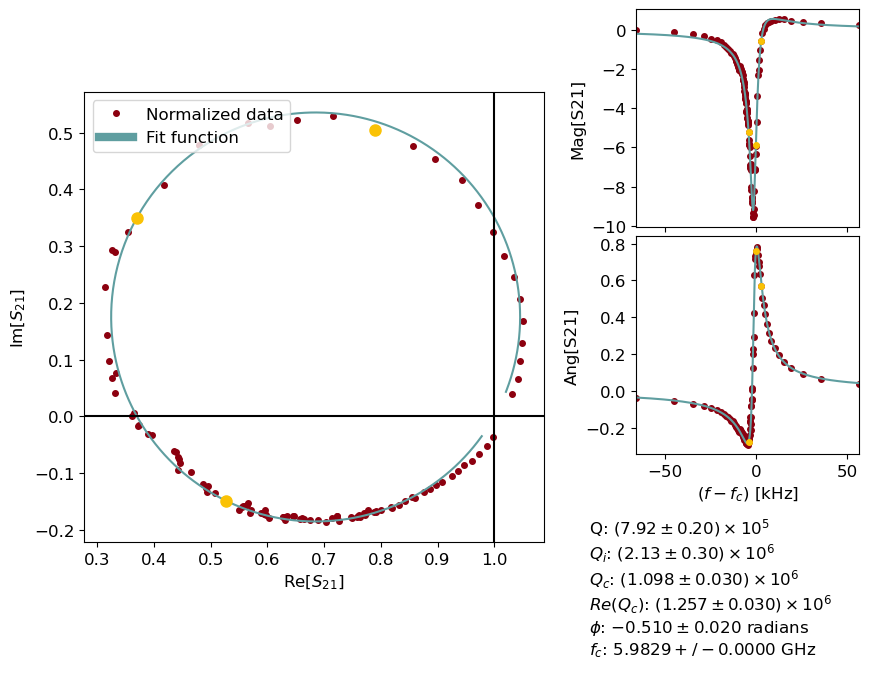

1.078562629017123
0.39700632856933726


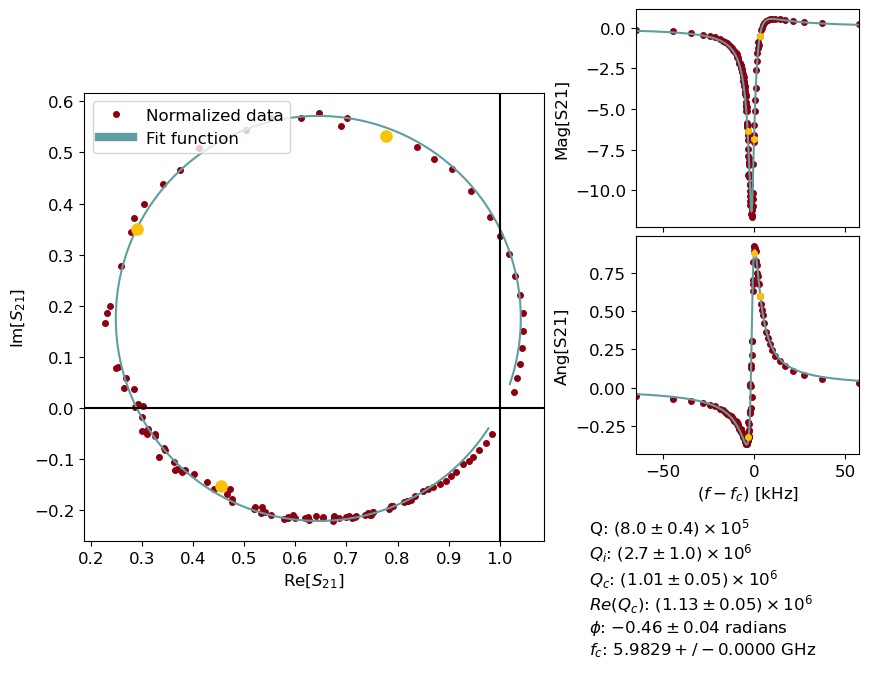

1.5860673916190076
0.4336194163586626


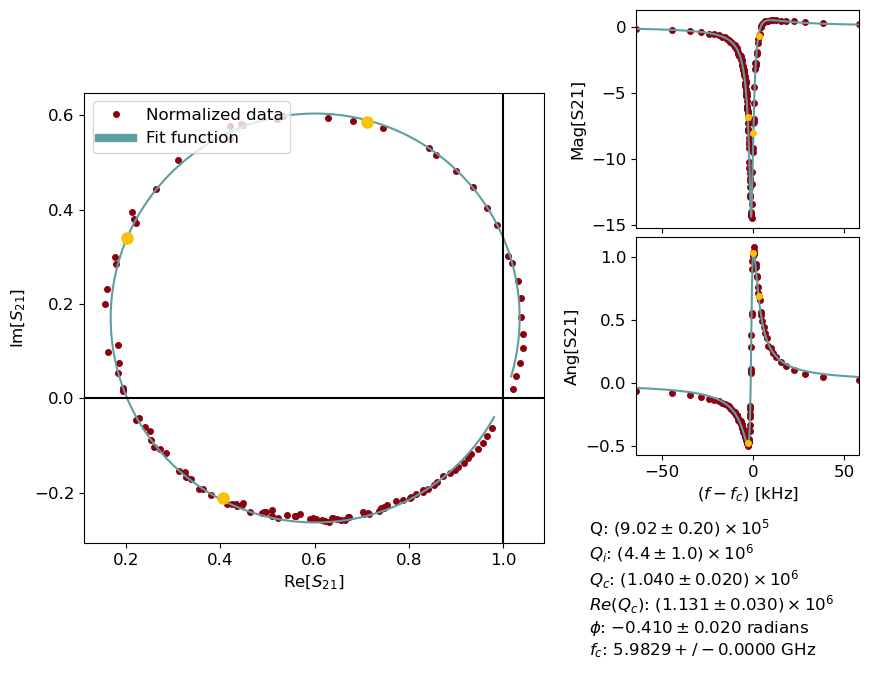

2.3453147920064996
0.47277138389759804


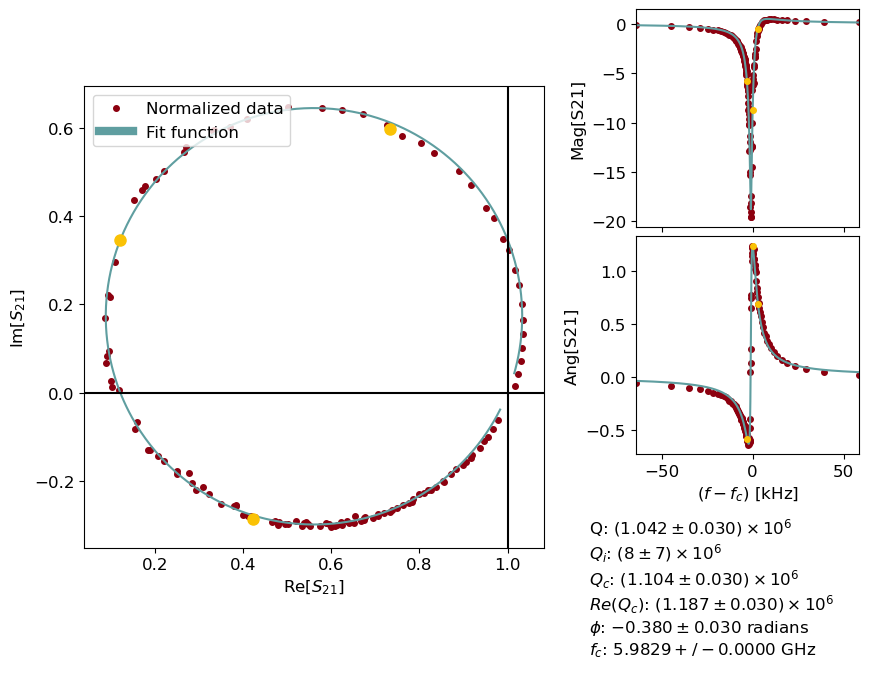

3.455835229054237
0.508003605279273


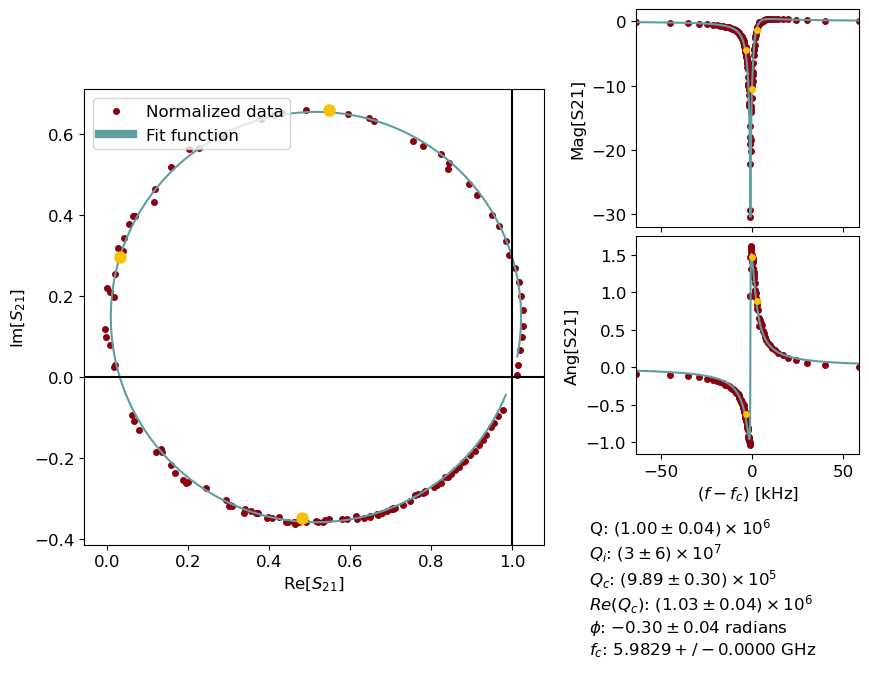

4.92948701185017
0.5380850531092498
Qi is less than zero. Please make sure data is of correct format: decibals (log10*20 version), and radians. Otherwise, it is quite likely that the resonator being fit is not a Notch type resonator. Other types of resonators will not work with this code.


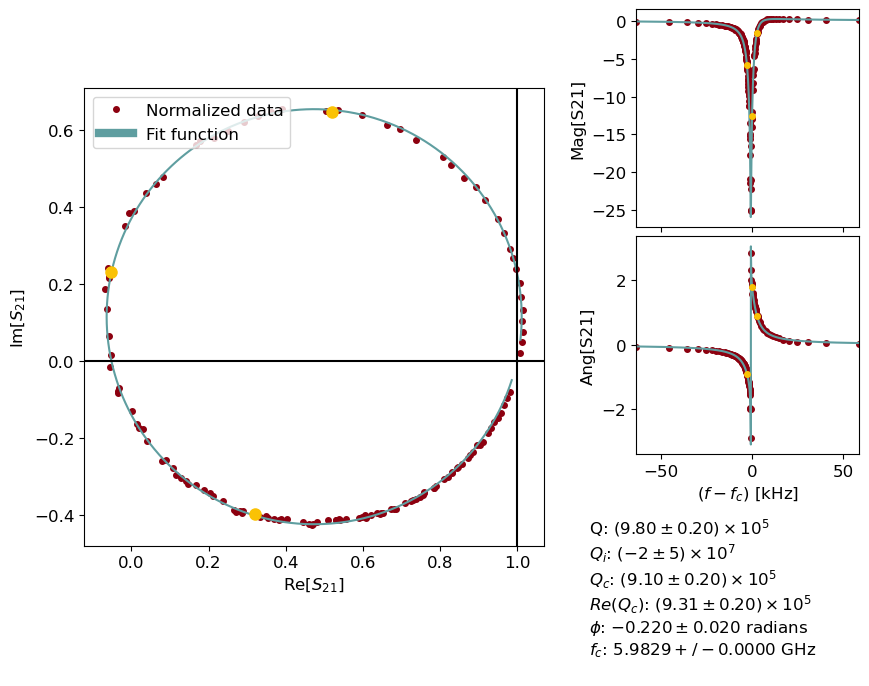

6.841218823823755
0.5550808364898369
Qi is less than zero. Please make sure data is of correct format: decibals (log10*20 version), and radians. Otherwise, it is quite likely that the resonator being fit is not a Notch type resonator. Other types of resonators will not work with this code.


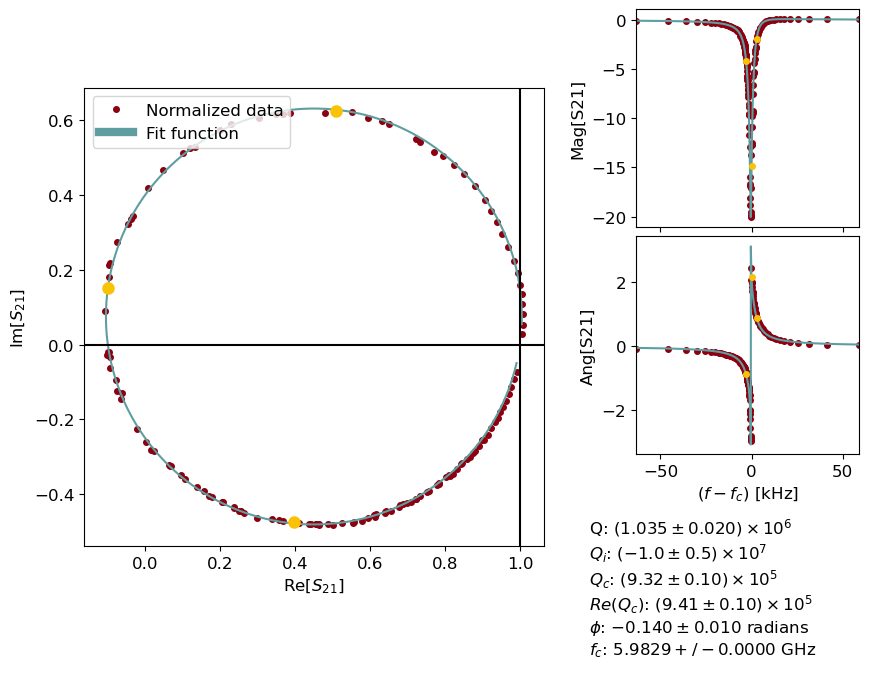

9.55381720969113
0.5617368903765763
Qi is less than zero. Please make sure data is of correct format: decibals (log10*20 version), and radians. Otherwise, it is quite likely that the resonator being fit is not a Notch type resonator. Other types of resonators will not work with this code.


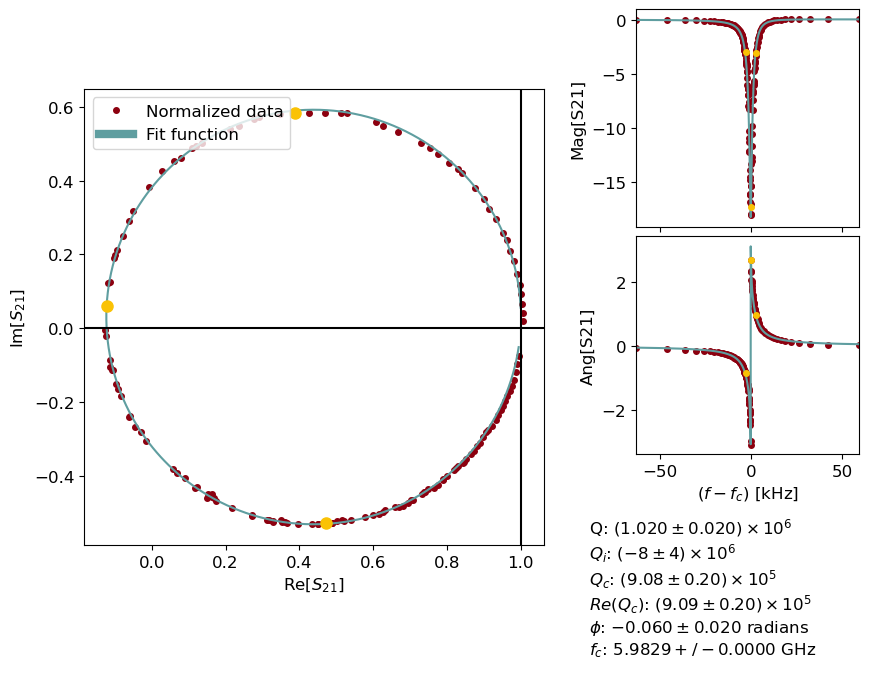

13.779925694622941
0.5716526787495428
Qi is less than zero. Please make sure data is of correct format: decibals (log10*20 version), and radians. Otherwise, it is quite likely that the resonator being fit is not a Notch type resonator. Other types of resonators will not work with this code.


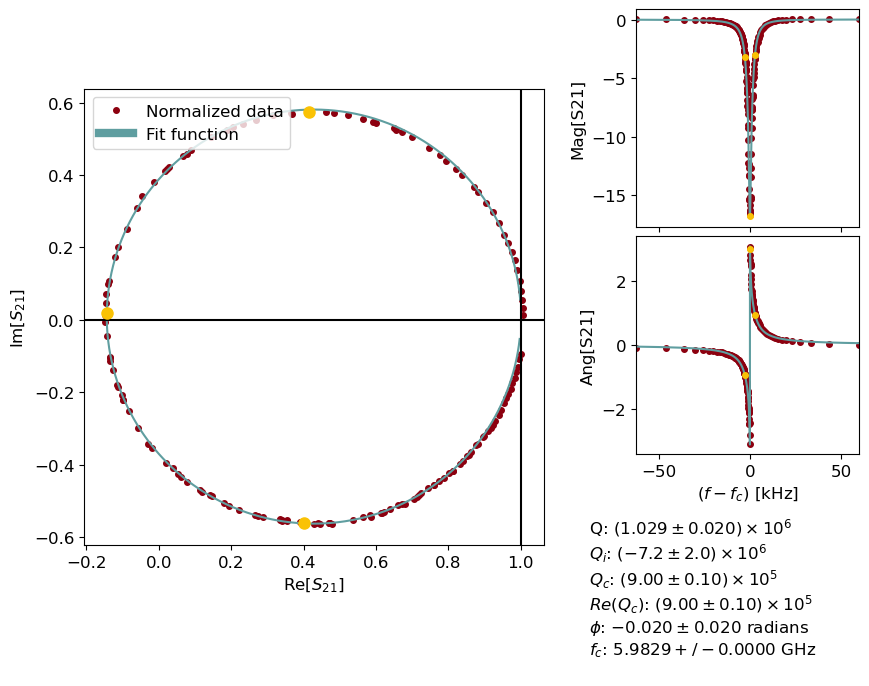

Time elapsed:  7.298631429672241
['res_6321_24', 'res_6321_21', 'res_6321_18', 'res_6321_15', 'res_6321_12', 'res_6321_9', 'res_6321_6', 'res_6321_3', 'res_6321_0']
0.31402448733787564
0.11175101491272157


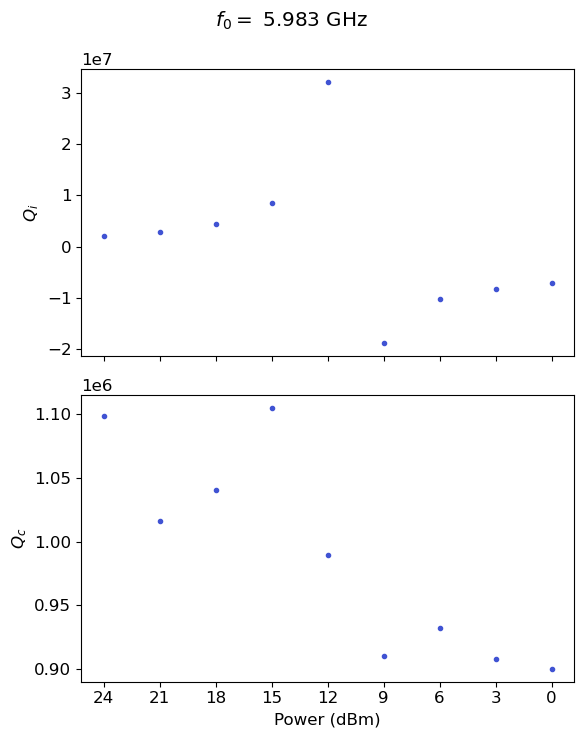

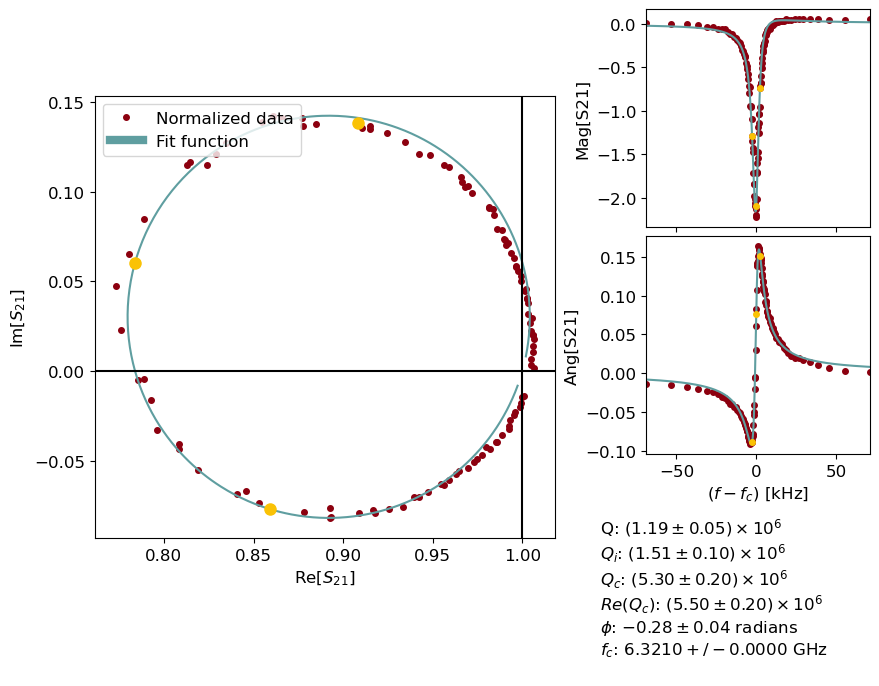

0.4726239309028986
0.12103919931085154


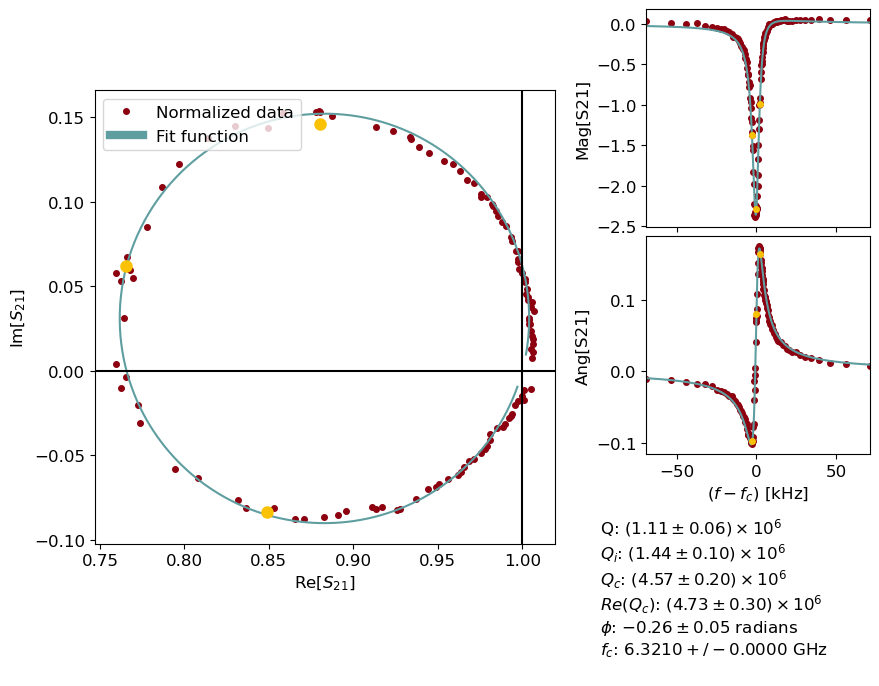

0.6922411672131665
0.12653401328458164


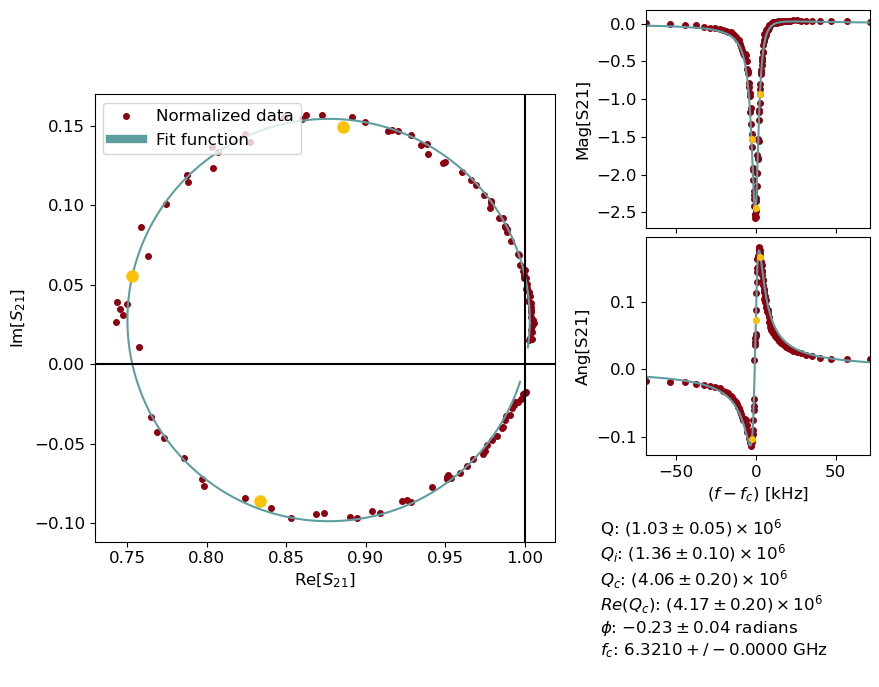

1.0241180898437752
0.1327067473180879


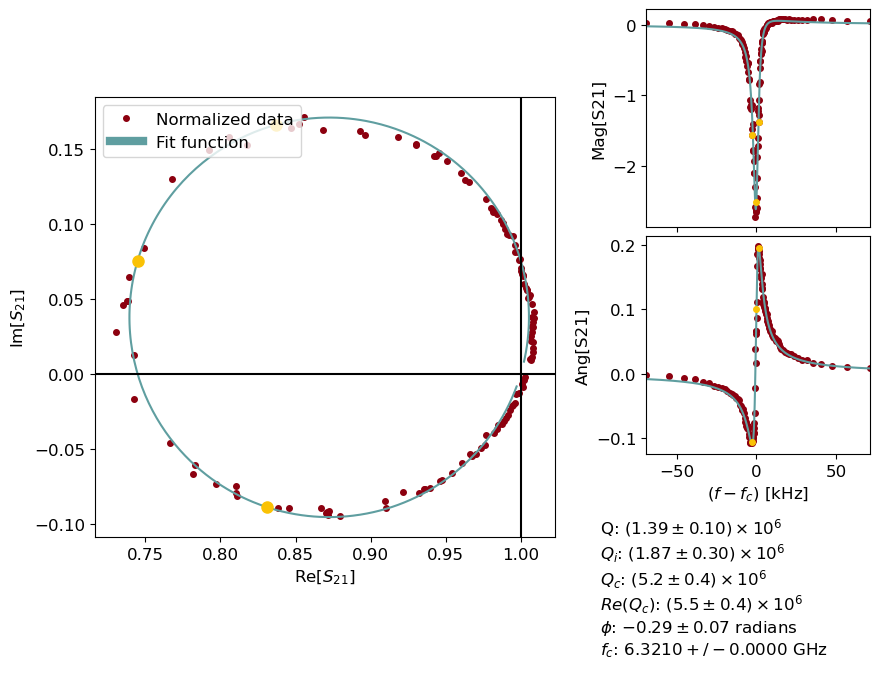

1.5850653636778125
0.14412115345119436


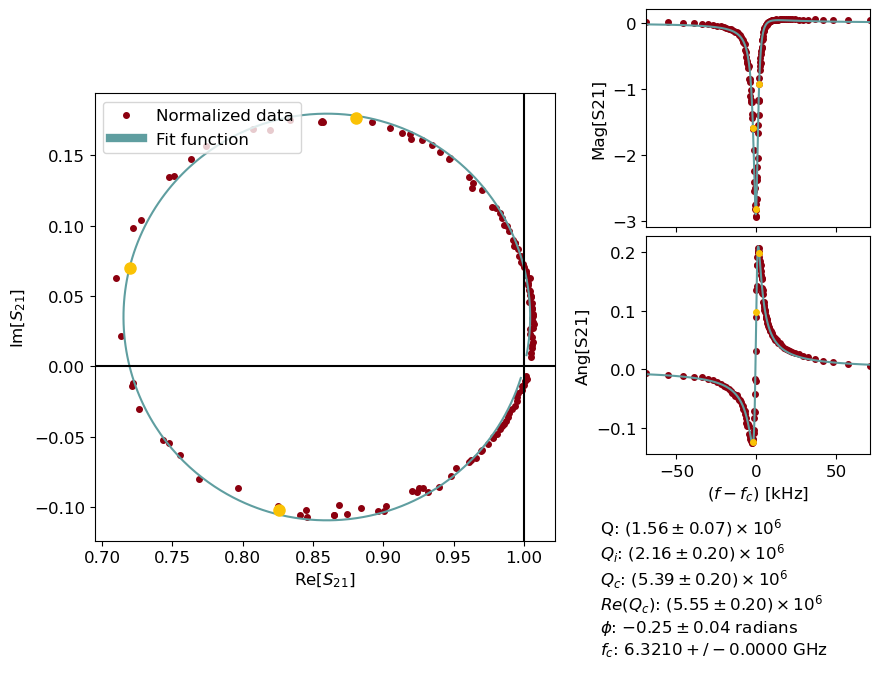

2.322441099850062
0.15058785197687158


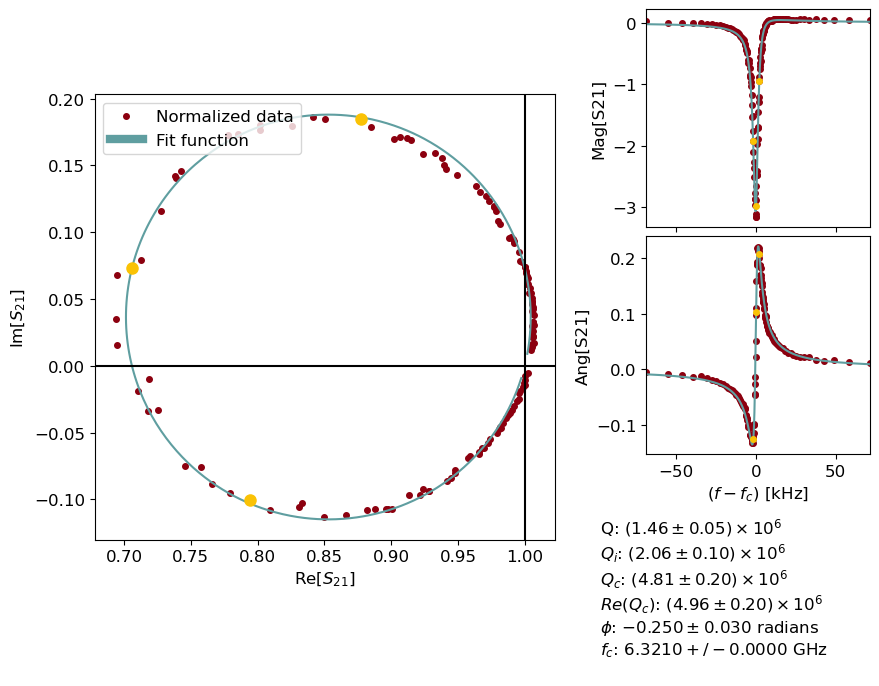

3.441748408068834
0.16201358500698504


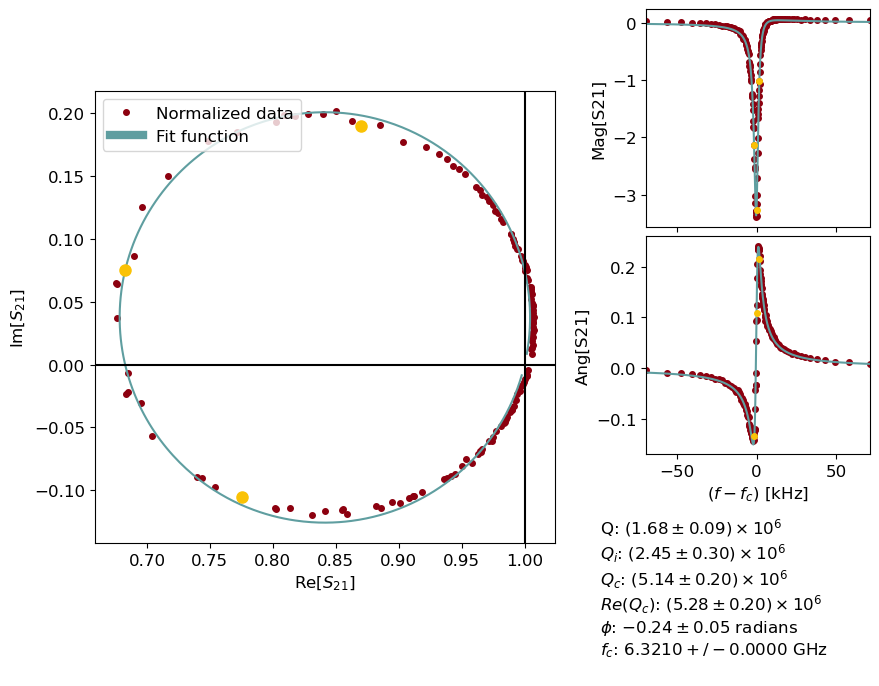

5.071514078341456
0.17147448838403972


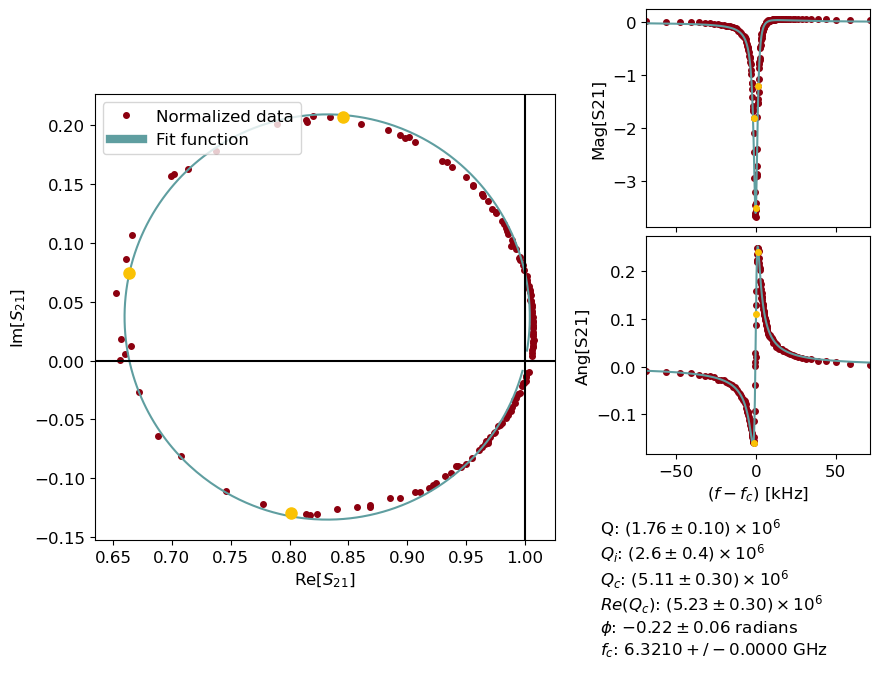

7.6270415061050185
0.18095757267690327


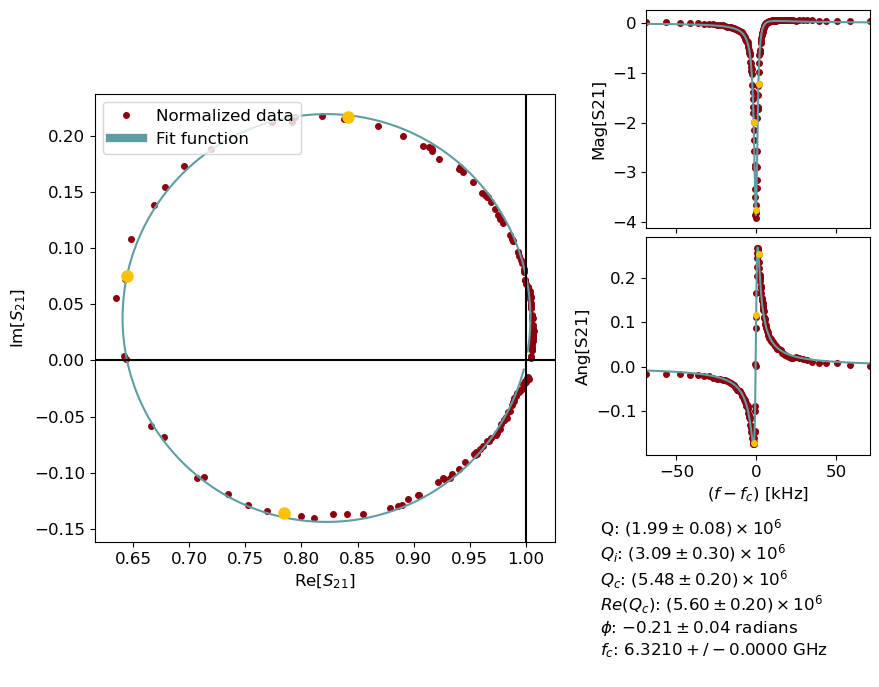

Time elapsed:  14.984378337860107
['res_6680_24', 'res_6680_21', 'res_6680_18', 'res_6680_15', 'res_6680_12', 'res_6680_9', 'res_6680_6', 'res_6680_3', 'res_6680_0']
0.25092179361708805
0.099549378453336


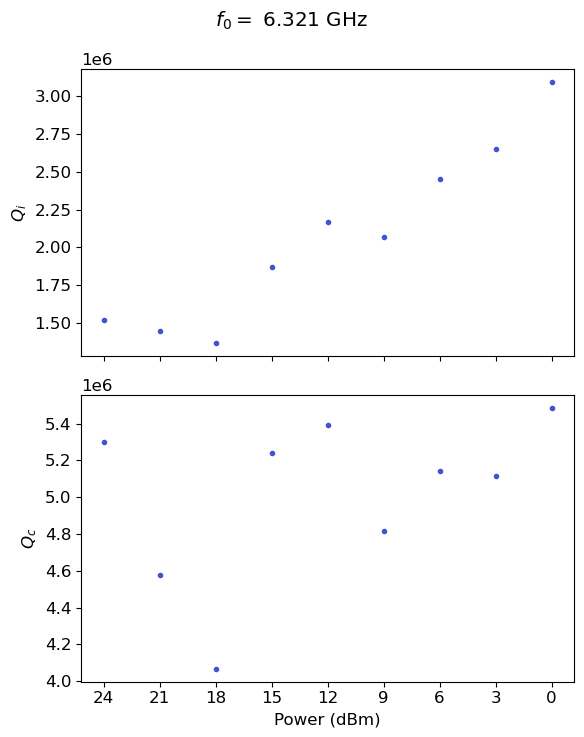

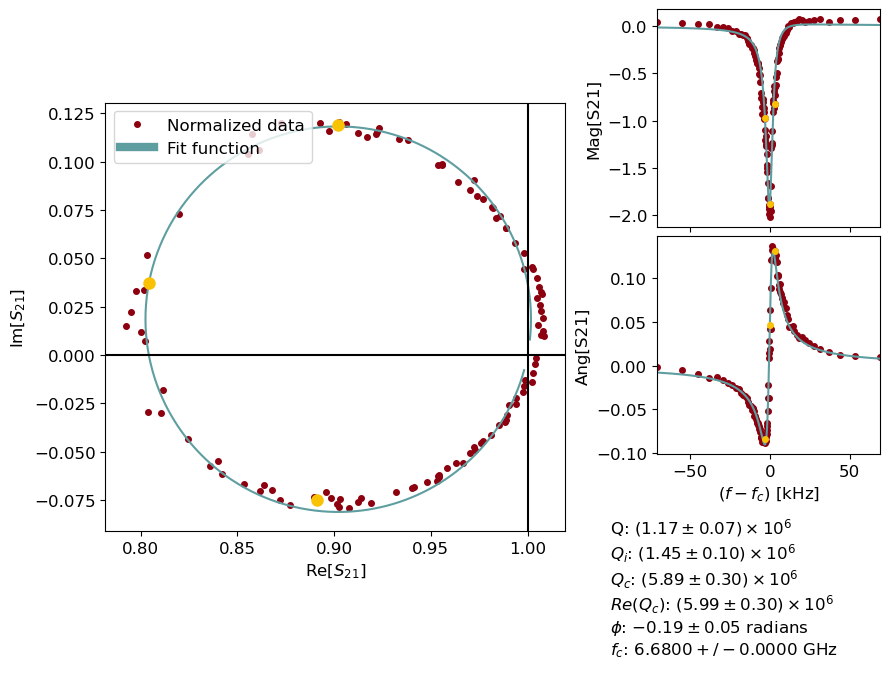

0.3975909713172876
0.11332260494335535


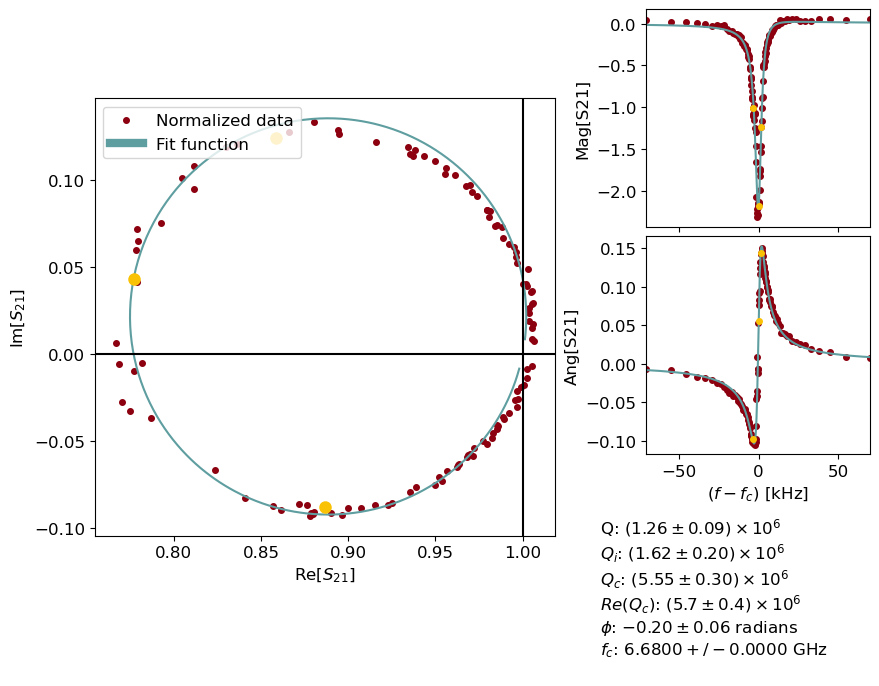

0.6331064444988858
0.12914444364099


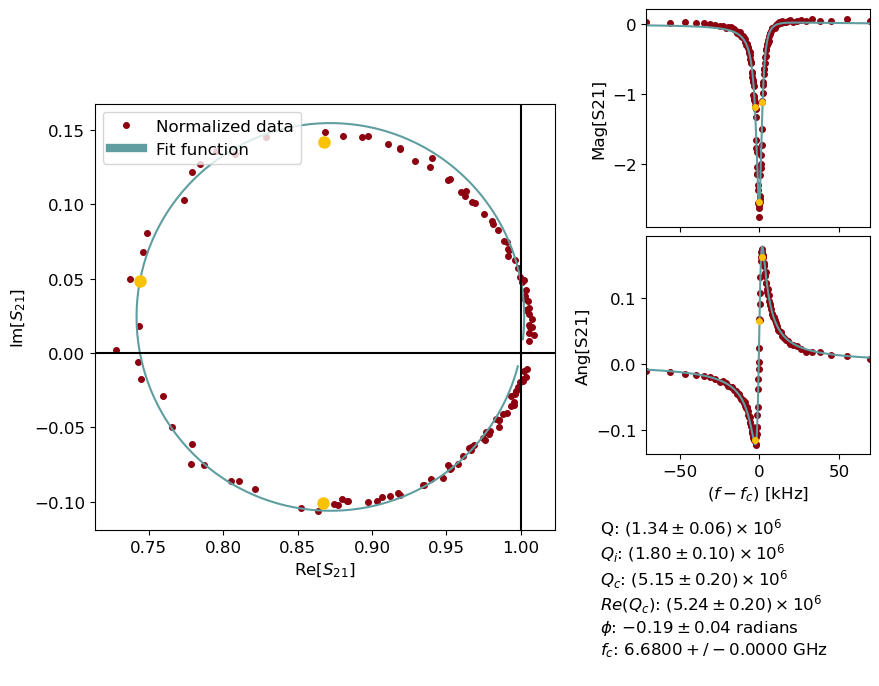

0.9622395288039549
0.13888871027620925


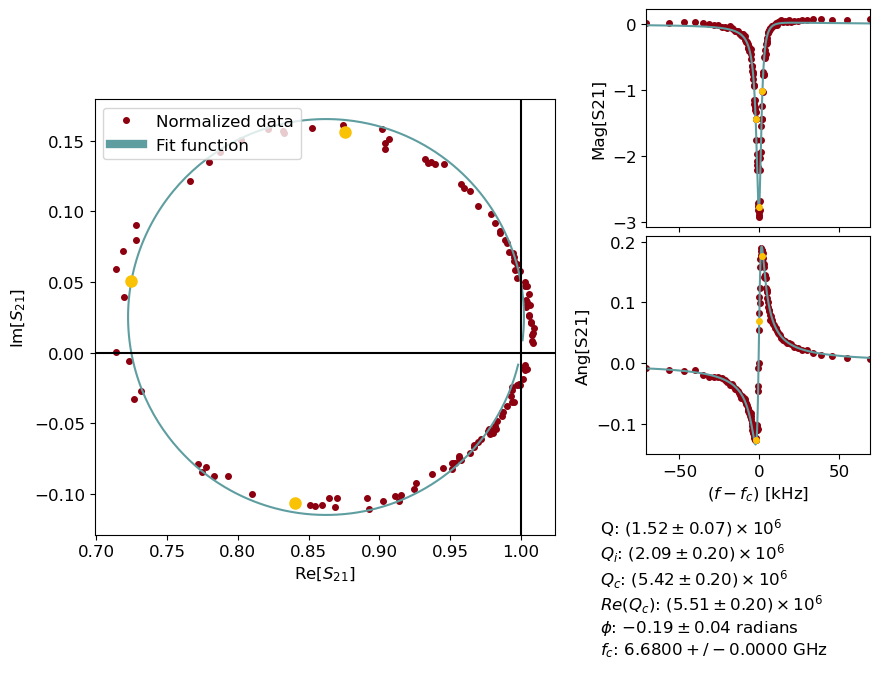

1.4759731240058915
0.14865428038712158


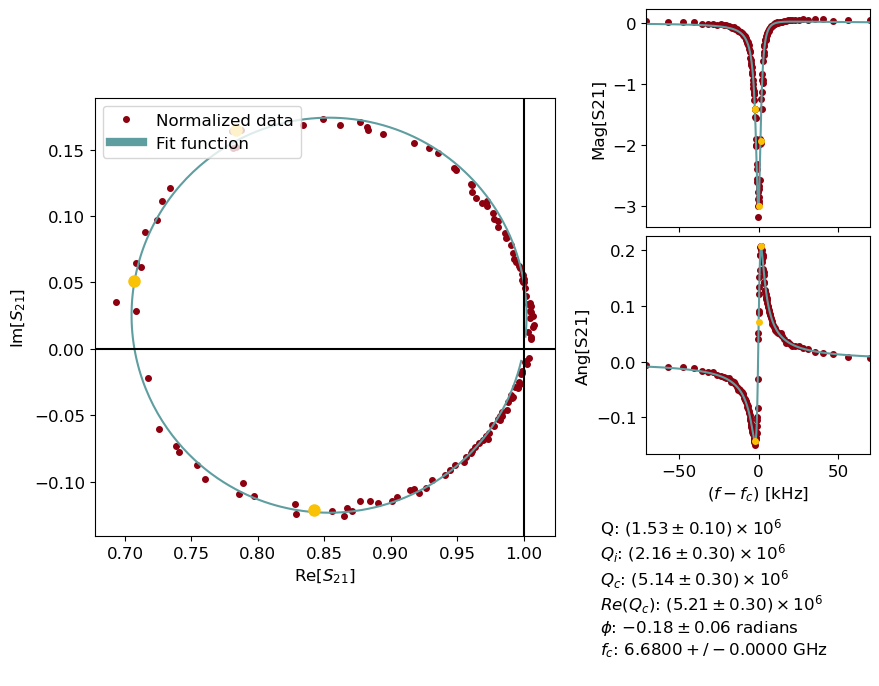

2.1835727662736946
0.15613074592286402


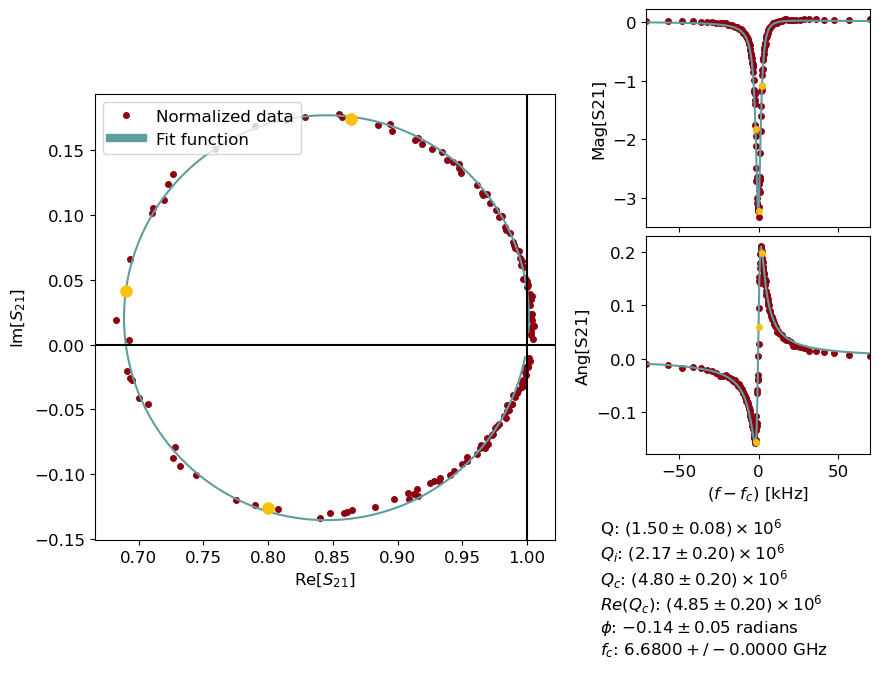

3.1440608317945618
0.16258381453899248


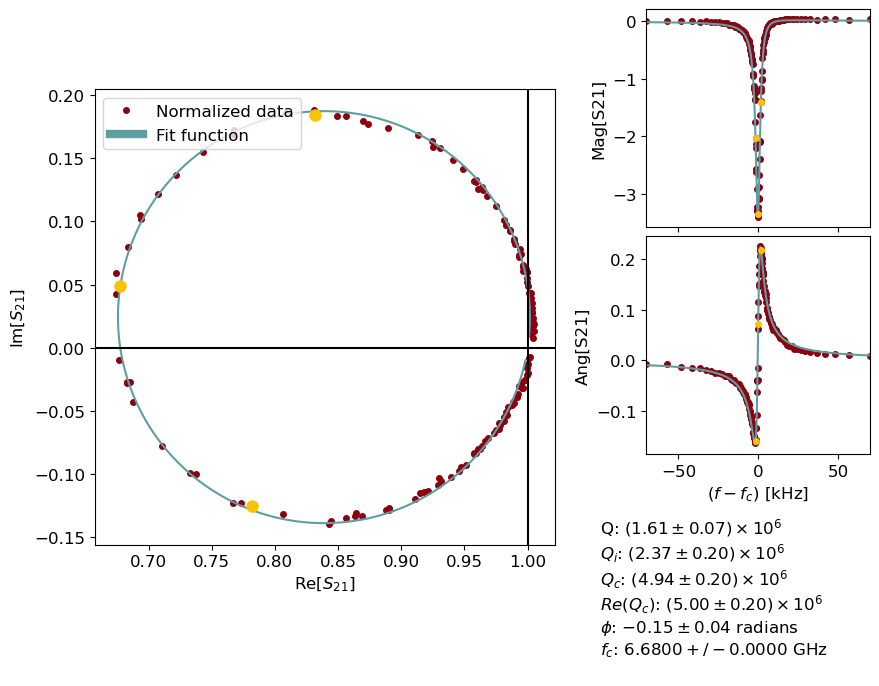

4.500552474001573
0.16655738391892852


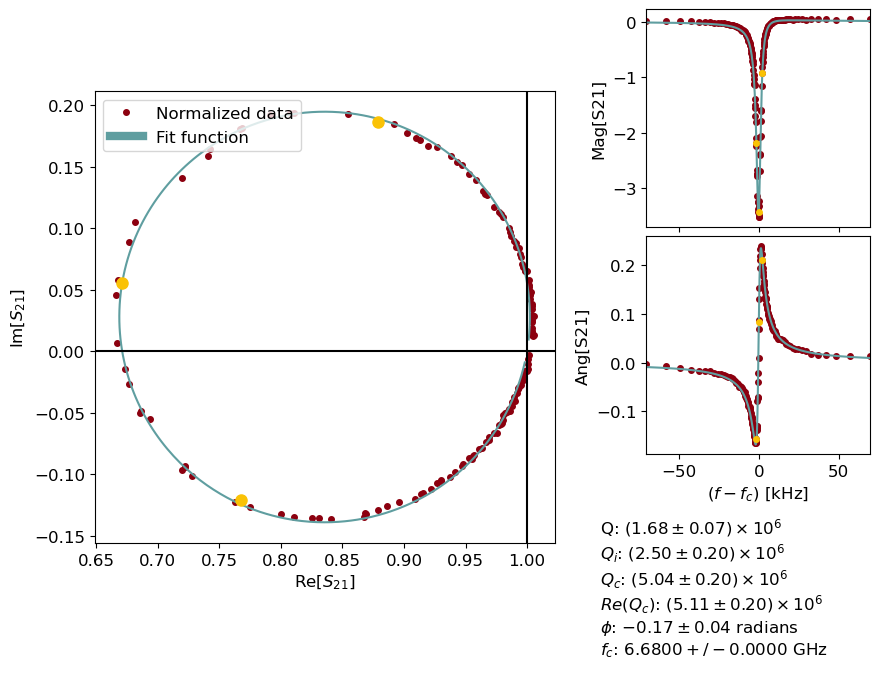

6.663690368192929
0.17200448909392554


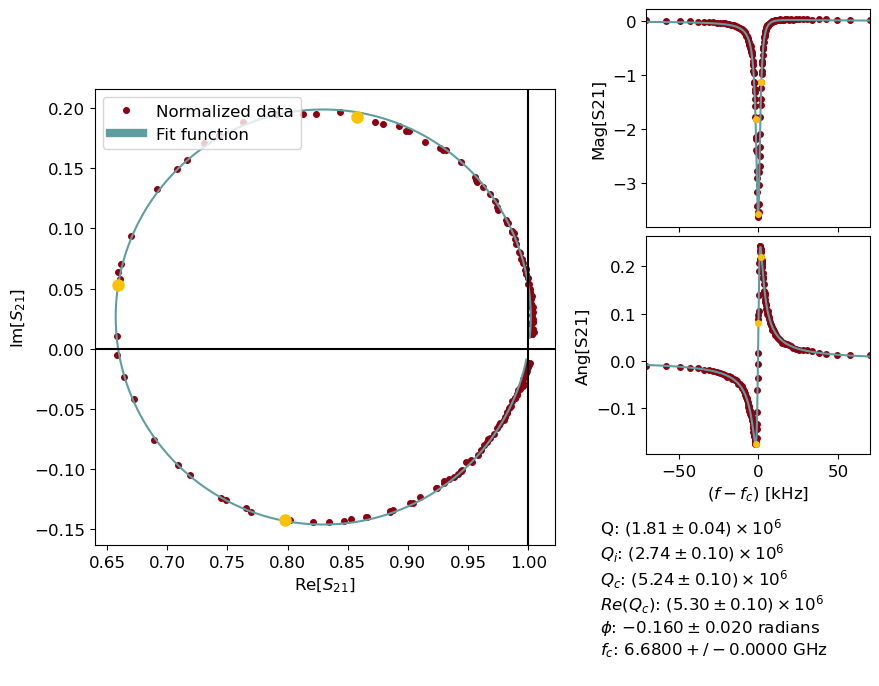

Time elapsed:  24.0254864692688
['res_6692_24', 'res_6692_21', 'res_6692_18', 'res_6692_15', 'res_6692_12', 'res_6692_9', 'res_6692_6', 'res_6692_3', 'res_6692_0']
0.06616714521097496
0.02066716623184192


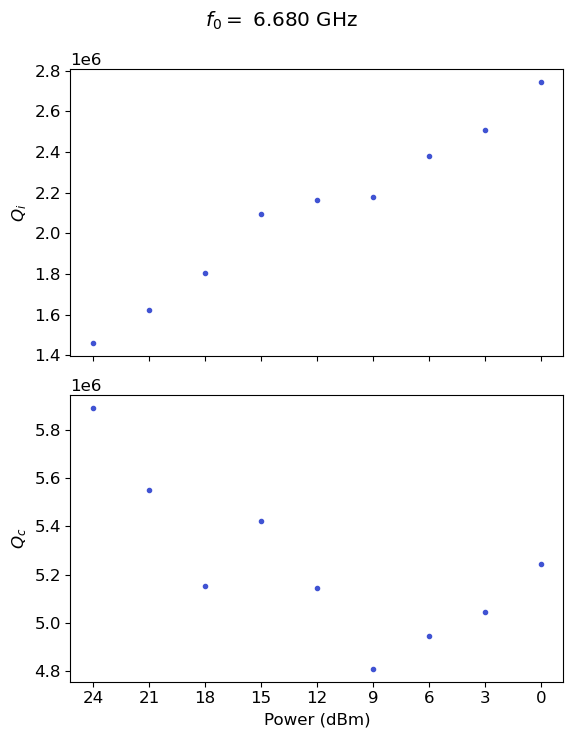

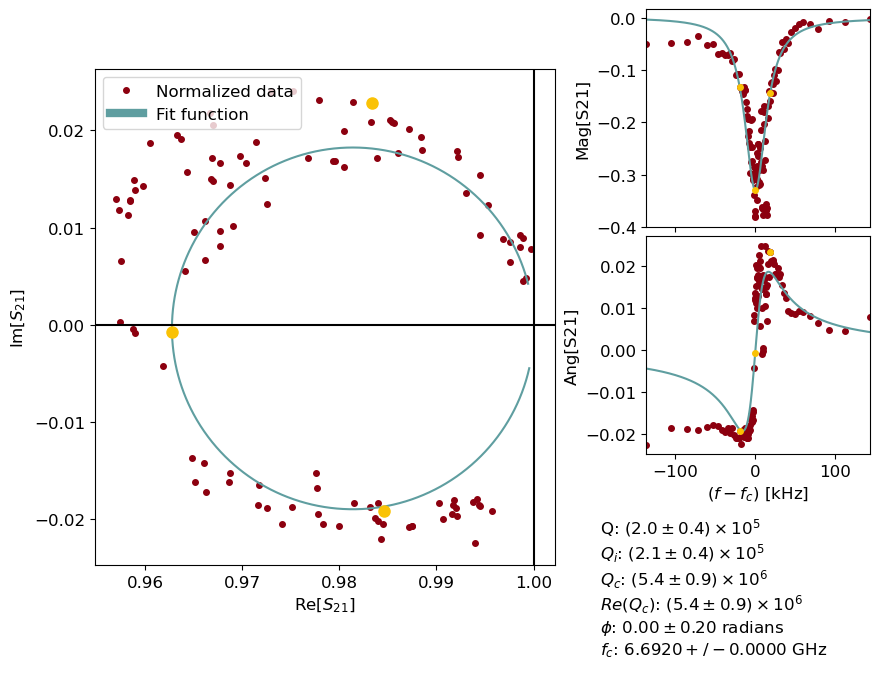

0.11011606191768877
0.024615676139874212


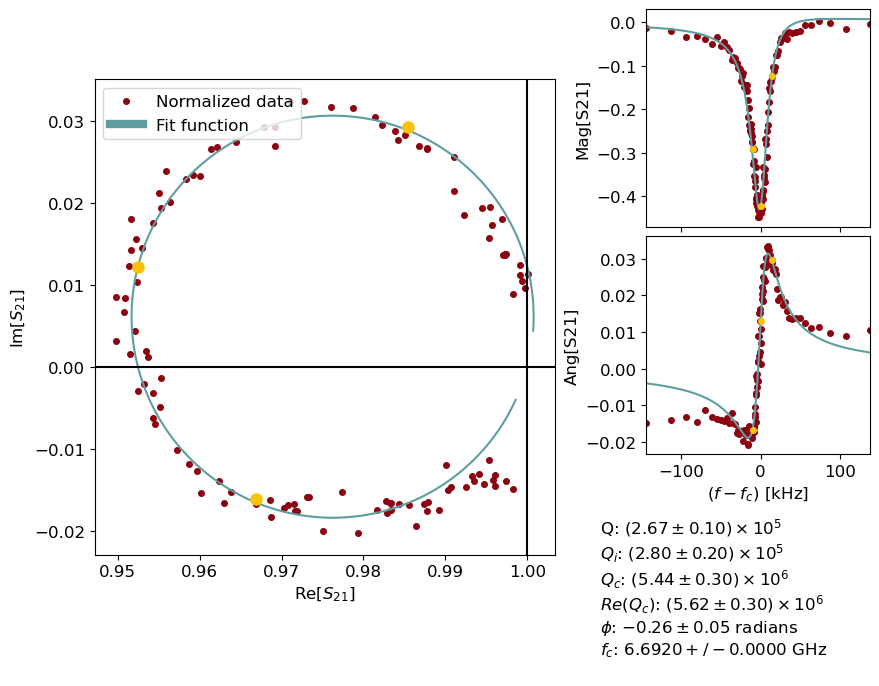

0.159811188324072
0.02561847419707473


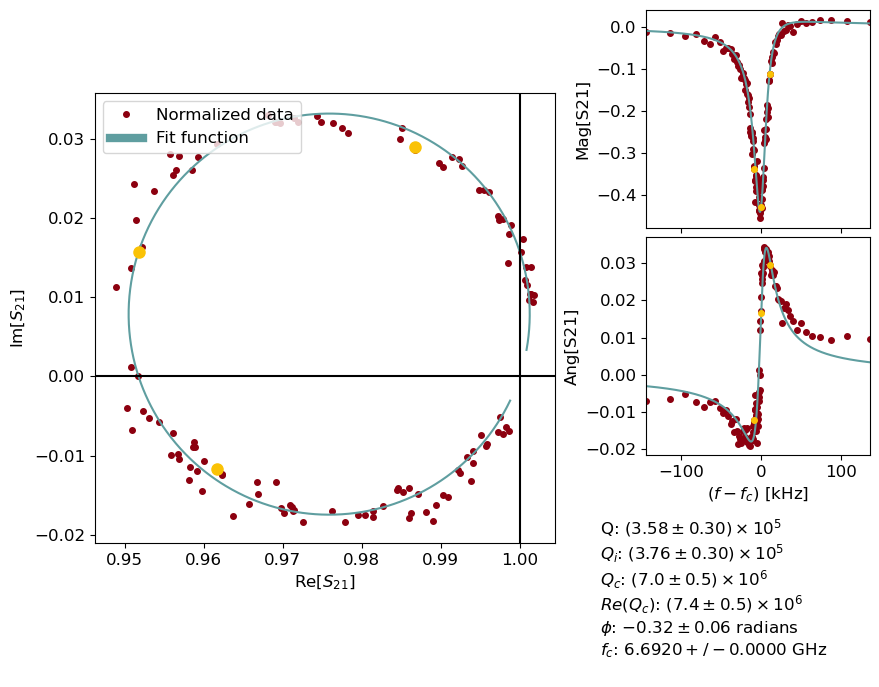

0.2300975680800732
0.02612356700763679


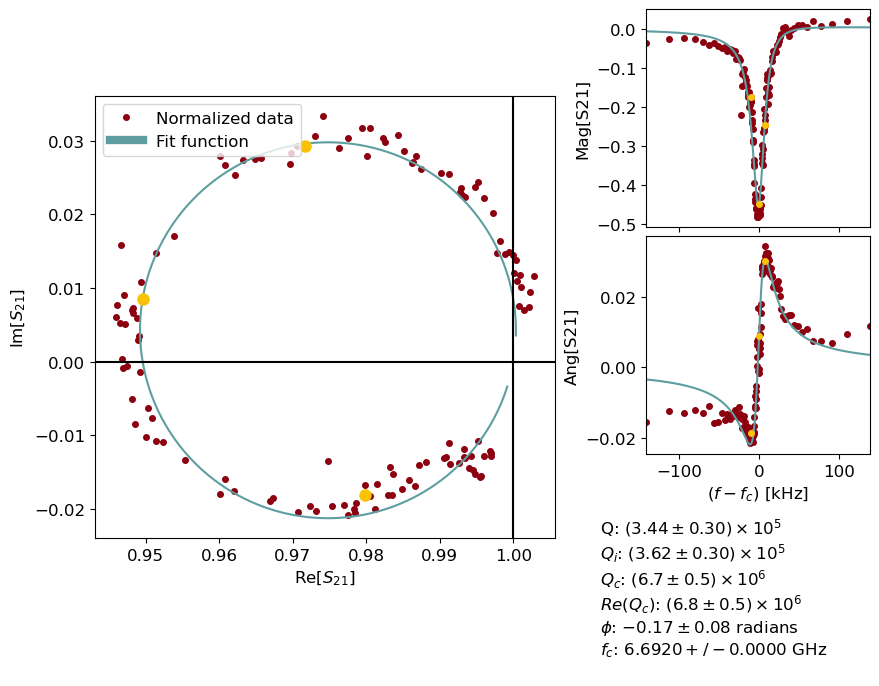

0.3565584505024113
0.028399314508743608


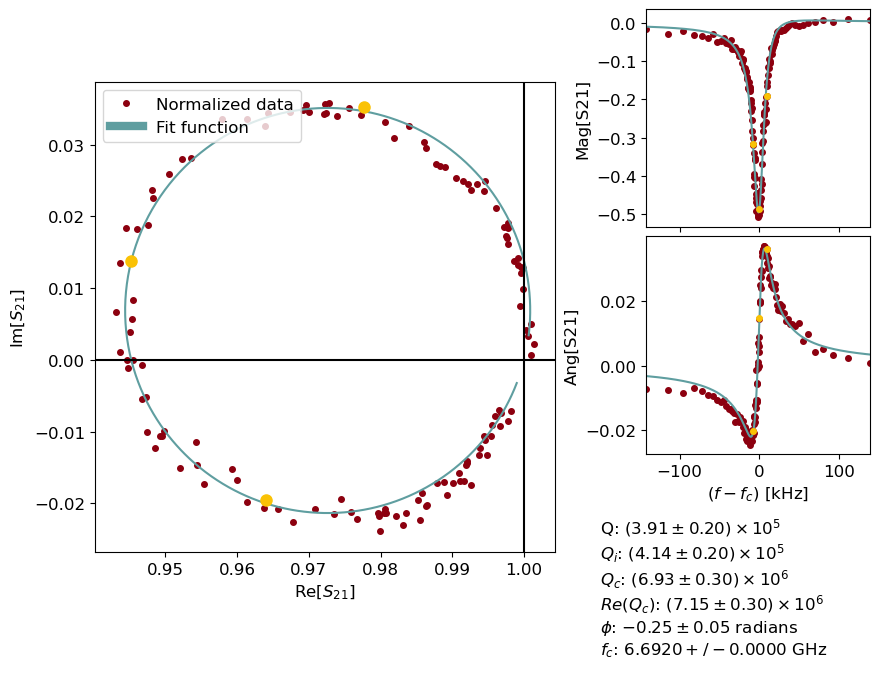

0.5135421427739112
0.02910517764436437


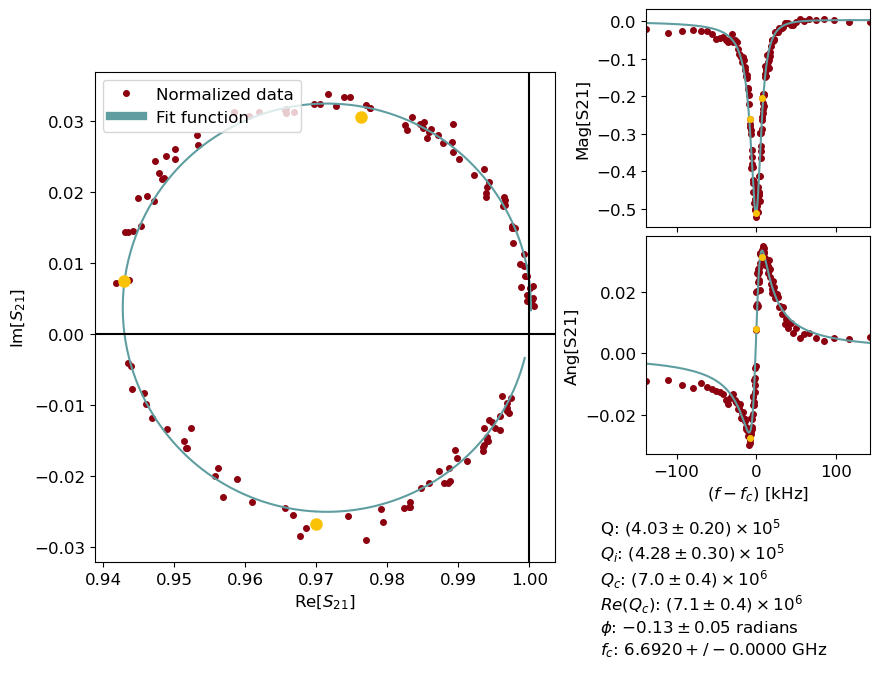

0.7534362606196352
0.03104009579391261


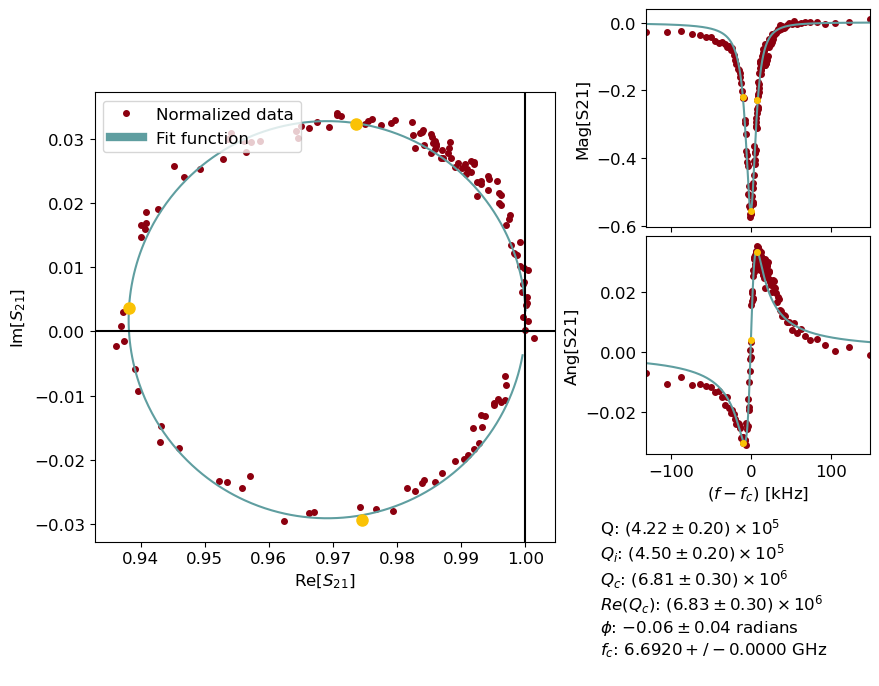

1.0973808207345672
0.03254144122728538


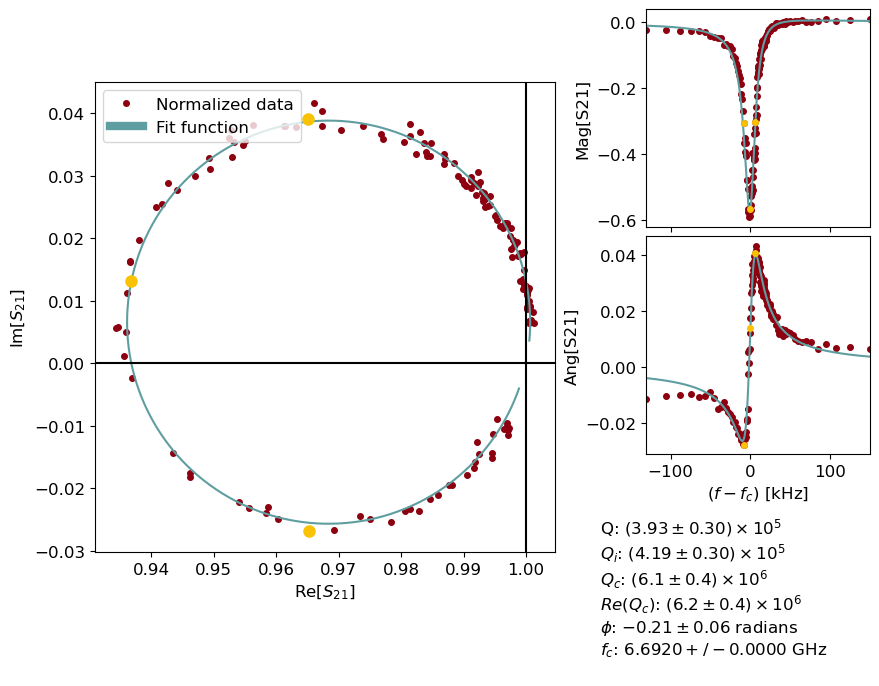

1.6068992058620766
0.03349088339100341


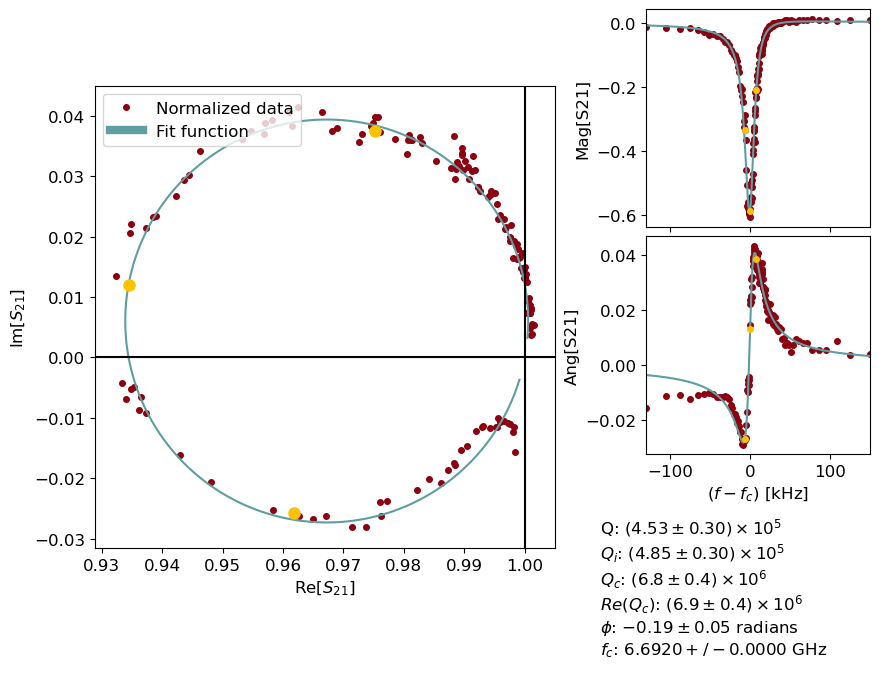

Time elapsed:  32.20331025123596
['res_6992_24', 'res_6992_21', 'res_6992_18', 'res_6992_15', 'res_6992_12', 'res_6992_9', 'res_6992_6', 'res_6992_3', 'res_6992_0']
0.14017922928359763
0.1344658731815541


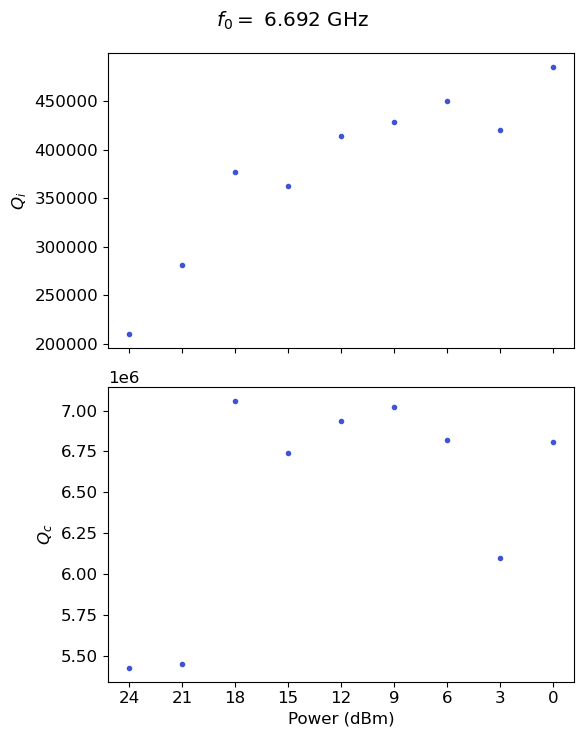

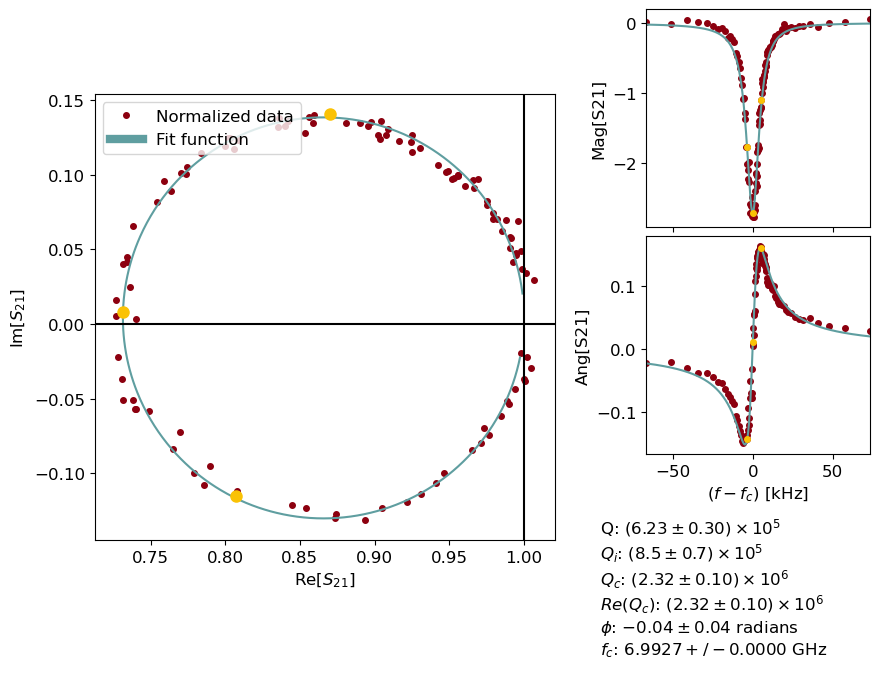

0.20323853943424314
0.14133991457480968


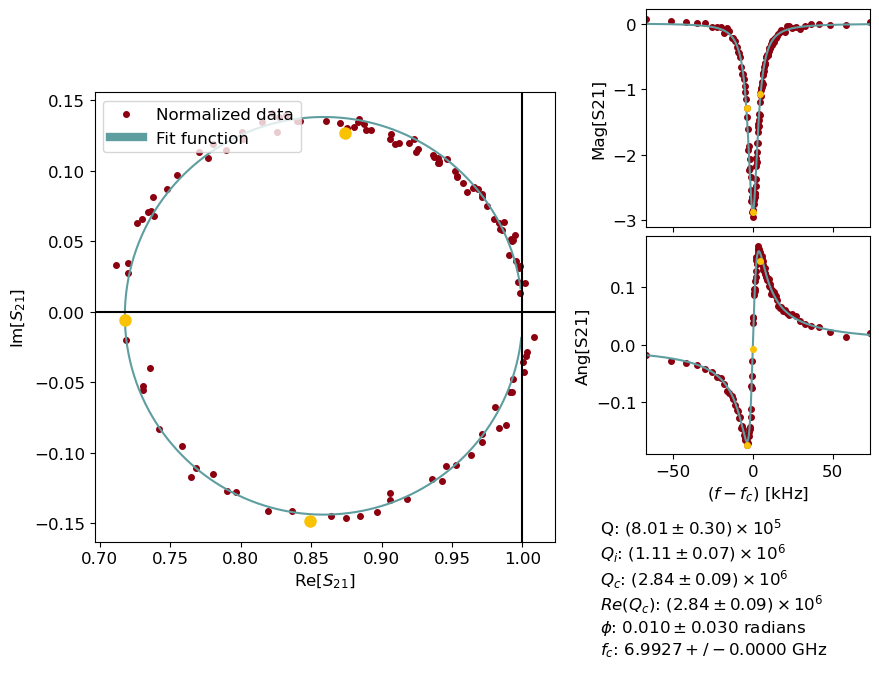

0.298378933478002
0.15009130763564102


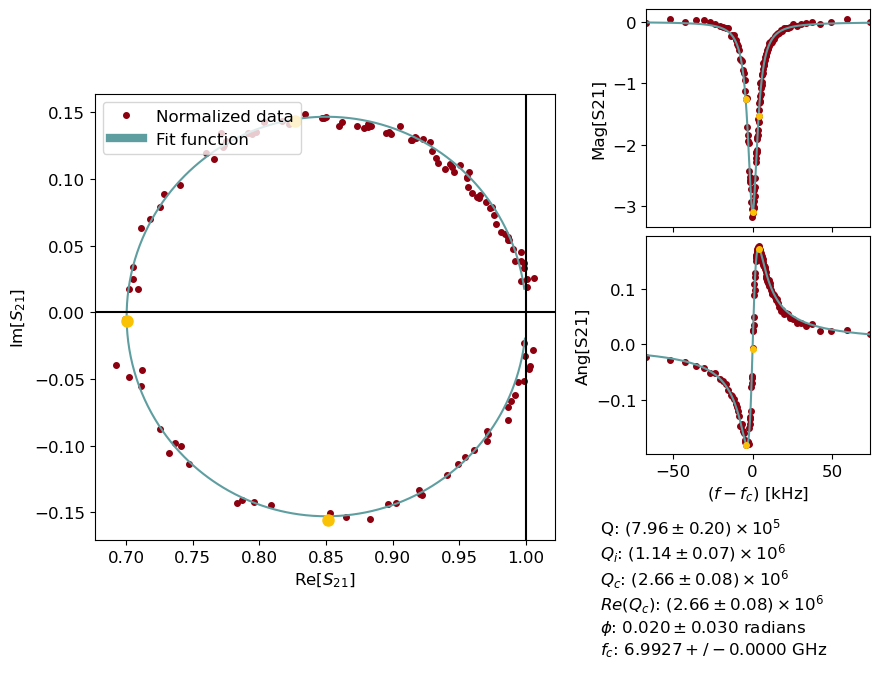

0.4369554751844866
0.15721769704842098


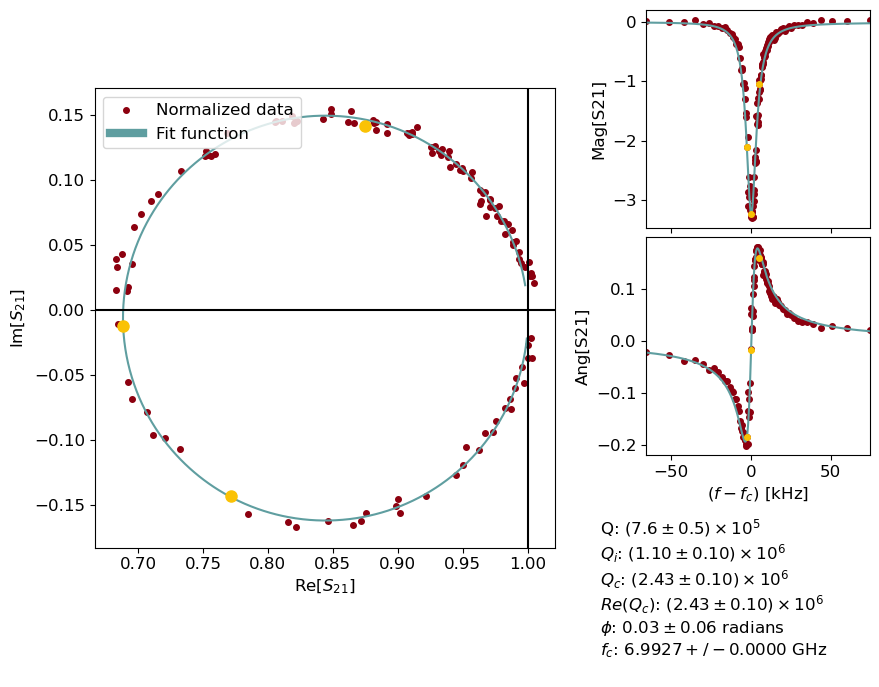

0.6293319701243658
0.16033045390424208


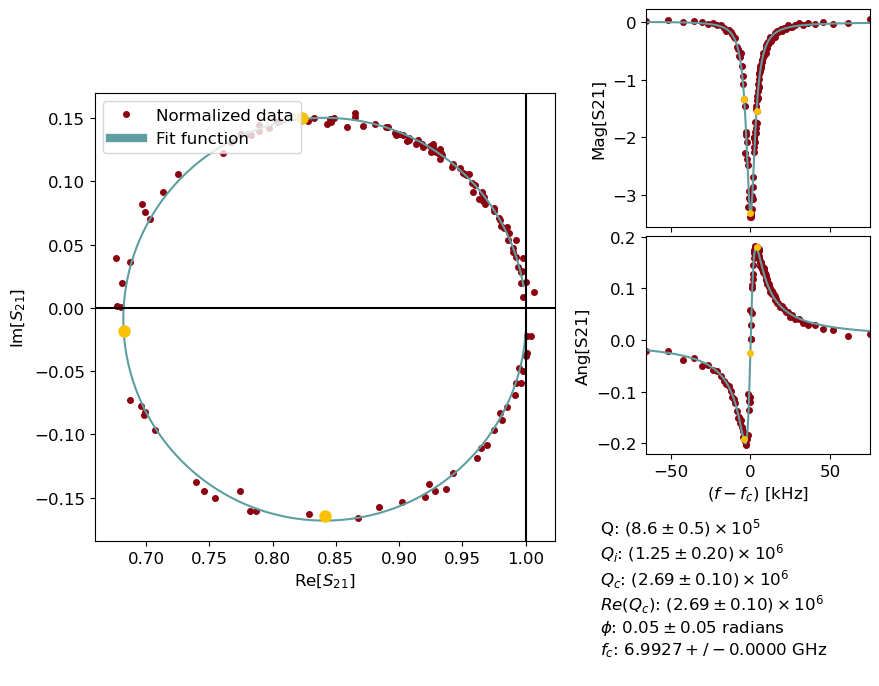

0.9102368464406282
0.1669894155738229


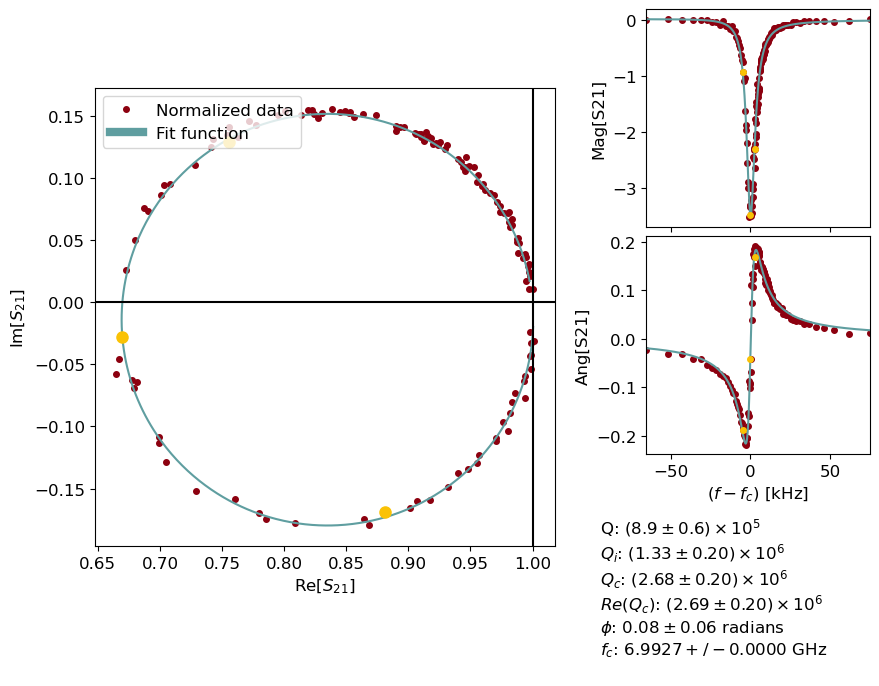

1.2618464445156399
0.17002940915992065


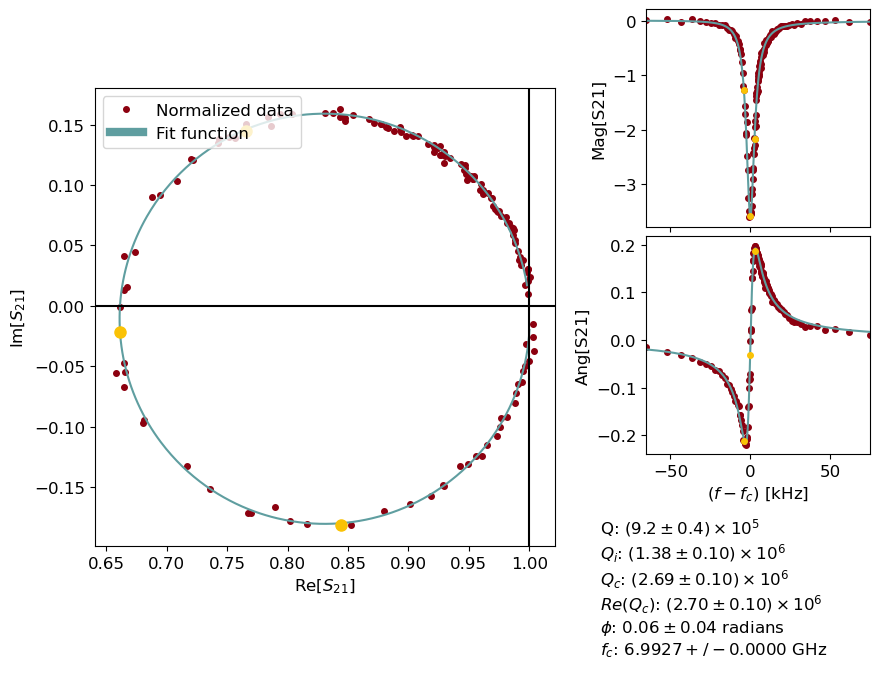

1.7668042133357713
0.1736954168824571


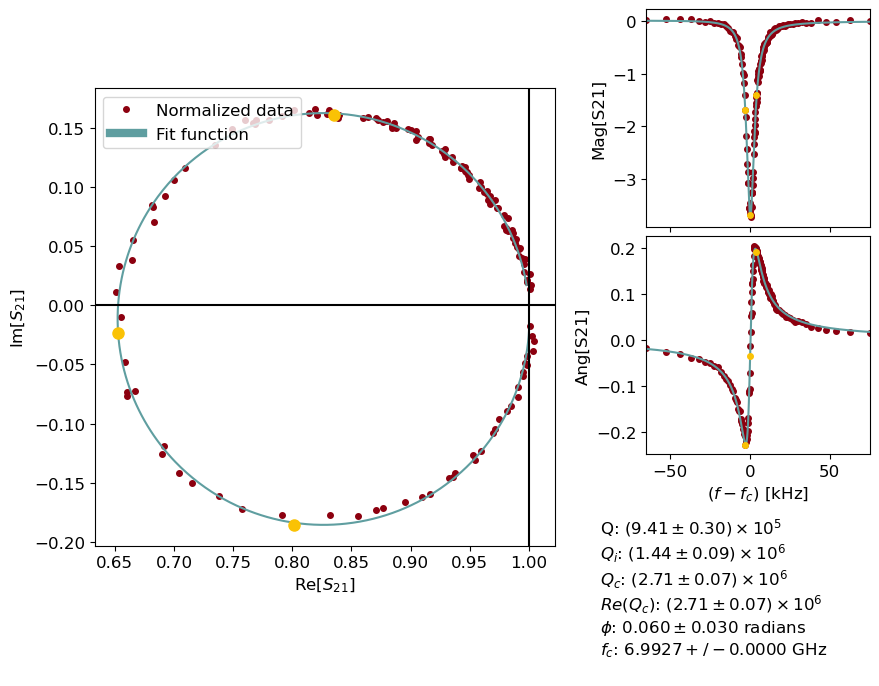

2.5344397030341224
0.17664152937936797


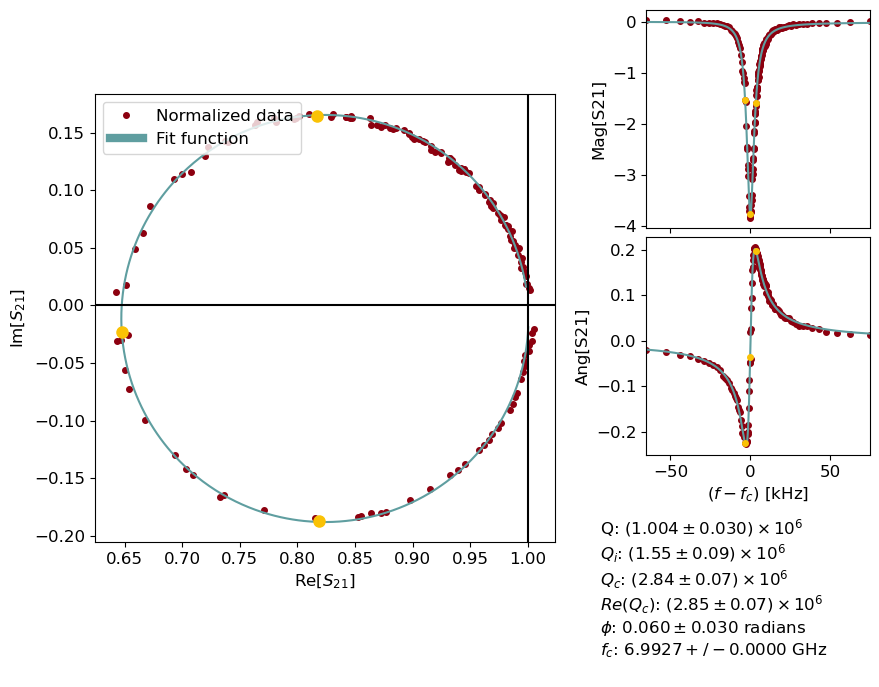

Time elapsed:  41.06091356277466
['res_7067_24', 'res_7067_21', 'res_7067_18', 'res_7067_15', 'res_7067_12', 'res_7067_9', 'res_7067_6', 'res_7067_3', 'res_7067_0']
0.06893692349231298
0.05785206456236206


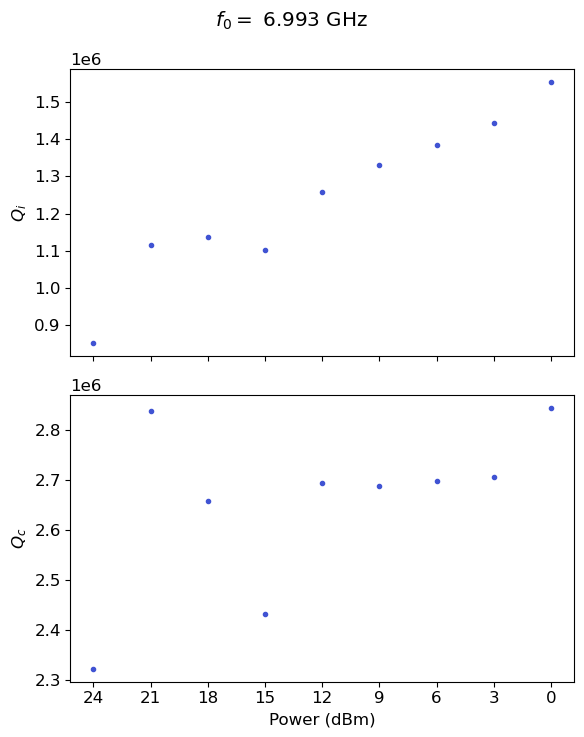

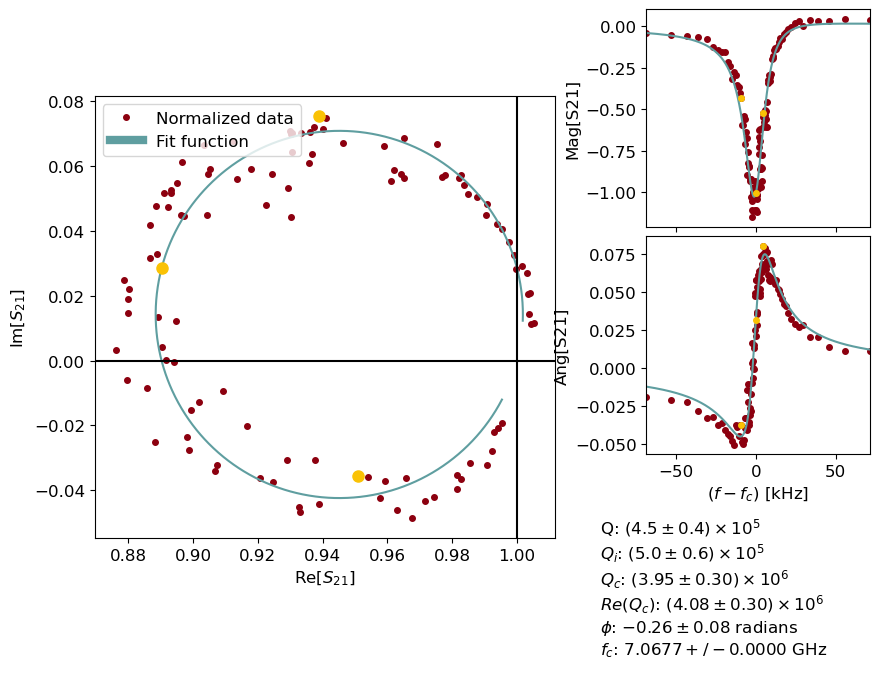

0.11075082126220318
0.06714188470783106


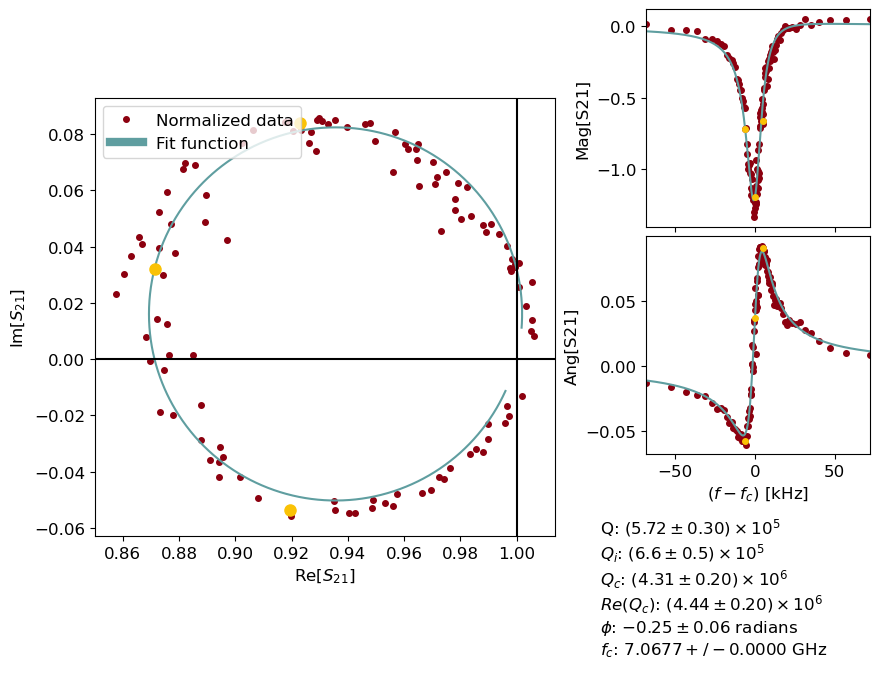

0.17354510409845347
0.07543482859511509


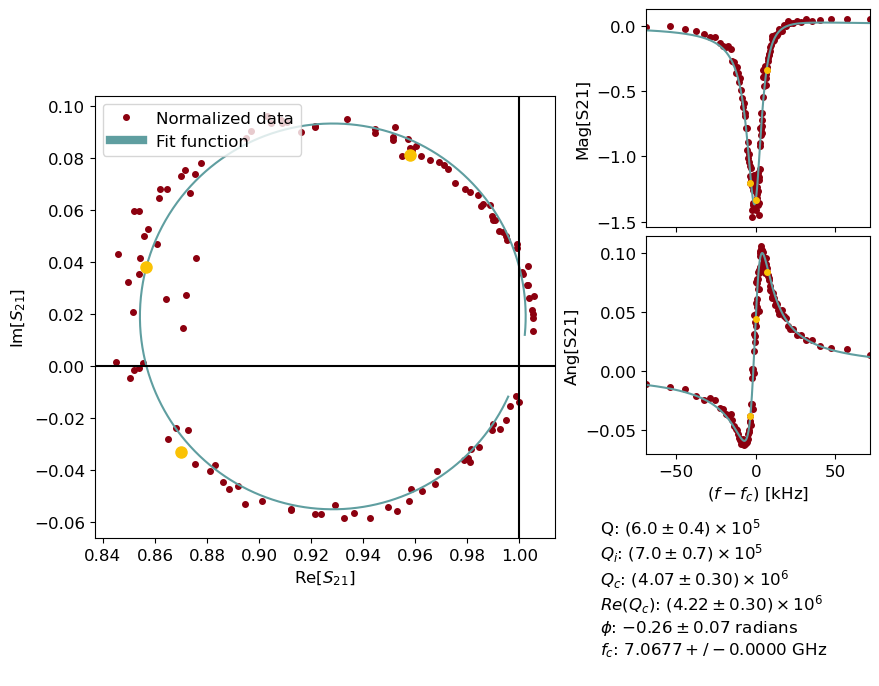

0.259785196528578
0.08076172081830674


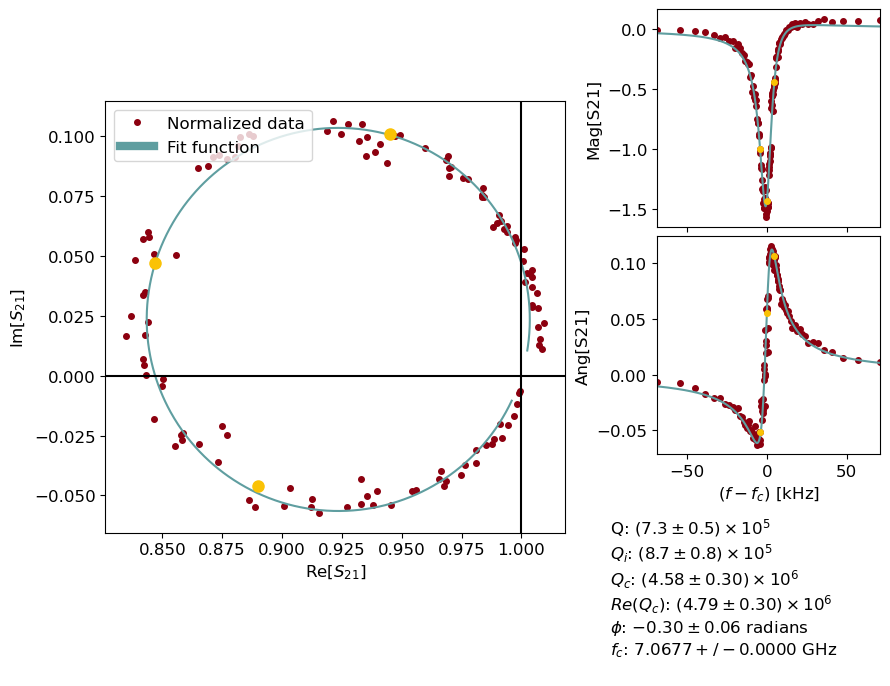

0.42050731034513406
0.09239696343065135


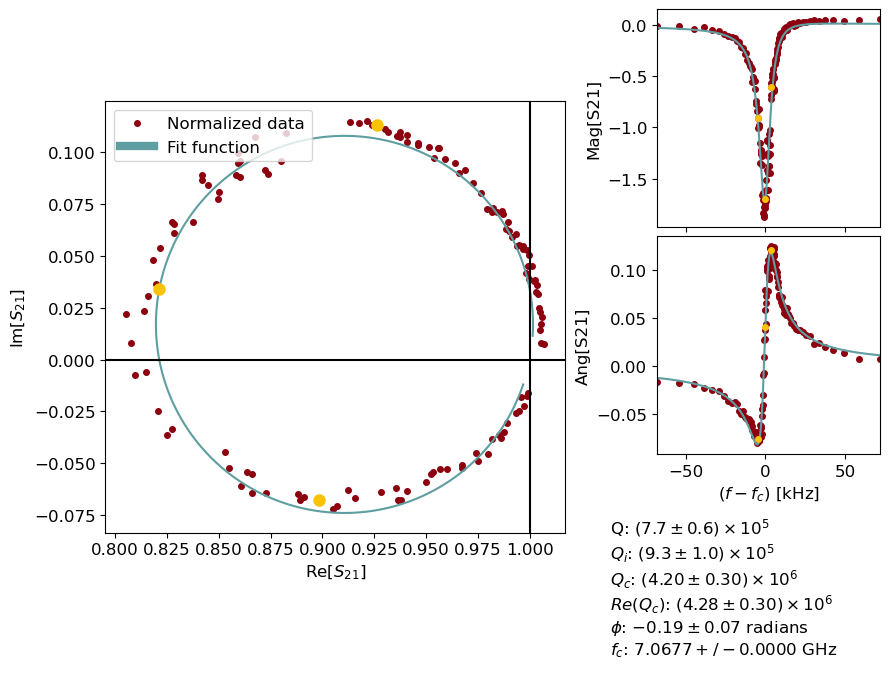

0.6302467465939818
0.10014995209454979


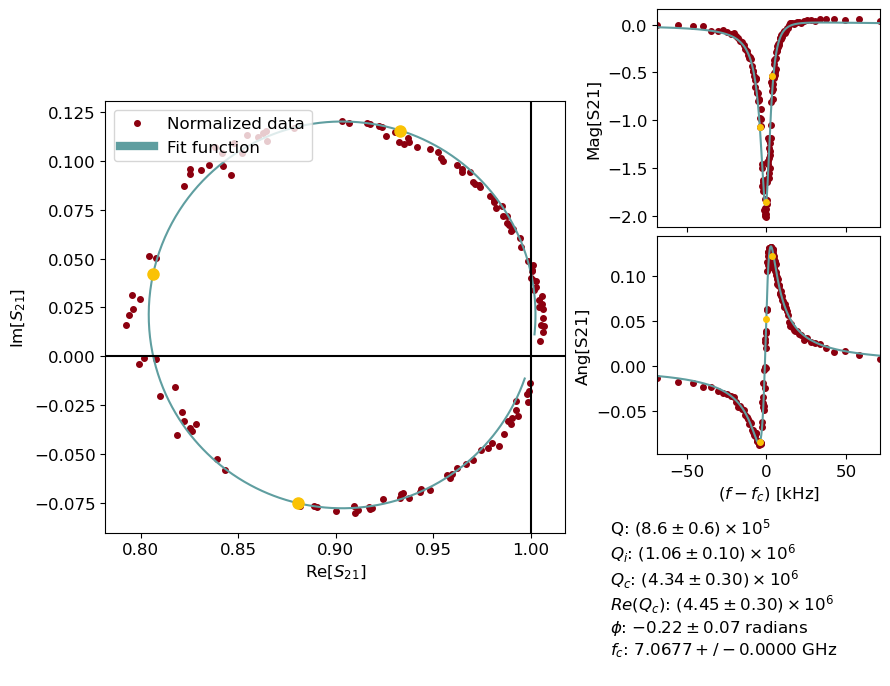

0.9171322872172881
0.10794443276739846


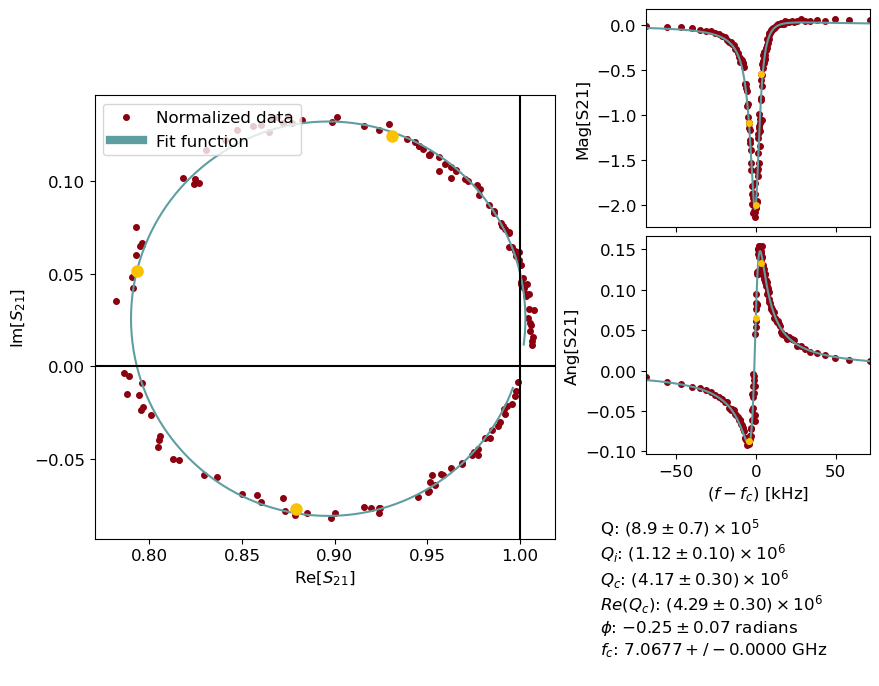

1.3303017177356222
0.1156892013955323


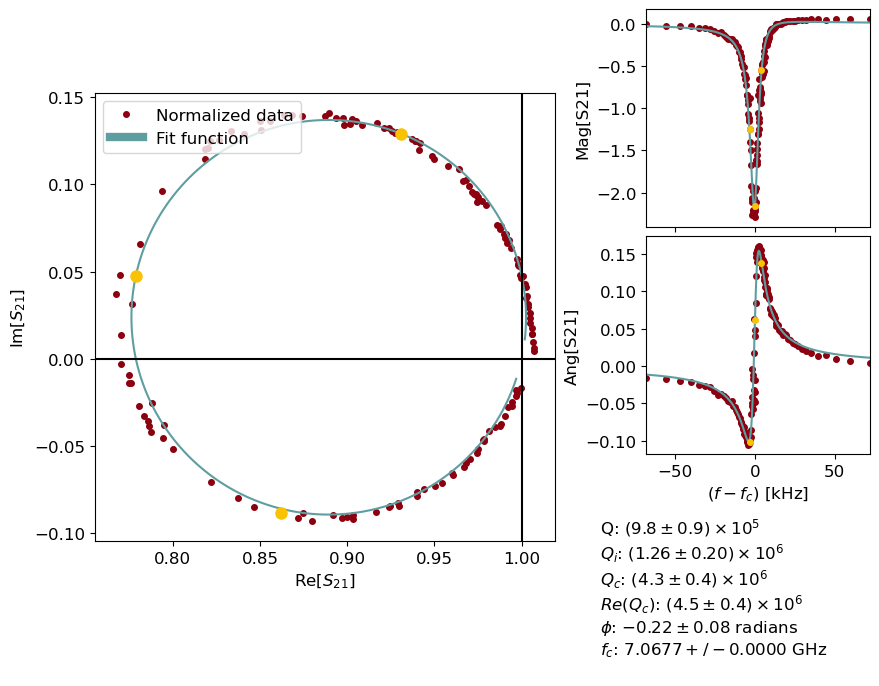

1.9265747180736934
0.12002243973850686


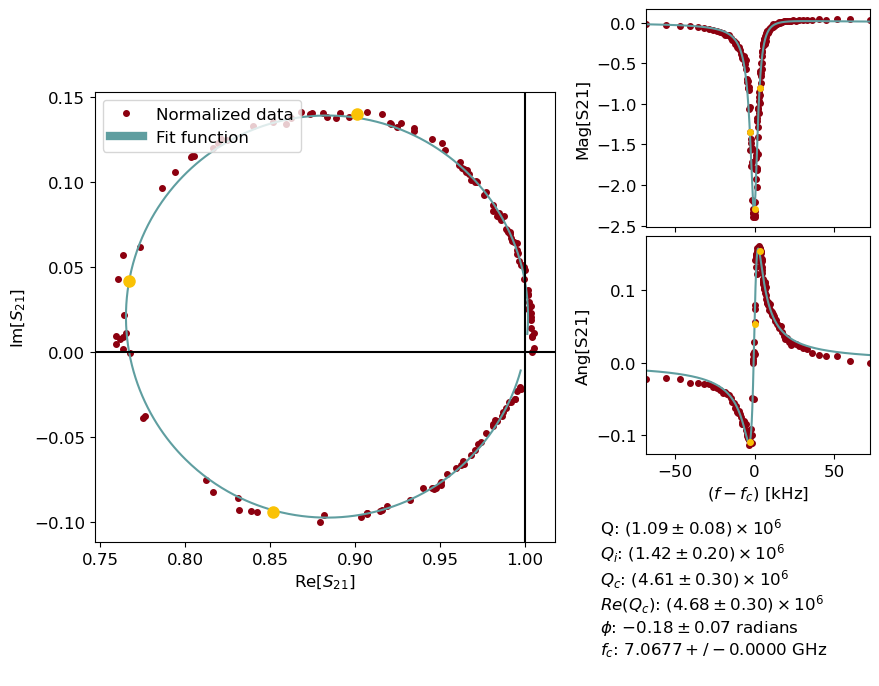

Time elapsed:  49.03106665611267
['res_7475_24', 'res_7475_21', 'res_7475_18', 'res_7475_15', 'res_7475_12', 'res_7475_9', 'res_7475_6', 'res_7475_3', 'res_7475_0']
0.09009854092897986
0.07441018265321277


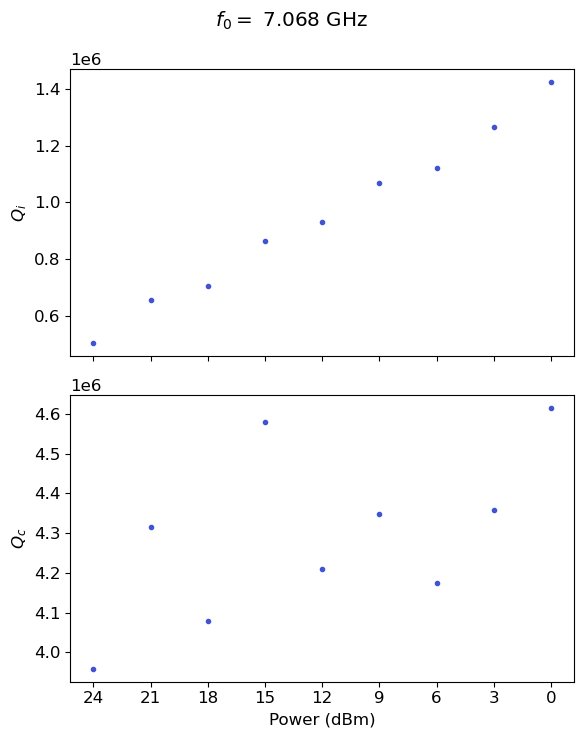

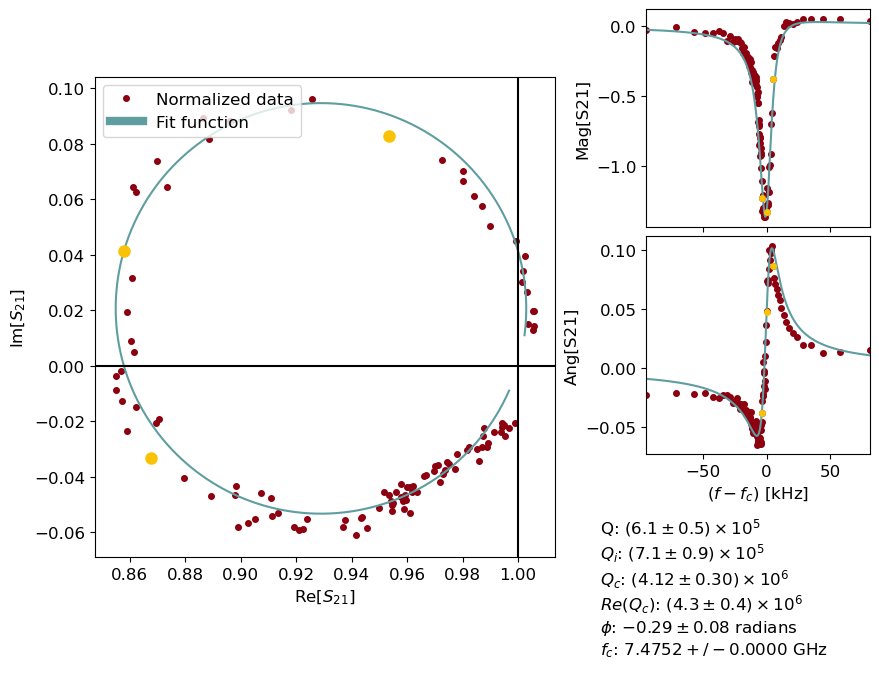

0.14893624286509022
0.08871059352279591


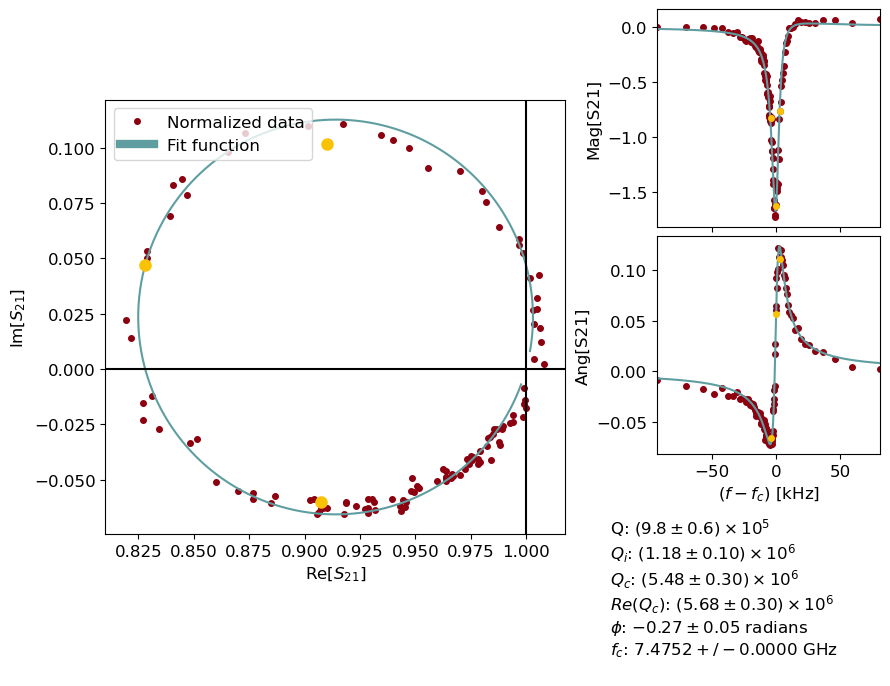

0.23265972603319152
0.1000779575629015


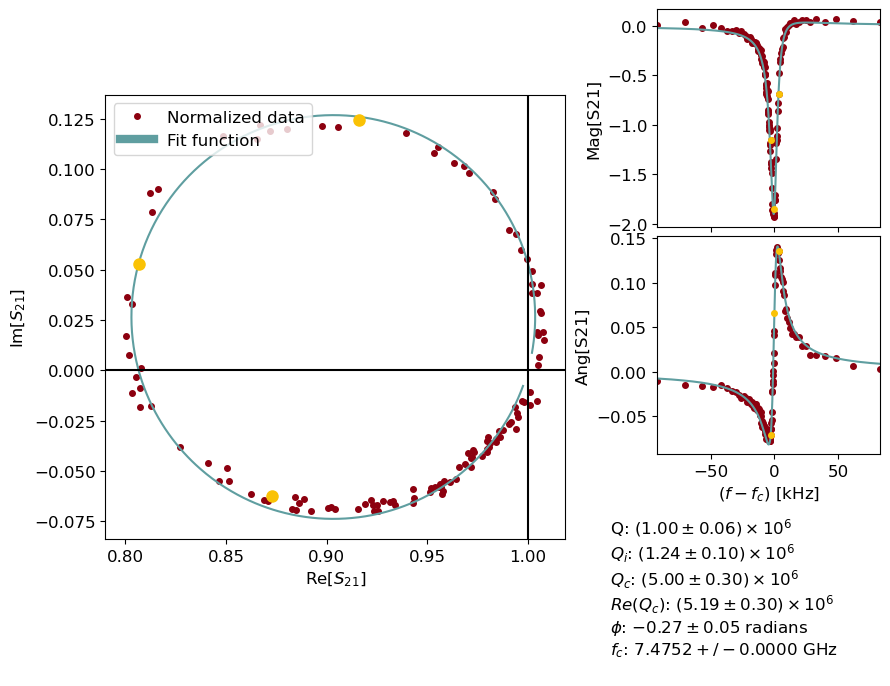

0.3392060556184016
0.10423033349345844


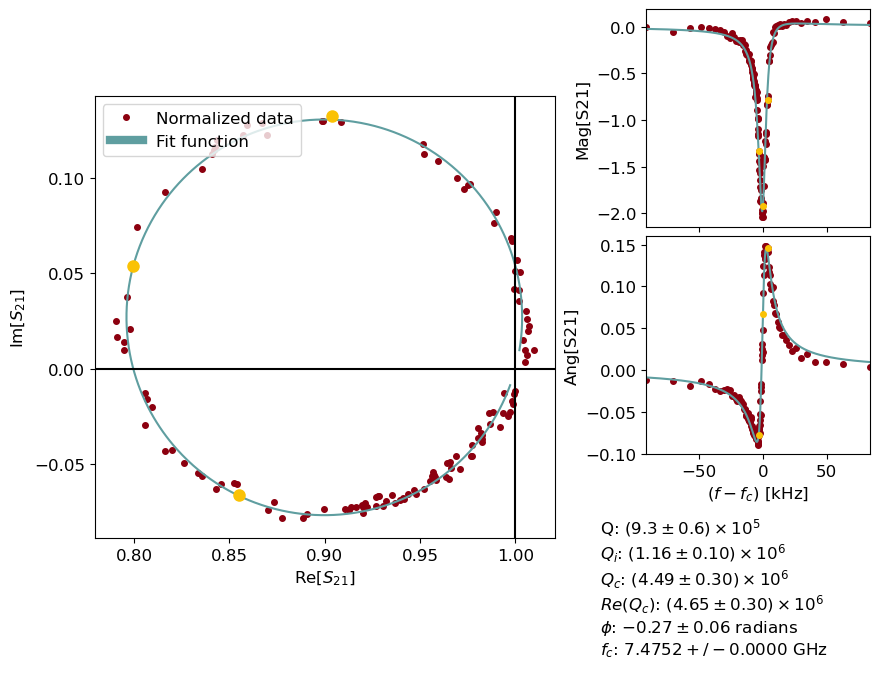

0.5135689036737952
0.11220822085681201


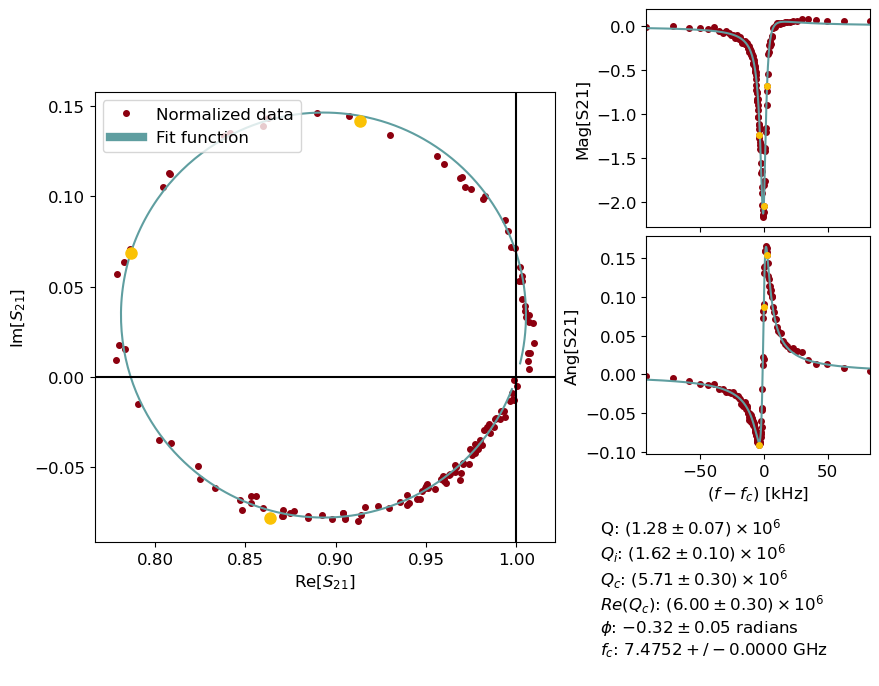

0.7322858294092295
0.11606275396189267


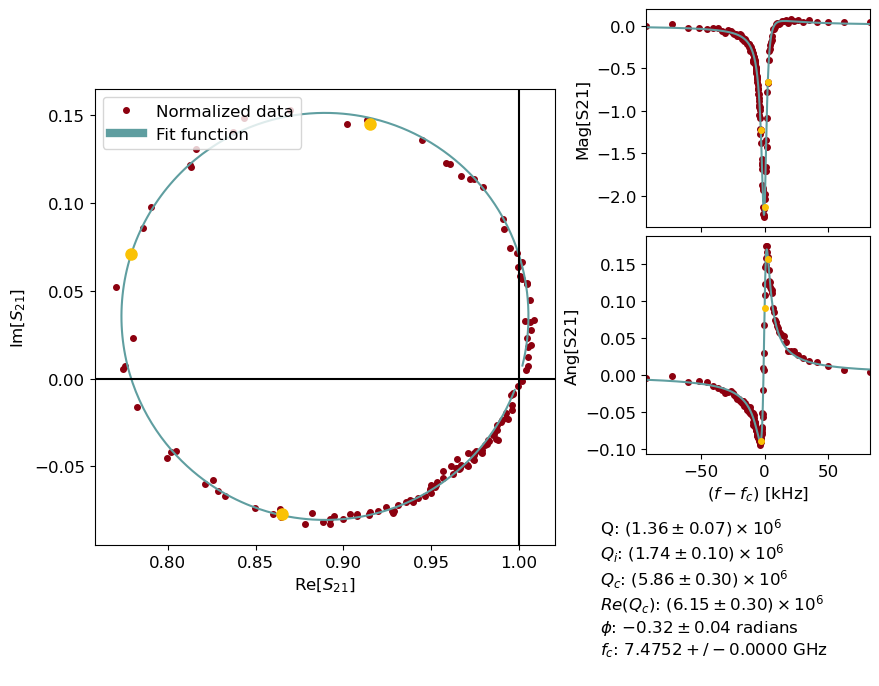

1.0104688759245597
0.11863131605618418


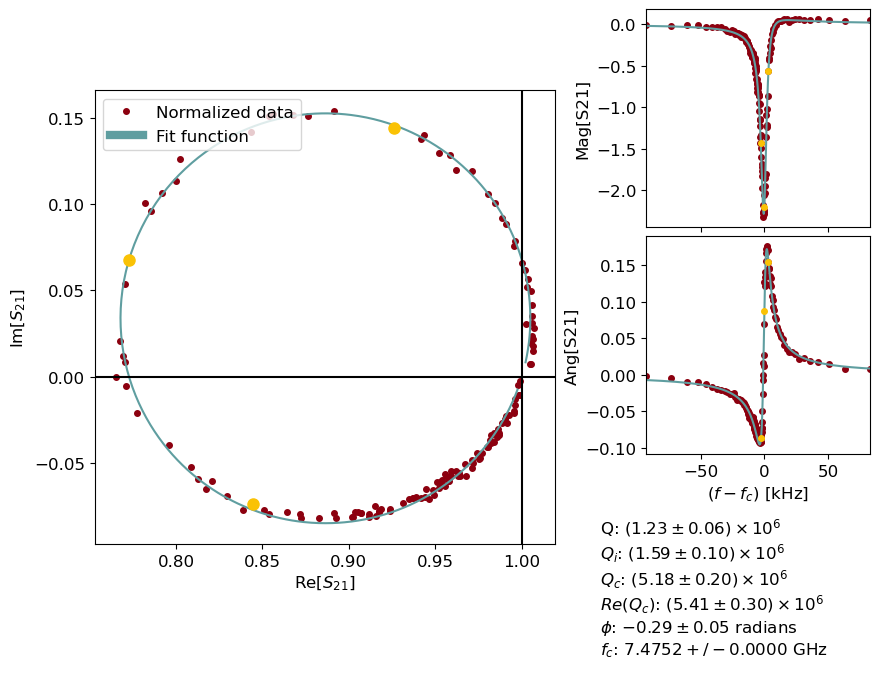

1.460639436019638
0.1269953843020587


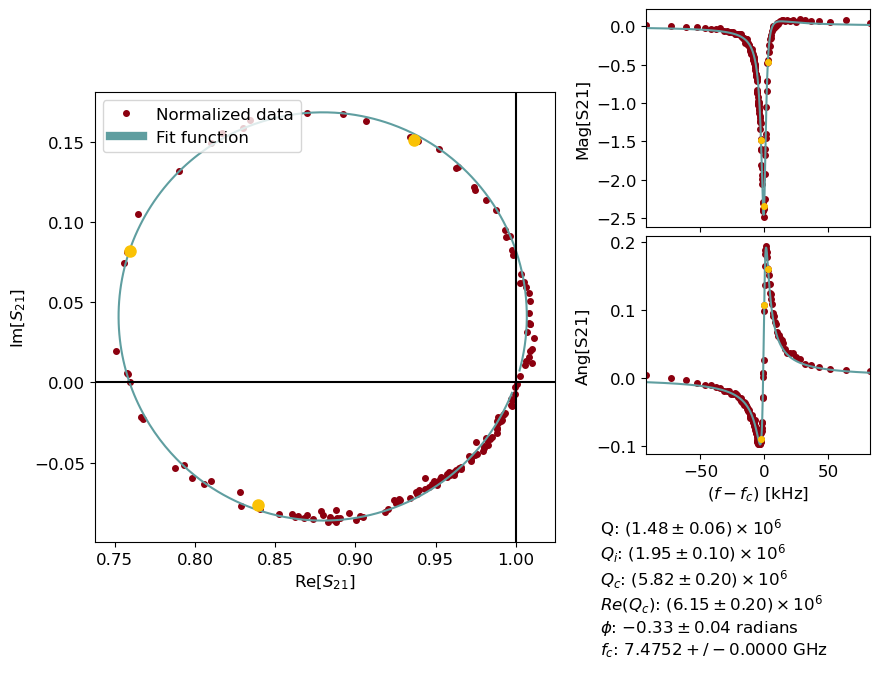

2.1369628984871674
0.13228411447792332


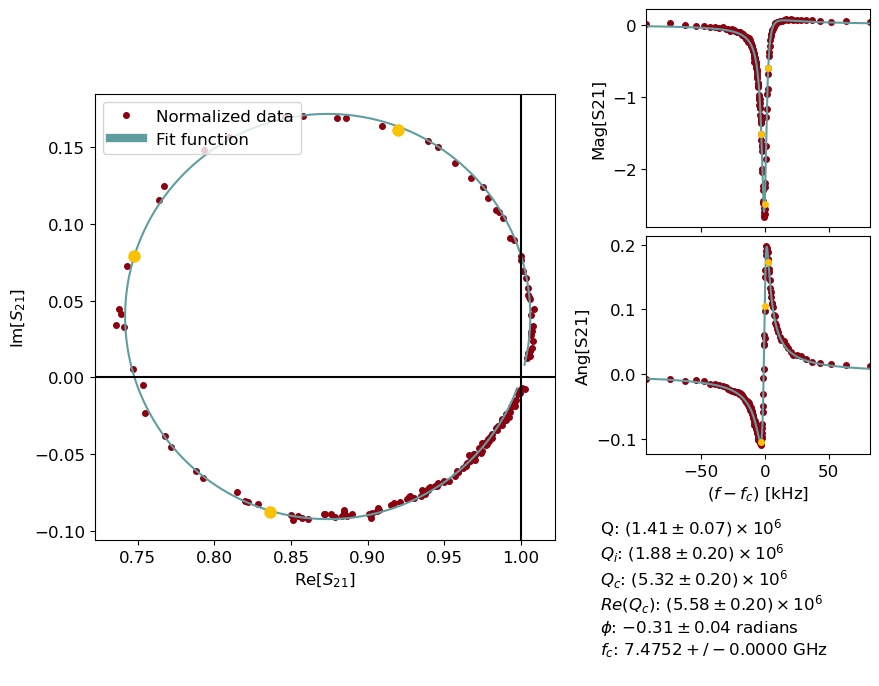

Time elapsed:  57.93455791473389
['res_7988_24', 'res_7988_21', 'res_7988_18', 'res_7988_15', 'res_7988_12', 'res_7988_9', 'res_7988_6', 'res_7988_3', 'res_7988_0']
0.0639303975547533
0.16492814968540861


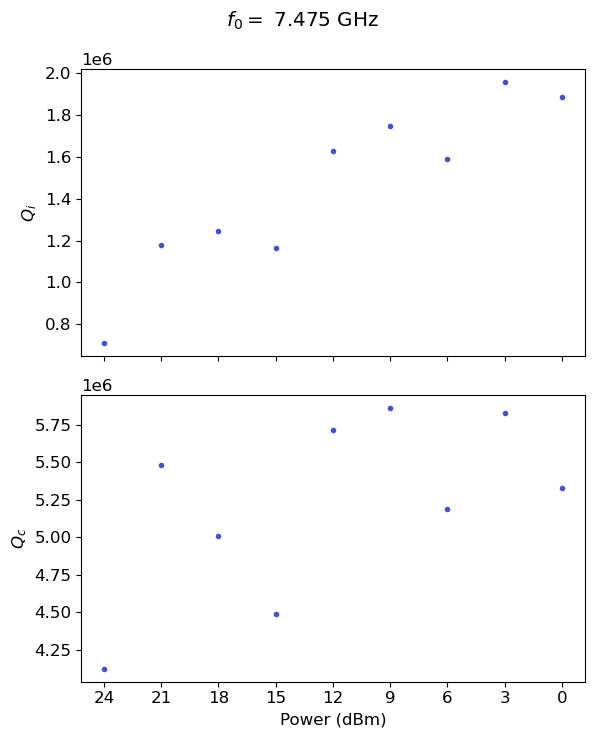

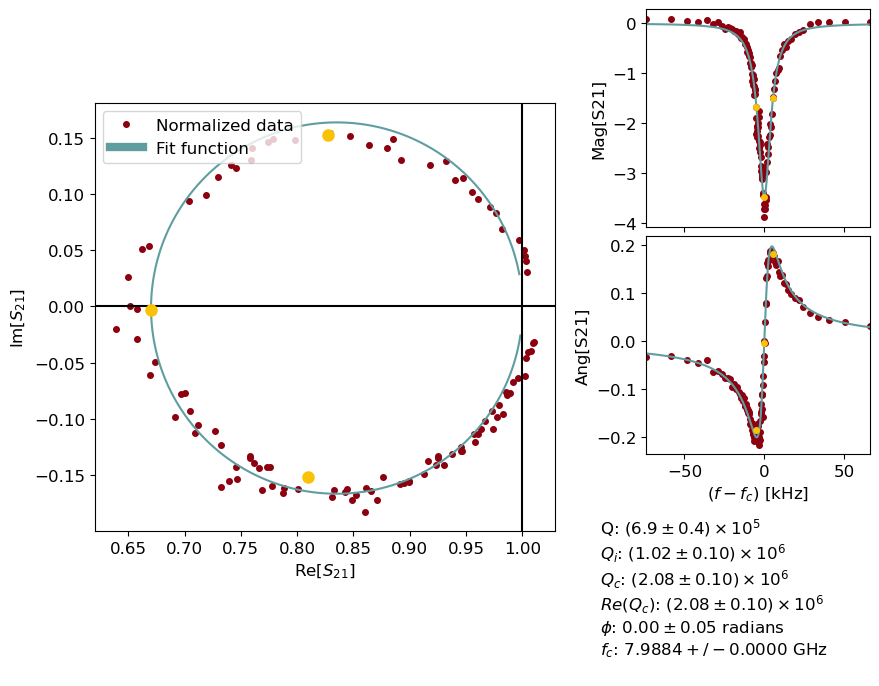

0.09403767060496561
0.17712092479214875


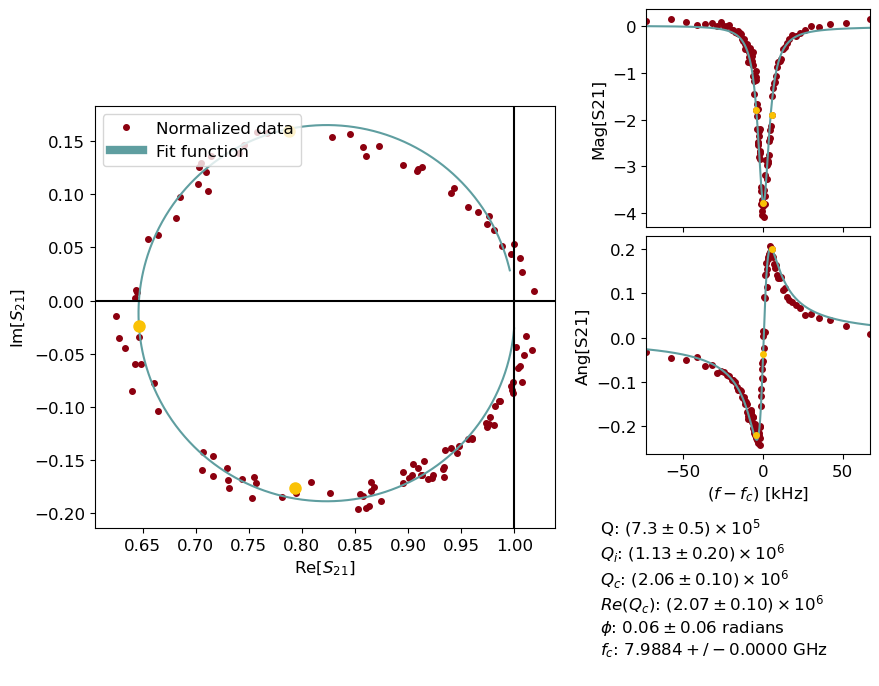

0.1493820467446895
0.20577869259124654


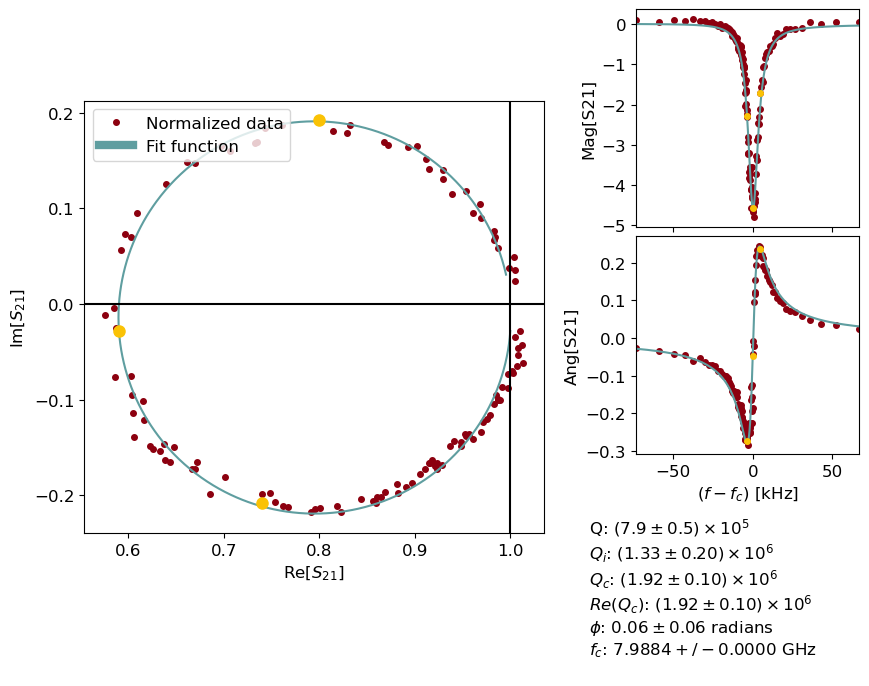

0.22488283592522668
0.22479998376677415


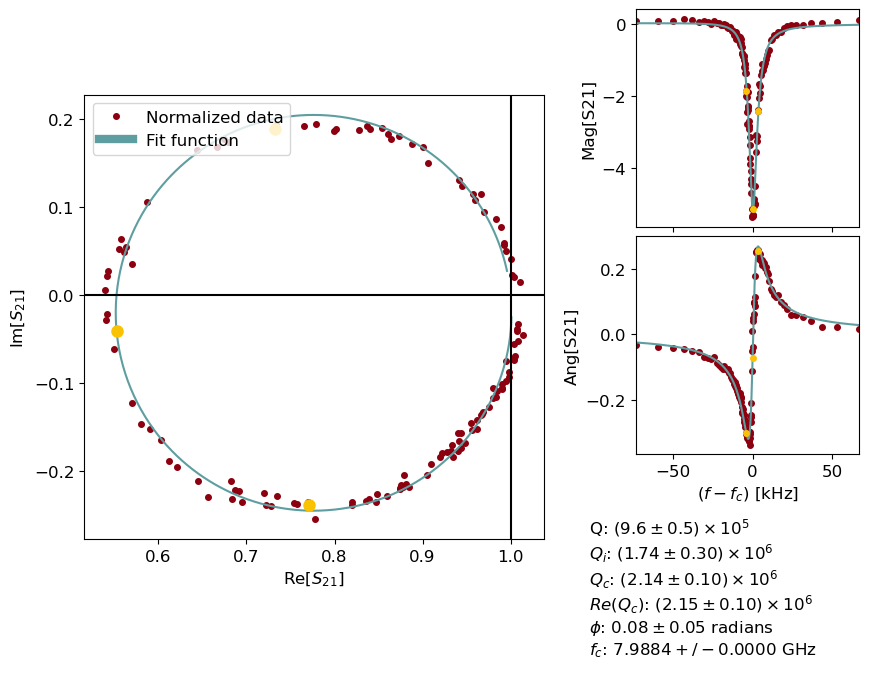

0.32844585596809855
0.23647419405616102


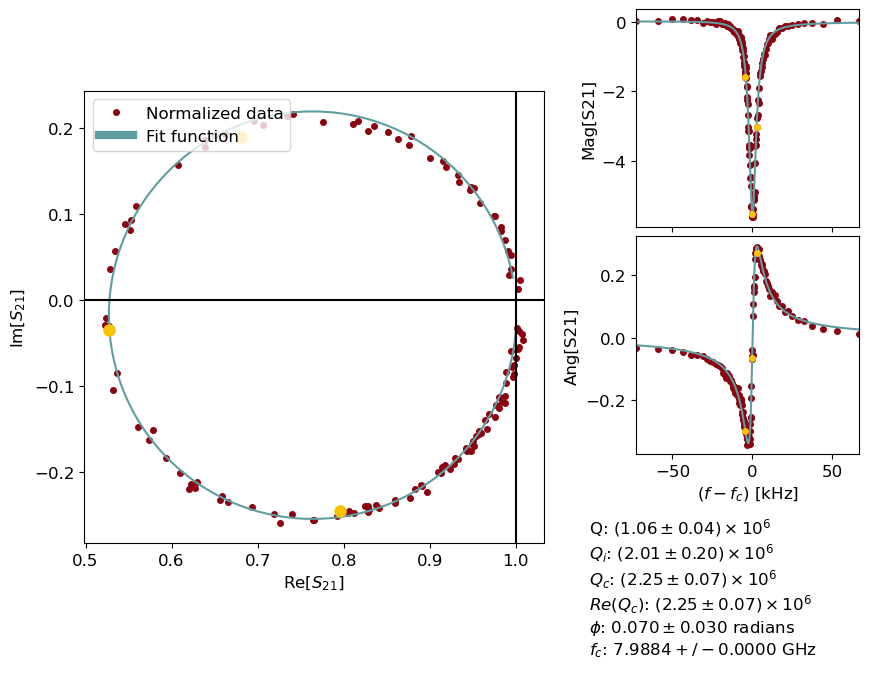

0.4720580613476885
0.2492922330881526


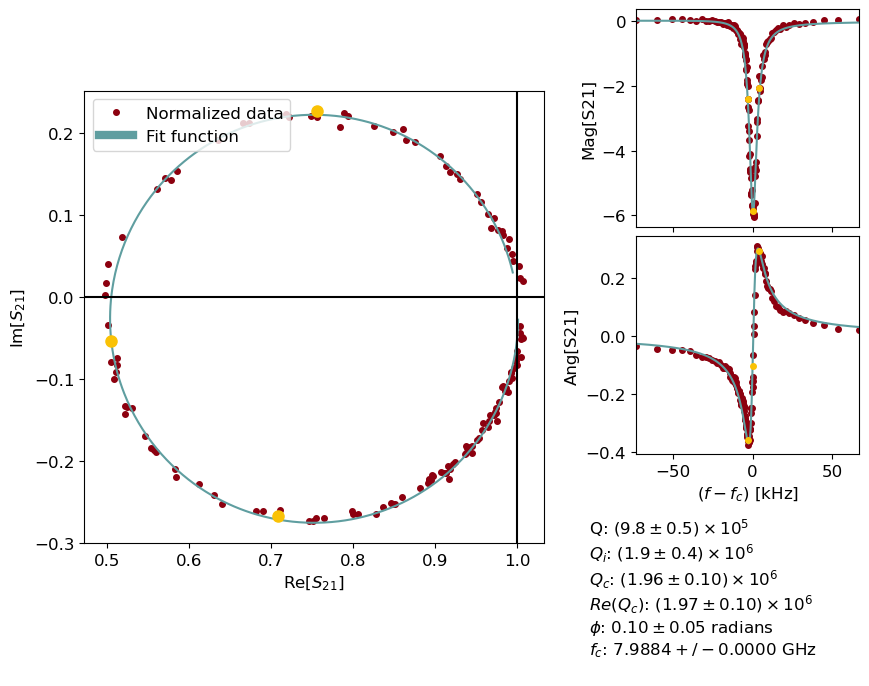

0.6597243796650194
0.2590529380058731


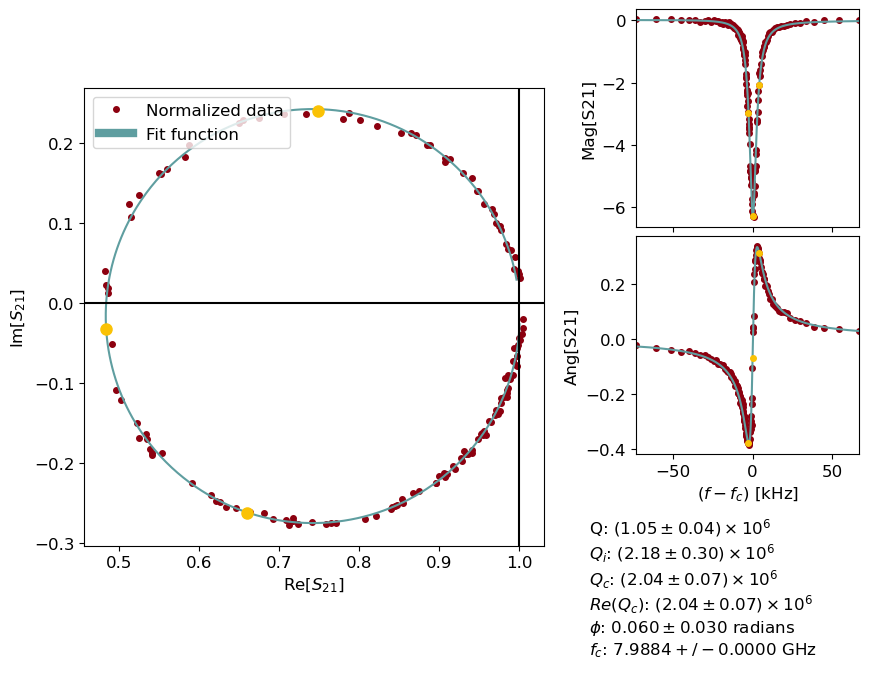

0.909877813056484
0.26560786970504174


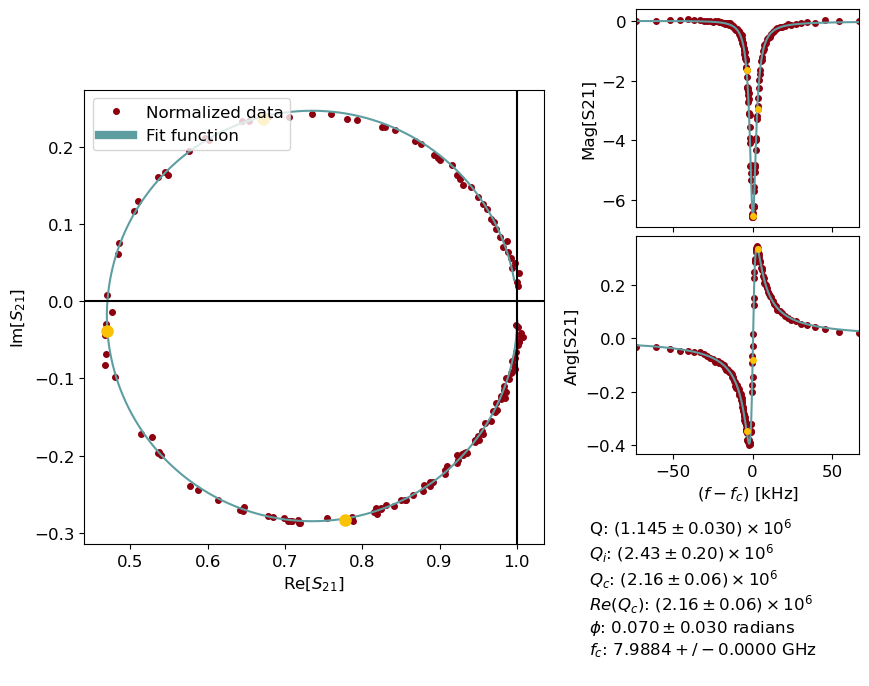

1.3150218946161223
0.27354943474598803


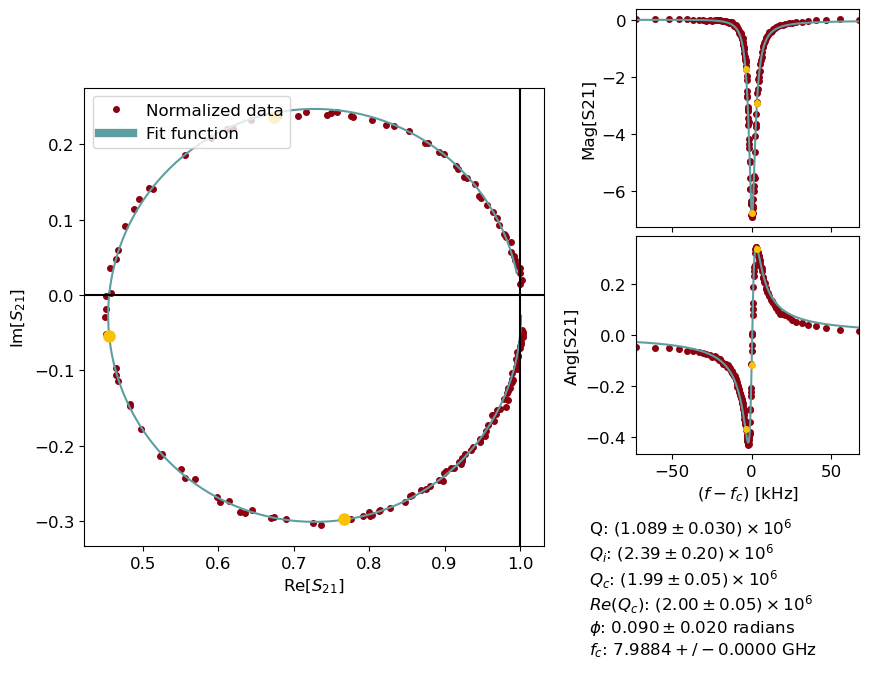

Time elapsed:  66.02712392807007


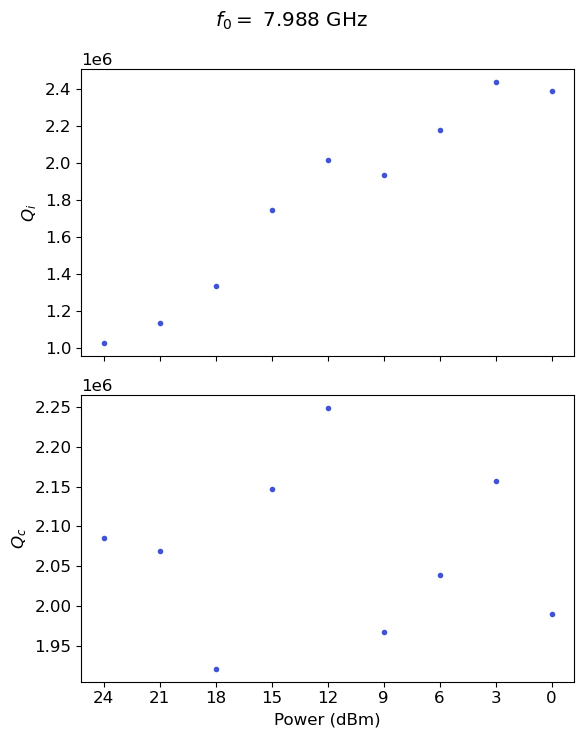

In [435]:
nfiles=1
meas_type='vna'
if params['res_name']=='240725':
    directories = ['power_sweep7']
    res_params = ana_res.analyze_sweep_double(directories, data_pth)
    nfiles = 2
elif params['res_name']=='240719':
    params['min_power']=-85
    directories = ['sample1_power_sweep_2']
    res_param = ana_res.analyze_sweep(directories, data_pth)
    nfiles = 1
elif params['res_name']=='240729':
    directories = ['power_sweep2']
    params['max_power'] = -30
    res_params = ana_res.analyze_sweep_double(directories, data_pth,img_pth=img_pth+'Images/')    
    nfiles = 2
elif params['res_name']=='240729-2':
    directories = ['power_sweep5']
    # there is an issue with power sweep 5 for the 6 um data 
    res_params = ana_res.analyze_sweep_triple(directories, data_pth, img_pth=img_pth+'Images/',name=params['res_name'], plot=False)
elif params['res_name']=='240729-3':
    directories = ['power_sweep4']
    # there is an issue with power sweep 5 for the 6 um data 
    res_params = ana_res.analyze_sweep_triple(directories, data_pth, img_pth=img_pth+'Images/',name=params['res_name'], plot=True)
elif params['res_name']=='240814-2':
    directories = ['powersweep7']
    res_params = ana_res.analyze_sweep_triple(directories, data_pth, img_pth=img_pth+'Images/', name=params['res_name'], plot=False)
    #res_params = ana_res.analyze_sweep(directories, pth, name=params['res_name'], plot=True)
elif params['res_name']=='240729-5':
    meas_type='soc'
    #slope = 23.45293930972242
    slope = 23.9
    directories=['powersweep0']
    res_params = ana_res.analyze_sweep_triple(directories, data_pth, name='rfsoc', img_pth=img_pth+'Images/', plot=True, type=meas_type, slope=slope)
elif params['res_name']=='240729-6':
    meas_type='soc'
    #slope = 23.45293930972242
    slope = 23.9
    directories=['powersweep3']
    res_params = ana_res.analyze_sweep_triple(directories, data_pth, name='rfsoc', img_pth=img_pth+'Images/', plot=True, type=meas_type, slope=slope)
elif params['res_name']=='silicon-scalinq-1':
    directories=['powersweep3']
    nfiles =3
    res_params = ana_res.analyze_sweep_gen(directories, data_pth, name=params['res_name'], img_pth=img_pth, plot=True, nfiles=nfiles)
elif params['res_name']=='241028':
    meas_type='soc'
    directories=['powersweep10']
    nfiles =1

    res_params = analyze_sweep_mux(directories, data_pth,img_pth, name=params['res_name'], plot=True, slope=28.45) # slope=28.45)
else:
    print('Sample not found')

Counter({5982: 9, 6680: 9, 6992: 9, 7475: 9, 7067: 9, 7988: 9, 6321: 9, 6692: 9})
res_5982_0
dict_keys(['amps', 'phases', 'xpts', 'lin', 'freqs'])
[6.1762011604 6.1612408838 6.1392451015 6.1253381275 6.1091939266
 6.0927843239 6.0777166624 6.0609791581 6.0482675333 6.0330025582
 6.0127479914 5.998975174  5.9786381388 5.9662850206 5.9562624405
 5.9445160005 5.9265498577 5.9222530614 5.8994282866 5.8939873314
 5.8696355145 5.8602814887 5.8536292828 5.8354272239 5.8251545632
 5.7964673692 5.7952813685 5.7856228833 5.7650820294 5.7472513225
 5.7303696381 5.7304529289 5.7115508145 5.6861890348 5.6761604988
 5.6688926459 5.6581562713 5.6262413817 5.6235354686 5.6111968317
 5.5855374327 5.5626565913 5.5534876419 5.5573917733 5.5222832618
 5.5244330082 5.5019951471 5.4711757569 5.3980351572 5.3977202731
 5.4023326435 5.395200098  5.3663086858 5.3641357979 5.3509485233
 5.3209289349 5.3075808633 5.2524162134 5.26968353   5.2502154021
 5.2665634299 5.2446970656 5.2453100653 5.169925679  5.159820

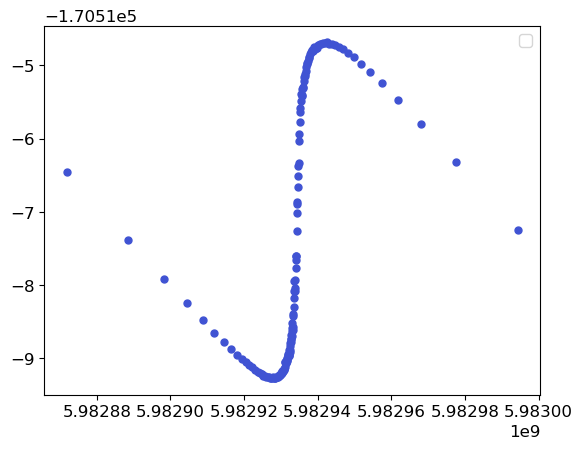

In [436]:
resonators, file_list = ana_res.get_resonators('powersweep10',data_pth,  r'res_(\d+)')

pth = data_pth + directories[0]
index = 0
print(file_list[index])
data, attrs = ana_res.grab_data(pth, file_list[index], meas_type='soc', slope=28.45)
data_, attrs_ = hy.prev_data(pth, file_list[index])
print(data.keys())
print(data['phases'])
print(file_list[index])
print(data_['phases'])
plt.plot(data['freqs'], -np.unwrap(data_['phases'][0]) - 28.5 * data_['xpts'][0],'.')
#plt.plot(data['freqs'], data_['phases'][0]  , '.')
# plt.plot(data['freqs'], data_['amps'][0] * np.sin(data_['phases'][0])  , '.', label = 'Q')
# plt.plot(data['freqs'], data_['amps'][0] * np.cos(data_['phases'][0])  , '.', label = 'I')
# get the slope correction
print(np.unwrap(data_['phases'][0]))
slope_ = (np.unwrap(data_['phases'][0])[5] - np.unwrap(data_['phases'][0])[0]) / (data_['xpts'][0][5] - data_['xpts'][0][0]) 
print(slope_)
plt.legend()

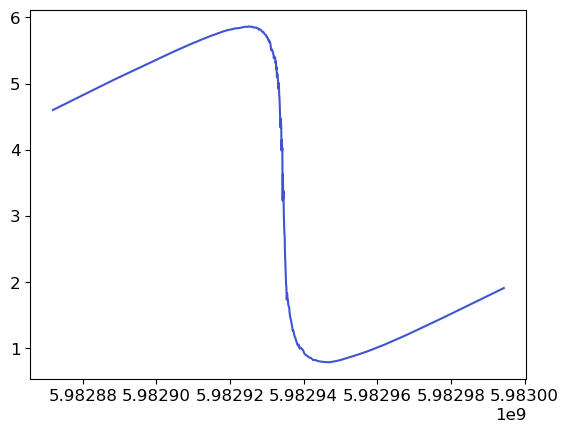

In [437]:
plt.plot(data['freqs'], np.unwrap(data_['phases'][0]))

In [439]:
# get average frequency
np.set_printoptions(precision=10)
freq_list = np.zeros(8)
for i in range(8):
    freq_list[i] = np.average(res_params[i]['freqs'][0])
print(freq_list)

[5.9829358459e+09 6.3210416665e+09 6.6800239836e+09 6.6920368935e+09
 6.9927348904e+09 7.0676940767e+09 7.4751545666e+09 7.9883904278e+09]


In [440]:
import scresonators.fit_resonator.fit as scfit
def plot_all(directories, pth_base,  output_path, name='res',min_power=-120, max_power =-25, norm=False,nfiles=3, meas_type='vna', slope=0):
    if nfiles==3:
        if meas_type=='vna': 
            pattern_end = 'dbm_'
            ends = ['wide1', 'narrow', 'wide2']
        else:
            pattern_end = '_'
            ends = ['wideleft', 'narrow','wideright']
        pattern0 = r'res_(\d+)_\d{2,5}' + pattern_end + ends[0]
    elif nfiles==2:
        pattern0 = r'res_(\d+)_\d{2,3}dbm_wide'
    else:
        pattern0 = r'res_(\d+)'

    # Initialize dict by getting list of resonators, creating dict with len = n resonators
    resonators, file_list = ana_res.get_resonators(directories[0],pth_base, pattern0)
    nres = len(resonators)
    
    sns.set_palette('coolwarm', n_colors=int(np.ceil(len(file_list)/nres)))
    fig, ax = plt.subplots(2,4, figsize=(10, 7))
    fig2, ax2 = plt.subplots(2,4, figsize=(10, 7))
    ax=ax.flatten(); ax2=ax2.flatten()

    # Each directory is a temperature 
    for i in range(len(directories)):         
        
        resonators, file_list0 = ana_res.get_resonators(directories[i], pth_base, pattern0)
        pth = pth_base + directories[i]
        for j in range(len(resonators)): 
            # Grab all the files for a given resonator, then sort by power. 
            if nfiles ==3:                
                pattern = 'res_{:d}_'.format(resonators[j]) + '(\d{2,5})'+pattern_end+ends[0]
            elif nfiles==2: 
                pattern = 'res_{:d}_'.format(resonators[j]) + '(\d{2,3})dbm_wide'
            else:
                pattern = 'res_{:d}_'.format(resonators[j]) + r'(\d+)'
            file_list = ana_res.get_resonator_power_list(pattern, file_list0)
 
            for k in range(len(file_list)):                
                # try: 
                if nfiles==3:
                    data1, attrs = ana_res.grab_data(pth, file_list[k], meas_type, slope)
                    file2 = file_list[k].replace(ends[0], ends[1])
                    data2, _ = ana_res.grab_data(pth, file2, meas_type, slope)
                    data = ana_res.combine_data(data1, data2)
                    file3 = file_list[k].replace(ends[0], ends[2])                
                    data3, _ = ana_res.grab_data(pth, file3, meas_type, slope)
                    data = ana_res.combine_data(data, data3) 
                    #print('checked')
                elif nfiles==2: 
                    data1 = ana_res.grab_data(pth, file_list[k])
                    file2 = file_list[k].replace('wide', 'narrow')
                    data2 = ana_res.grab_data(pth, file2)
                    data = ana_res.combine_data(data1, data2)
                    #print('checked')
                else:
                    data, attrs = ana_res.grab_data(pth, file_list[k],  meas_type='soc', slope=slope)
                    #print('checked')
                # except:
                #     continue
                if meas_type=='vna' :
                    if data1['vna_power'][0]>max_power or data1['vna_power'][0]<min_power: 
                        continue
                #print(np.max(data1['freqs'])-np.min(data2['freqs']))
                #print(np.max(data2['freqs'])-np.min(data3['freqs']))
                
                if norm: 
                    x = 10**(data['amps']/20)*np.cos(data['phases'])
                    y = 10**(data['amps']/20)*np.sin(data['phases'])
                    #z = scfit.preprocess_linear(x, y, normalize=5, output_path='hi', plot_extra=False)
                    z = scfit.preprocess_circle(data['freqs'], x+1j*y, output_path='hi', plot_extra=False)
                    ax[j].plot((data['freqs']-np.mean(data['freqs']))/1e3, np.log10(np.abs(z)) * 20, linewidth=1)
                    ax2[j].plot((data['freqs']-np.mean(data['freqs']))/1e3, np.angle(z), linewidth=1)
                else:
                    ax[j].plot((data['freqs']-np.mean(data['freqs']))/1e3, data['amps'], linewidth=1)
                    ax2[j].plot((data['freqs']-np.mean(data['freqs']))/1e3, data['phases'], linewidth=1)

            #print(np.max(data1['freqs'])-np.min(data1['freqs']))
            #print(np.min(data2['freqs'])-np.min(data1['freqs']), np.max(data1['freqs'])-np.min(data2['freqs']))
            #print(np.min(data3['freqs'])-np.min(data2['freqs']), np.max(data2['freqs'])-np.min(data3['freqs']))
            fig.tight_layout()
            fig2.tight_layout()
            fig2.savefig(output_path +name+'_' + directories[i] + '_all_data_phase.png', dpi=300)                 
            fig.savefig(output_path +name+'_' + directories[i] + '_all_data_amp.png', dpi=300)    

Counter({5982: 9, 6680: 9, 6992: 9, 7475: 9, 7067: 9, 7988: 9, 6321: 9, 6692: 9})
Counter({5982: 9, 6680: 9, 6992: 9, 7475: 9, 7067: 9, 7988: 9, 6321: 9, 6692: 9})
['res_5982_24', 'res_5982_21', 'res_5982_18', 'res_5982_15', 'res_5982_12', 'res_5982_9', 'res_5982_6', 'res_5982_3', 'res_5982_0']
0.7175931920553605
0.35958359299722265
1.078562629017123
0.39700632856933726
1.5860673916190076
0.4336194163586626
2.3453147920064996
0.47277138389759804
3.455835229054237
0.508003605279273
4.92948701185017
0.5380850531092498
6.841218823823755
0.5550808364898369
9.55381720969113
0.5617368903765763
13.779925694622941
0.5716526787495428
['res_6321_24', 'res_6321_21', 'res_6321_18', 'res_6321_15', 'res_6321_12', 'res_6321_9', 'res_6321_6', 'res_6321_3', 'res_6321_0']
0.31402448733787564
0.11175101491272157
0.4726239309028986
0.12103919931085154
0.6922411672131665
0.12653401328458164
1.0241180898437752
0.1327067473180879
1.5850653636778125
0.14412115345119436
2.322441099850062
0.15058785197687158
3.

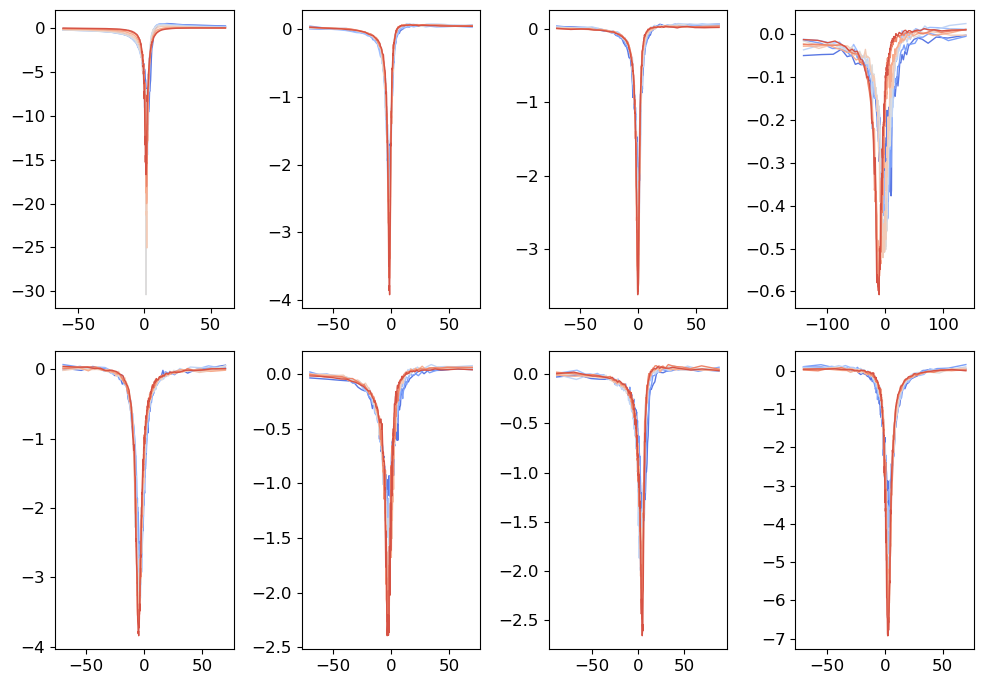

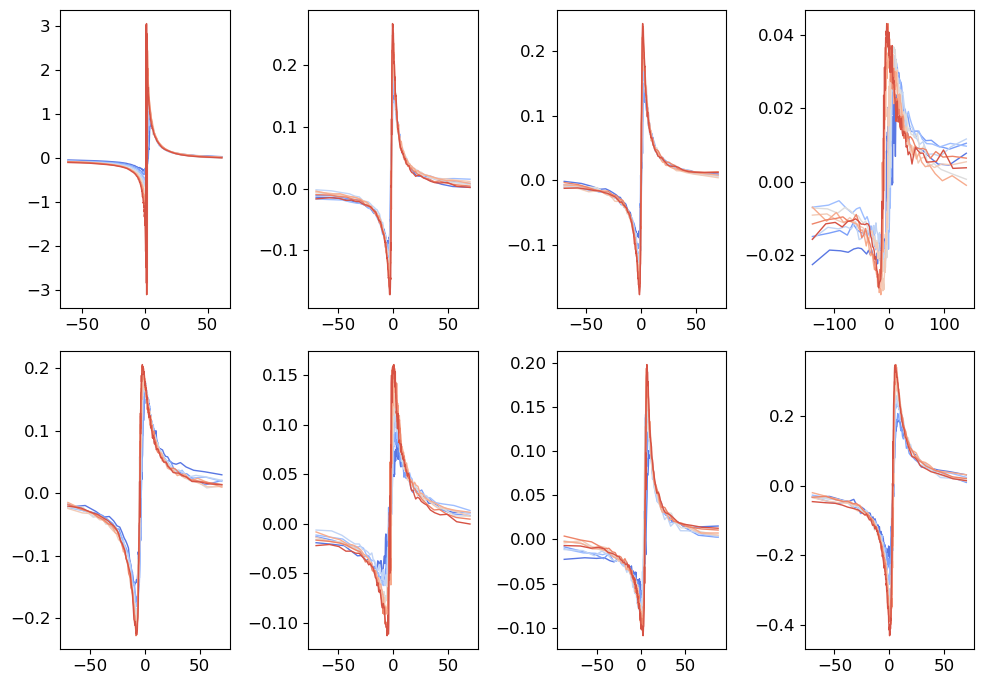

In [441]:
#slope = 0
#%matplotlib widget
plot_all(directories, data_pth, output_path=img_pth, max_power=-15, norm=True, nfiles=1, meas_type=meas_type, slope=28.45)

#### Reorder the data based on pitch (only run once)

In [442]:

# if meas_type=='soc':
#     res_params = ana_res.convert_power(res_params) 

params, res_params=ana_res.reorder(params, res_params) # only run once!
params['qc'] = np.array([np.nanmedian(res_params[i]['qc']) for i in range(len(res_params))])
params['qc_err'] = np.array([np.nanmedian(res_params[i]['qc_err']) for i in range(len(res_params))])
params['freqs'] = np.array([np.nanmedian(res_params[i]['freqs']) for i in range(len(res_params))])
params['phs'] = np.array([np.nanmedian(res_params[i]['phs']) for i in range(len(res_params))])

In [443]:
res_params[7]['freqs'][0][0]

6692036005.844839

### Power sweep and TLS fits

UFuncTypeError: ufunc 'greater_equal' did not contain a loop with signature matching types (<class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.Int32DType'>) -> <class 'numpy.dtypes.BoolDType'>

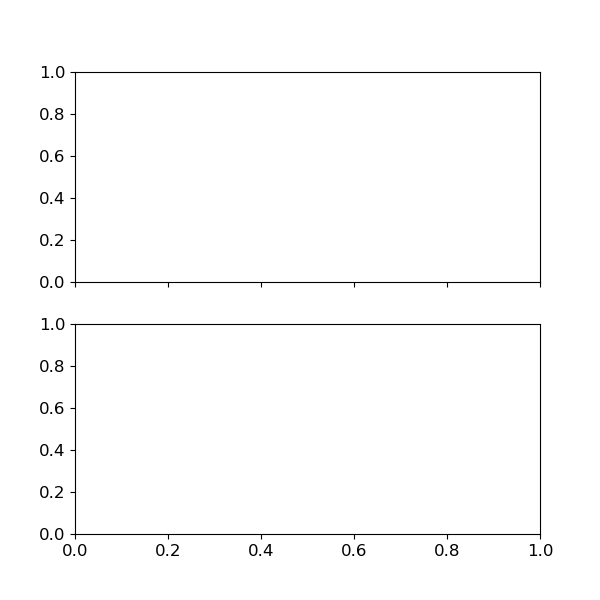

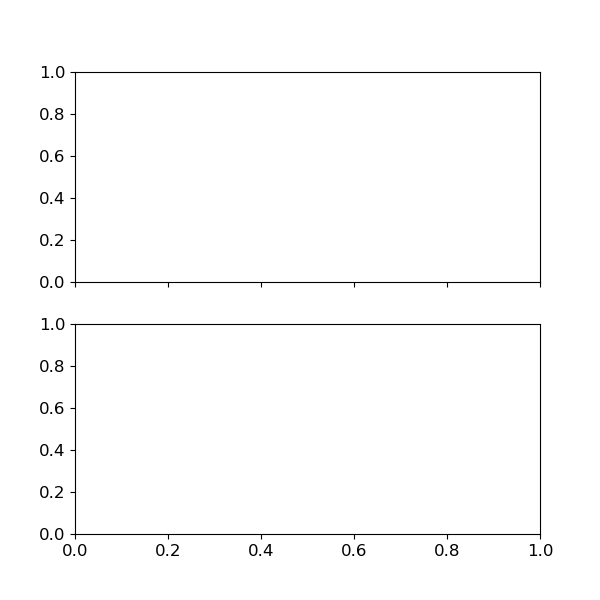

In [73]:
%matplotlib widget
ana_res.plot_power(res_params, params, img_pth, use_pitch=True)
cfg = ana_tls.fit_qi(res_params, params, img_pth) 
ana_tls.plot_res_pars([params], [''],img_pth)
ana_res.plot_res_pars([params], [''], img_pth)
hy.save_np(params, img_pth+'Text/' + params['res_name'] + '.yml')


In [ ]:

# soc_res_params = np.load(img_pth + 'other_files/soc_power_sweep.npy', allow_pickle=True)
# soc_res_params = np.load(img_pth + 'other_files/soc_power_sweep.npy', allow_pickle=True)
# np.save(img_pth + 'other_files/soc_power_sweep' , np.array(res_params))
#np.save(img_pth + 'other_files/vna_power_sweep' , np.array(res_params))
#print(np.array(res_params)[0]['qi'])

{'freqs': array([[6.7232e+09, 6.7232e+09, 6.7232e+09, 6.7232e+09, 6.7232e+09,
        6.7232e+09, 6.7232e+09, 6.7232e+09, 6.7232e+09, 6.7232e+09,
        6.7232e+09, 6.7232e+09, 6.7232e+09, 6.7232e+09, 6.7232e+09]]), 'phs': array([[0.174 , 0.1693, 0.1717, 0.1699, 0.1712, 0.172 , 0.1712, 0.1703,
        0.1726, 0.1708, 0.1729, 0.1741, 0.1808, 0.1934, 0.1838]]), 'q': array([[147055.4032, 147941.5565, 148838.9539, 149041.7508, 150260.2178,
        150926.4534, 151715.4653, 152463.875 , 153654.7951, 154439.0214,
        155352.7195, 156441.2176, 157773.3577, 159514.3399, 169813.7906]]), 'qi': array([[276823.5986, 279670.4825, 281731.7588, 283638.788 , 287028.9817,
        289505.5675, 292129.9073, 295336.2016, 298967.9204, 302227.0443,
        305199.1269, 308262.54  , 311012.4038, 312986.2545, 325806.39  ]]), 'qc': array([[308963.9625, 309602.9491, 310898.4796, 309553.9472, 310734.2364,
        310648.7306, 311026.5253, 310605.3764, 311431.8111, 311230.484 ,
        311693.8016, 312841.83

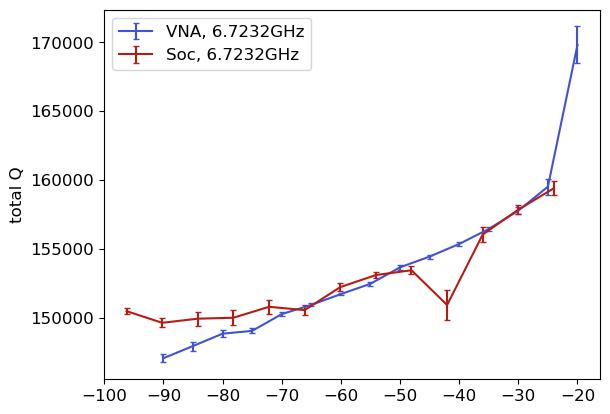

In [ ]:
# plot the vna and soc curves in the same plot
soc_res_params = np.load(img_pth + 'other_files/soc_power_sweep.npy', allow_pickle=True)
vna_res_params = np.load(img_pth + 'other_files/vna_power_sweep.npy', allow_pickle=True)

#print(vna_res_params)
print(vna_res_params[7])

%matplotlib inline
plt.errorbar(vna_res_params[7]['pow'][0], vna_res_params[7]['q'][0], yerr =  vna_res_params[7]['q_err'][0], capsize=2, label = 'VNA, 6.7232GHz')
plt.errorbar(soc_res_params[1]['pow'][0], soc_res_params[1]['q'][0], yerr =  soc_res_params[1]['q_err'][0], capsize=2, label = 'Soc, 6.7232GHz')
plt.ylabel('total Q')
plt.legend()
plt.show()

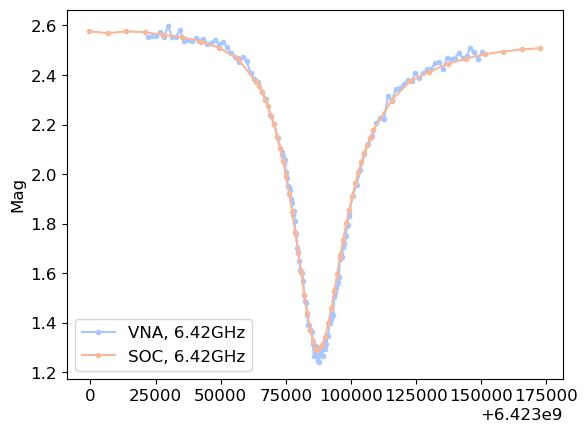

In [ ]:
# plot resonator data
vna_wide_1, _ = ana_res.grab_data('G:/My Drive/Projects/Materials/Data/240729/power_sweep4', fname = 'res_6423086_90dbm_wide1', meas_type='vna')
vna_wide_2, _ = ana_res.grab_data('G:/My Drive/Projects/Materials/Data/240729/power_sweep4', fname = 'res_6423086_90dbm_wide2', meas_type='vna')
vna_narrow, _ = ana_res.grab_data('G:/My Drive/Projects/Materials/Data/240729/power_sweep4', fname = 'res_6423086_90dbm_narrow', meas_type='vna')
vna_data = ana_res.combine_data( vna_narrow, ana_res.combine_data(vna_wide_1, vna_wide_2) )

slope_ = 23.9
soc_wide_1, _ =  ana_res.grab_data('G:/My Drive/Projects/Materials/Data/240818-Resonator/powersweep4', fname = 'res_6423_16_wideleft', meas_type='soc',slope = slope_)
soc_wide_2, _ =  ana_res.grab_data('G:/My Drive/Projects/Materials/Data/240818-Resonator/powersweep4', fname = 'res_6423_16_wideright', meas_type='soc',slope = slope_)
soc_narrow, _ =  ana_res.grab_data('G:/My Drive/Projects/Materials/Data/240818-Resonator/powersweep4', fname = 'res_6423_16_narrow', meas_type='soc',slope = slope_)
soc_data = ana_res.combine_data( soc_narrow, ana_res.combine_data(soc_wide_1, soc_wide_2) )

plt.plot(vna_data['freqs'], vna_data['amps'] - np.min(vna_data['amps']) + np.min(soc_data['amps'])-0.05, label = 'VNA, 6.42GHz', marker = '.' )
plt.plot(soc_data['freqs']-4000, soc_data['amps'], label = 'SOC, 6.42GHz', marker = '.' )
plt.ylabel('Mag')
plt.legend()

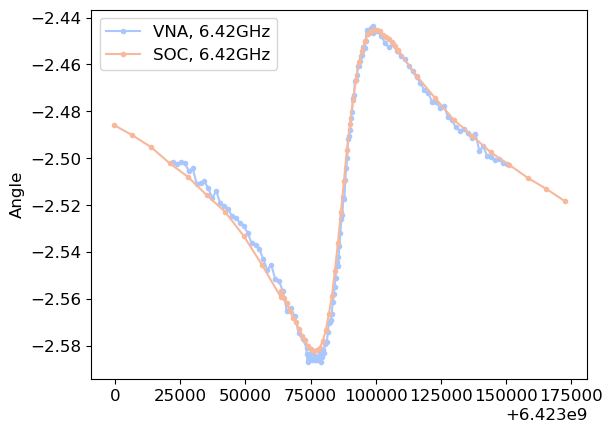

In [ ]:
plt.plot(vna_data['freqs'], vna_data['phases']-0.005, label = 'VNA, 6.42GHz', marker = '.' )
# plt.plot(soc_data['freqs']-4000, soc_data['phases']+160000-2322.3, label = 'SOC, 6.72GHz', marker = '.' )
plt.plot(soc_data['freqs']-4000, soc_data['phases']+(np.min(vna_data['phases']) - np.min(soc_data['phases'])), label = 'SOC, 6.42GHz', marker = '.' )
plt.ylabel('Angle')
plt.legend()

In [ ]:
print(vna_data.keys())

dict_keys(['freqs', 'amps', 'phases'])


### Plot with different max and min power for each resonator 

In [491]:
def plot_power(res_params, cfg, base_pth, use_pitch=True ): 
    min_power = cfg['min_power']
    max_power = cfg['max_power']
    
    sns.set_palette('coolwarm', len(res_params))
    plt.rcParams['lines.markersize'] = 4
    fig, ax = plt.subplots(2,1, figsize=(6,6), sharex=True) 
    fig2, ax2 = plt.subplots(2,1, figsize=(6,6), sharex=True) 
    for i in range(len(res_params)):    
        if use_pitch: 
            l = cfg['pitch'][i]
        else: 
            l = round(np.min(res_params[i]['freqs']/1e9),4)
        #inds = np.where((res_params[i]['pow'][0] >= cfg['min_power']) & (res_params[i]['pow'][0] <= cfg['max_power']))
        ax[0].semilogy(res_params[i]['pow'][0][inds], res_params[i]['qi'][0][inds], '.-', label=l) 
        ax[1].semilogy(res_params[i]['pow'][0][inds], res_params[i]['qi'][0][inds]/np.nanmax(res_params[i]['qi'][0]), '.-', label=l) 
        ax2[0].plot(res_params[i]['pow'][0][inds], 1e6*(res_params[i]['freqs'][0][inds]/np.nanmin(res_params[i]['freqs'][0][inds])-1), '.-', label=l) 
        ax2[1].plot(res_params[i]['pow'][0][inds], res_params[i]['qc'][0][inds]/np.nanmin(res_params[i]['qc'][0][inds]), '.-', label=l) 

    ax[1].set_xlabel('Power')
    ax[0].set_ylabel('$Q_i$')
    ax[1].set_ylabel('$Q_i/Q_{i,max}$')
    ax[1].legend(title='Gap', fontsize=8)

    ax2[1].set_xlabel('Power')
    ax2[0].set_ylabel('$\Delta f/f$ (ppm)')
    ax2[1].set_ylabel('$Q_c/Q_{c,min}$')
    
    fig2.tight_layout()
    fig2.savefig(base_pth +cfg['res_name']+  '_Qcfreq_pow.png', dpi=300)
    plt.show()
    fig.tight_layout()
    fig.savefig(base_pth +cfg['res_name']+  '_Qi_pow.png', dpi=300)
    plt.show()

In [445]:
def fit_qi(res_params, cfg, base_pth, min_power_vec=None, max_power_vec=None, bounds = ([0,0,0,0], [1e8, 3e7, 1e6, 5])): 

    j=0 # Temperature 
    params_list = []
    plt.rcParams['lines.markersize'] = 6
    min_power = cfg['min_power']
    max_power = cfg['max_power']

    fig, ax = plt.subplots(3,3,figsize=(10,9))
    ax = ax.flatten()
    err_list = []
    qi_0, qi_hi, nn_min, nn_max = [], [], [], []

    for i in range(len(res_params)):
        print(i)
        
        # photon numbers 
        nn = ana_tls.n(-100, res_params[i]['freqs'][j,:], res_params[i]['q'][j,:], res_params[i]['qc'][j,:], -(res_params[i]['pow'][j,:].astype(int)))
        freq = res_params[i]['freqs'][j,0]
        nn_min.append(np.min(nn))
        nn_max.append(np.max(nn))
        # Assume we know the temp and freq 
        q_fit_tls = lambda n, Qtls0, nc, beta: ana_tls.Qtls(n, cfg['temp'], freq, Qtls0, nc, beta)
        q_fitn = lambda n, Qtls0, Qoth, nc, beta: ana_tls.Qtotn(n, cfg['temp'], freq, Qtls0, Qoth, nc, beta)
        if min_power_vec is not None:
            min_power = min_power_vec[i]
        if max_power_vec is not None:
            max_power = max_power_vec[i]
        inds = np.where((res_params[i]['pow'][j,:].astype(int) > min_power) & (res_params[i]['pow'][j,:].astype(int) < max_power))
        print(inds)
        qi_fit = res_params[i]['qi'][j,:][inds] 
        qi_err = res_params[i]['qi_err'][j,:][inds] 
        if i == 4:
            ax[i].text(0.1, 0.9, str(cfg['pitch'][i])+' um', transform=ax[i].transAxes, fontsize=12, va='top', ha='left', bbox=dict(facecolor='white', edgecolor='black'))
            #err_list.append(err)

            ax[i].errorbar(nn_fit, qi_fit/1e6, yerr=qi_err/1e6, fmt='.', color=colors[1], label=cfg['pitch'][i])
            ax[i].set_xscale('log')
            continue
        nn_fit = nn[inds] 
        #print(nn_fit)
        p=[np.min(qi_fit), np.max(qi_fit), 3, 0.4]
        
        #try: 
        print(nn_fit.shape, qi_fit.shape)
        p, err = curve_fit(q_fitn, nn_fit, qi_fit, p0=p, sigma=qi_err, bounds = bounds)
        err = np.sqrt(np.diag(err))       
        ax[i].semilogx(nn_fit, q_fitn(nn_fit, *p)/1e6, '-', linewidth=1)
        qi_0.append(q_fitn(0, *p))
            
        # except: 
        #     err = np.nan*np.ones(4)
        #     qi_0.append(np.min(qi_fit))
        #     p = np.nan*np.ones(4)
        #     print('Failed!')
        qi_hi.append(np.max(qi_fit))
        ax[i].text(0.1, 0.9, str(cfg['pitch'][i])+' um', transform=ax[i].transAxes, fontsize=12, va='top', ha='left', bbox=dict(facecolor='white', edgecolor='black'))
        err_list.append(err)

        ax[i].errorbar(nn_fit, qi_fit/1e6, yerr=qi_err/1e6, fmt='.', color=colors[1], label=cfg['pitch'][i])
        ax[i].set_xscale('log')
        params_list.append(p)
    for a in ax:
        a.set_xlabel(r'$\langle n \rangle$')
        a.set_ylabel(r'$Q_i \: (10^6)$')
    
    fig.tight_layout()
    fig.savefig(base_pth +cfg['res_name']+ '_qi.png', dpi=300)
    
    cfg['qtls0'] = np.array([params_list[i][0] for i in range(len(params_list))])
    cfg['qother'] = np.array([params_list[i][1] for i in range(len(params_list))])
    cfg['nc'] = np.array([params_list[i][2] for i in range(len(params_list))])
    cfg['beta'] = np.array([params_list[i][3] for i in range(len(params_list))])
    
    cfg['qtls0_err'] = np.array([err_list[i][0] for i in range(len(err_list))])
    cfg['qother_err'] = np.array([err_list[i][1] for i in range(len(err_list))])
    cfg['nc_err'] = np.array([err_list[i][2] for i in range(len(err_list))])
    cfg['beta_err'] = np.array([err_list[i][3] for i in range(len(err_list))])
    cfg['qi0'] = np.array(qi_0)
    cfg['qi_hi'] = np.array(qi_hi)
    cfg['nn_min'] = np.array(nn_min)
    cfg['nn_max'] = np.array(nn_max)

    return cfg

0
(array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),)
(8,) (8,)
1
(array([3, 4, 5, 6, 7, 8], dtype=int64),)
(6,) (6,)
2
(array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),)
(8,) (8,)
3
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),)
(9,) (9,)
4
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),)
5
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),)
(9,) (9,)
6
(array([3, 4, 5, 6, 7, 8], dtype=int64),)
(6,) (6,)
7
(array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),)
(8,) (8,)


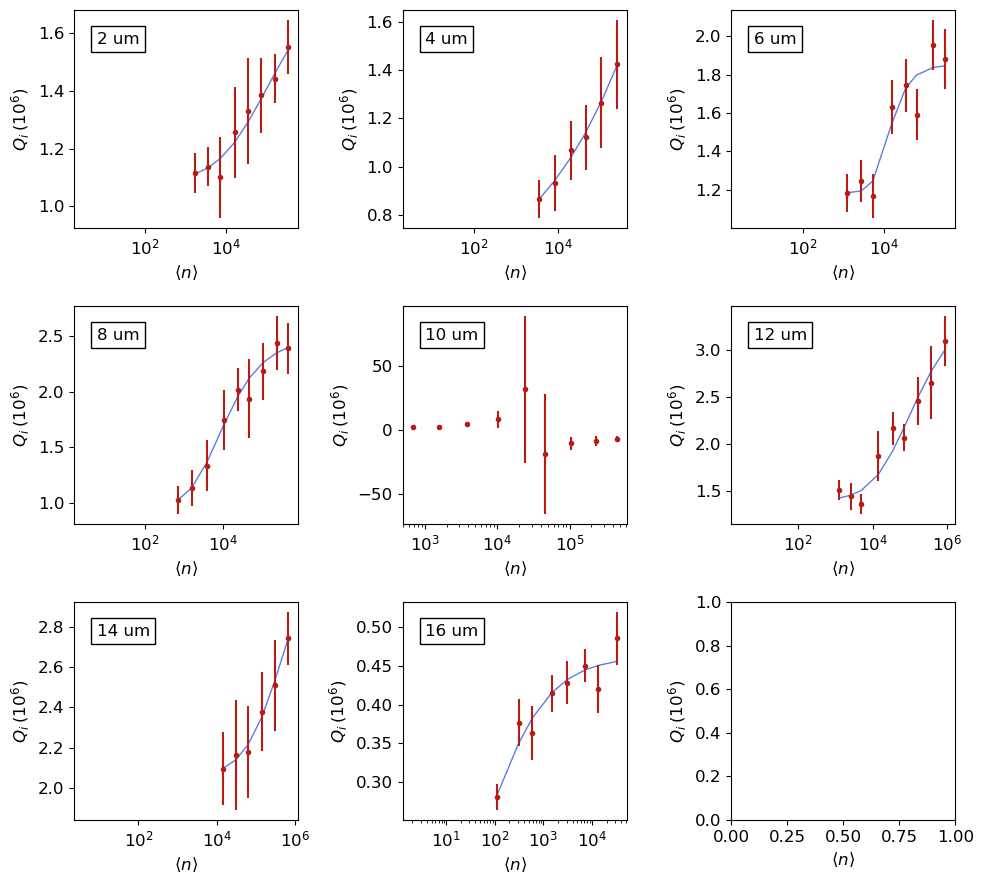

In [489]:
if sample == 'hf3':
    max_power = [-40, -50, -35, -40, -25, -25, -25, -25]

    cfg = ana_tls.fit_qi(res_params, params, img_pth, max_power_vec = max_power) 
    ana_tls.plot_res_pars([params], [''],img_pth)
    #params_nohf_low_pow = copy.deepcopy(params)
    params_hf = copy.deepcopy(params)
else:
    min_power = [-35, -35, -35, -35, -35, -35, -35, -35]
    max_power = [24, 18, 24, 35, 37, 28, 18, 23]
    
    
    cfg = fit_qi(res_params, params, img_pth, max_power_vec = max_power, min_power_vec = min_power) 
    # ana_tls.plot_res_pars([params], [''],img_pth)
    # params_no_hf = copy.deepcopy(params)


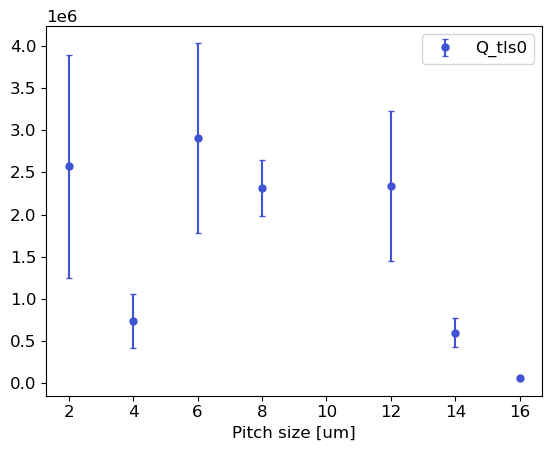

In [484]:
#params_11 = params
#params_12 = params
#params_10 = params
index_12 = np.array([2,7])
index_11 = np.array([1, 3, 6])
index_10 = np.array([0,5])
pitch_new = np.array([2,4,6,8,12,14,16])
qtls0_new = np.array([params_10['qtls0'][0], params_11['qtls0'][1], params_12['qtls0'][2], params_11['qtls0'][3], params_10['qtls0'][4],params_11['qtls0'][5], params_12['qtls0'][6] ] )
qtls0_err_new = np.array([ params_10['qtls0_err'][0], params_11['qtls0_err'][1], params_12['qtls0_err'][2], params_11['qtls0_err'][3], params_10['qtls0_err'][4],params_11['qtls0_err'][5], params_12['qtls0_err'][6] ])
qother_new = np.array([ params_10['qother'][0], params_11['qother'][1], params_12['qother'][2], params_11['qother'][3], params_10['qother'][4],params_11['qother'][5], params_12['qother'][6] ] )
qother_err_new = np.array([ params_10['qother_err'][0], params_11['qother_err'][1], params_12['qother_err'][2], params_11['qother_err'][3], params_10['qother_err'][4],params_11['qother_err'][5], params_12['qother_err'][6] ] )
qc_new = np.array([ params_10['qc'][0], params_11['qc'][1], params_12['qc'][2], params_11['qc'][3], params_10['qc'][5],params_11['qc'][6], params_12['qc'][7] ] )
qc_err_new = np.array([ params_10['qc_err'][0], params_11['qc_err'][1], params_12['qc_err'][2], params_11['qc_err'][3], params_10['qc_err'][5],params_11['qc_err'][6], params_12['qc_err'][7] ] )
plt.errorbar(pitch_new, qtls0_new, yerr = qtls0_err_new, fmt='.', label = 'Q_tls0', capsize = 2)
plt.xlabel('Pitch size [um]')
plt.legend()

Text(0.5, 0, 'Pitch size [um]')

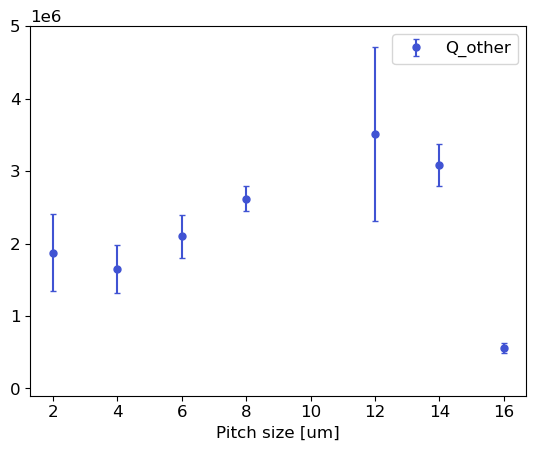

In [481]:
plt.errorbar(pitch_new, qother_new, yerr = qother_err_new, label = 'Q_other', fmt = '.', capsize = 2)
plt.legend()
plt.ylim(-10**5, 5*10**6)
plt.xlabel('Pitch size [um]')

Text(0.5, 0, 'Pitch size [um]')

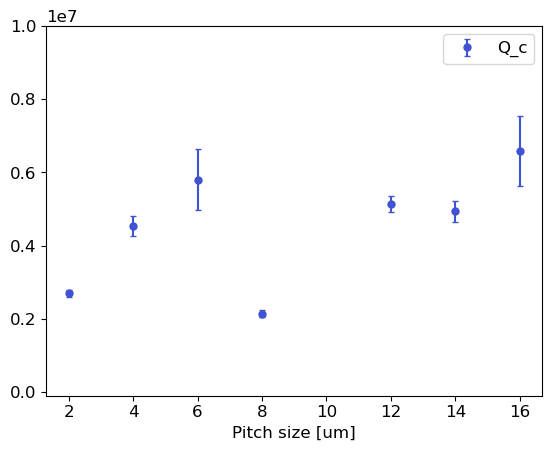

In [486]:
plt.errorbar(pitch_new, qc_new, yerr = qc_err_new, label = 'Q_c', fmt = '.', capsize = 2)
plt.legend()
plt.ylim(-10**5, 10*10**6)
plt.xlabel('Pitch size [um]')

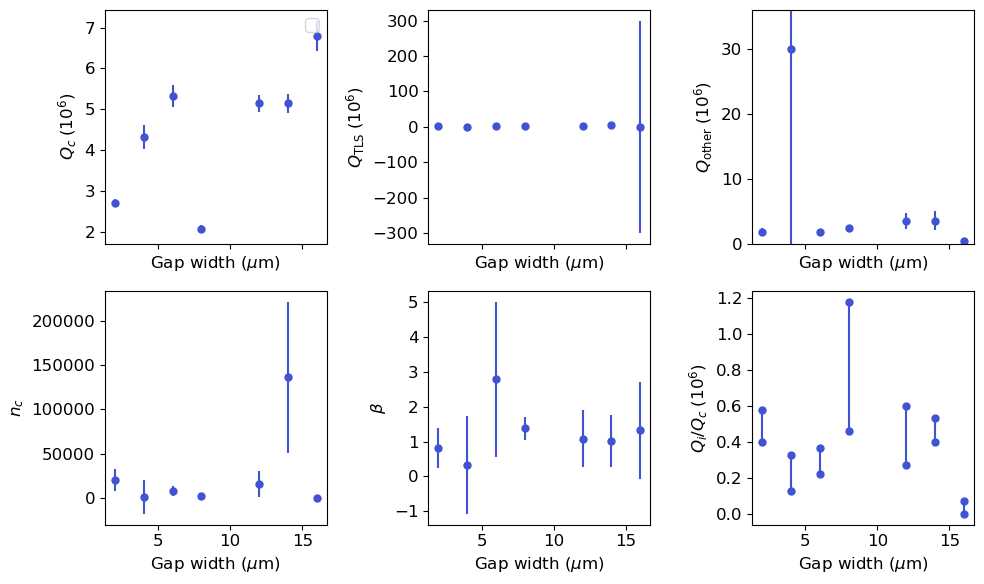

In [463]:


params_ = copy.deepcopy(params)
params_['pitch'] = np.delete(params['pitch'], 4)
params_['qc'] = np.delete(params['qc'], 4)
params_['qc_err'] = np.delete(params['qc_err'], 4)
#params_['qtls0_err'] = np.delete(params['qtls0_err'], 4)
#params_['qother_err'] = np.delete(params['qother_err'], 4)
#params_['nc_err'] = np.delete(params['nc_err'], 4)
#params_['beta_err'] = np.delete(params['beta_err'], 4)

ana_tls.plot_res_pars([params_], [''],img_pth)
params_no_hf = copy.deepcopy(params)

In [464]:
def plot_res_pars(params_list, labs, base_pth):
    plt.rcParams['lines.markersize'] = 10
    sns.set_palette(colors)
    fig, ax = plt.subplots(2,3, figsize=(10,6), sharex=True)
    ax = ax.flatten()
    fnames = ''
    i=0
    for params, l in zip(params_list,labs):

        fnames += params['res_name']+'_'
        ax[0].errorbar(params['pitch'], params['qc']/1e6, yerr=params['qc_err']/1e6, fmt='.',label=l)
        ax[1].errorbar(params['pitch'], params['qtls0']/1e6,yerr=params['qtls0_err']/1e6, fmt='.')
        ax[2].errorbar(params['pitch'], params['qother']/1e6,yerr=params['qother_err']/1e6, fmt='.')
        ax[3].errorbar(params['pitch'], params['nc'], yerr=params['nc_err'], fmt='.')
        ax[4].errorbar(params['pitch'], params['beta'], yerr=params['beta_err'], fmt='.')
        for j in range(len(params['pitch'])):
            ax[5].plot((params['pitch'][j],params['pitch'][j]), (params['qi0'][j]/params['qc'][j],params['qi_hi'][j]/params['qc'][j]), '.-', label=l, color=colors[i])
        #ax[5].plot((params['pitch'],(params['pitch']), params['qi0']/params['qc'],params['qi_hi']/params['qc']), '.-', label=l, color=colors[i])
        #ax[5].plot(params['pitch'], params['qi_hi']/params['qc'], '.', label=l, color=colors[i])

        if ax[2].get_ylim()[1]>30: 
            ax[2].set_ylim(0,np.nanmax(params['qother']/1e6)*1.1)
        #ax[1].set_ylim(0,np.nanmax(params['qtls0']/1e6)*1.1)
        
        if ax[2].get_ylim()[1]>13: 
             ax[2].set_ylim(0,np.nanmax(params['qother']/1e6)*1.2)
        #ax[3].set_ylim(0,np.nanmax(qtls0/1e6)*1.1)
        i+=1
    
    ax[0].legend()
    ax[0].set_ylabel('$Q_c \; (10^6)$')
    
    ax[1].set_ylabel(r'$Q_{\mathrm{TLS}} \; ( 10^6) $')
    ax[2].set_ylabel(r'$Q_{\mathrm{other}}  \; (10^6) $')
    ax[4].set_ylabel('$\\beta$') 
    ax[3].set_ylabel('$n_c$')
    ax[5].set_ylabel(r'$Q_{i}/Q_c  \; (10^6) $')
    for a in ax:         
        a.set_xlabel('Gap width ($\mu$m)')    
    fig.tight_layout()

    fig.savefig(base_pth +fnames+'params_tls_full.png', dpi=300)

Text(0, 0.5, 'Q other')

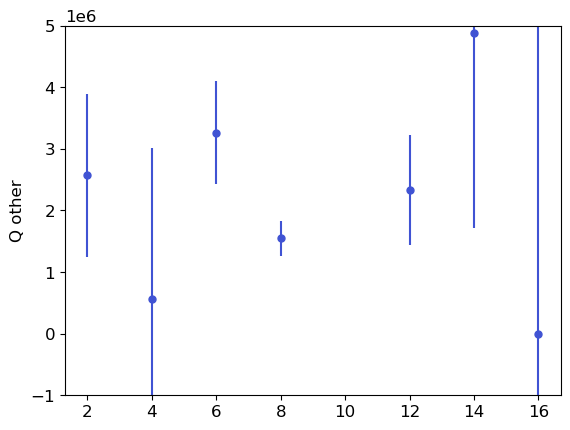

In [465]:

#plt.plot(cfg['pitch'], cfg['qtls0'], '.')
#plt.errorbar(params_['pitch'], y=params_['qother'], yerr = params_['qother_err'],fmt='.')
plt.errorbar(params_['pitch'], y=params_['qtls0'], yerr = params_['qtls0_err'],fmt='.')
plt.ylim(-10**6,5*10**6)
plt.ylabel('Q other')
#plt.ylabel('Q TLS0')

### Print out info for running scans

In [14]:
lw=[]
freq =[]
print('linewidth')
for i in range(len(params['freqs'])):
    q = 1/(1/params['qi0'][i]+1/params['qc'][i])
    lw.append(params['freqs'][i]/q)
    freq.append(params['freqs'][i])

print(lw)
print(freq)

linewidth
[30280.45663205266, 36573.839723565376, 23310.47610030494, 20449.658141614582, 12628.992384510642, 12592.140345702854, 15819.375033133289, 20216.294023869923]
[6336554140.323767, 6692445750.26349, 7056424707.435022, 7382929512.63772, 5516760932.618641, 5820847654.774935, 6091773974.418745, 6376981212.273887]


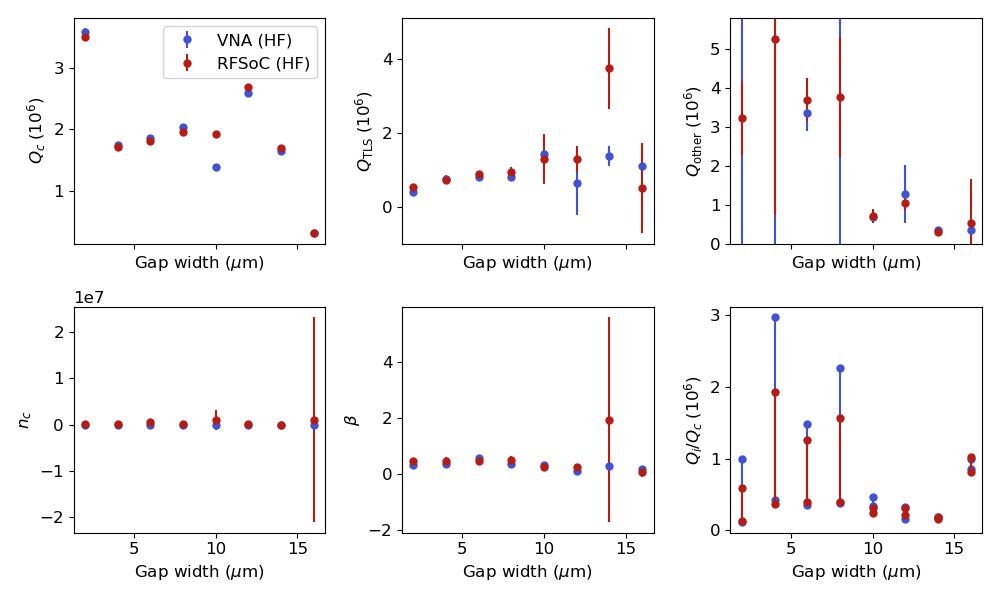

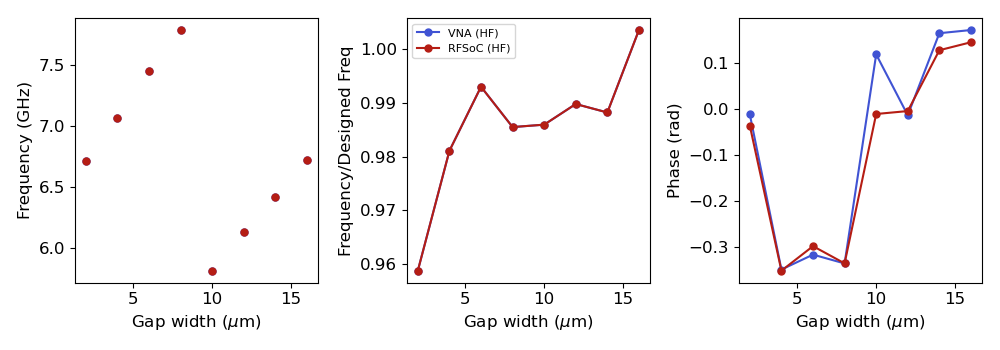

In [ ]:
%matplotlib widget
#pnames = ['240814-2','240725','240729-2', '240729-4']
#labs = ['ScalinQ (No HF)', 'SLab (No HF)', 'SLab (HF)', 'RFSoC (HF)'] 

#pnames = ['240729-2', '240729-3']
pnames = ['240729-3', '240820_soc']
labs = ['VNA (HF)', 'RFSoC (HF)'] 
plist =[]
for p in pnames:
    plist.append(hy.load(img_pth +'Text/'+ p + '.yml'))

ana_tls.plot_res_pars(plist, labs,img_pth)
ana_res.plot_res_pars(plist, labs,img_pth)


## Single resonators

In [ ]:
# Grab list of resonators following corect format in directory. 

pattern0 = r'res_(\d+)_\d{2,3}dbm'
resonators, file_list0 = ana_res.get_resonators(directories[0],pth, pattern0)

pattern = 'res_{:d}_'.format(resonators[0]) + '(\d{2,3})dbm'
file_list = ana_res.get_resonator_power_list(pattern, file_list0)

### Fit slope for RFSoC phase correction

In [ ]:
pth = r'/Users/sph/Library/CloudStorage/GoogleDrive-circuitqed@gmail.com/My Drive/Projects/Materials/Data/240816-Resonator'

plt.figure()
data, attrs = hy.prev_data(pth, 'test2')
plt.plot(data['xpts'][0], data['phases'][0])
slope, ofs = np.polyfit(data['xpts'][0], np.unwrap(data['phases'][0]), 1)
data['phases'] = np.unwrap(data['phases'][0]) - slope * data['xpts'][0]-ofs

print(slope)

data['phases']

In [ ]:
# Grab list of resonators following corect format in directory. 

pth = r'/Users/sph/Library/CloudStorage/GoogleDrive-circuitqed@gmail.com/My Drive/Projects/Materials/Data/240818-Resonator/'

#directories = ['240816-Resonator/powersweep3']
directories = ['powersweep2']
pattern0 = r'res_(\d+)_\d'
resonators, file_list = ana_res.get_resonators(directories[0],pth, pattern0)

In [ ]:
file_list

In [ ]:
fname =  'res_6423_4096_wideright'
data, attrs = hy.prev_data(pth+directories[0], fname)

data.keys()

In [ ]:
data = ana_res.grab_data(pth+directories[0], file_list[4], 'soc', slope=slope)
#ana_res.plot_raw_data(data)
output = ana_res.fit_resonator(data, fname, img_pth, plot=True)   

In [ ]:
sorted_file_list = sorted(file_list)
print(sorted_file_list)

In [ ]:
file_list[12]

In [ ]:
%matplotlib widget

for i in range(len(file_list)):
    #try:
    data = ana_res.grab_data(pth+directories[0], file_list[i])       
    ana_res.plot_raw_data(data)
    #output = ana_res.fit_resonator(data, file_list[i], output_path, 'png')    
    #except: 
    #    print('fit failed')  
7.714986

In [ ]:

pth = '../../../../JJ_fab/Coherence Sample/Resonators Measurement/240725/data/power_sweep5'
fname = 'res_7083855_60dbm_wide'
data = ana_res.grab_data(pth, fname)
output = ana_res.fit_resonator(data, fname, img_pth, plot=True)   
ana_res.plot_raw_data(data)

### Temp sweep

In [ ]:
# Initialize the directories list for a temperature sweep 
temps, directories = ana_res.get_temp_list(pth_base, max_temp=1500)
res_params = ana_res.analyze_sweep(directories)

ana_res.plot_power_temp(res_params,i,params,img_pth)